In [1]:
#使用几个benchmark数据集进行实验评估
import xgboost as xgb
import lightgbm as lgb
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import tarfile
import bz2

from catboost import CatBoostRegressor
from pandas import DataFrame, Series
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split,GridSearchCV
from bz2 import BZ2File as b2f
from libsvm.commonutil import svm_read_problem
from sklearn.svm import SVR
#屏蔽warning
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
#读取相关数据库数据
def read_libsvm_data(dataset_name):
    y,x = svm_read_problem('./dataset/'+dataset_name+'/'+dataset_name+'.txt')
    #print(y)
    #print(x)
    #从字典中提取出来
    X = []
    for i in range(len(x)):
        xx =[]
        for key,value in x[i].items():
            xx.append(value)
        X.append(xx)
    
    X = DataFrame(X)
    y = Series(y)
    return y,X
    

In [3]:
"""
    A method which can be used for sklearn library training and xgboost, lightgbm and catboost 
"""
n_fold = 10 #10折交叉验证
folds = KFold(n_splits = n_fold,shuffle = True,random_state = 42)
def train_model(X,  y, params=None, folds=folds,
                model_type='lgb', plot_feature_importance=False, model=None):
    """

    :param X: 训练集输入 数据类型：dataframe
    :param X_test: 测试集输入 数据类型：dataframe
    :param y: 训练集y 数据类型：Series
    :param params: 相关参数
    :param folds: 交叉验证折数
    :param model_type: lgb、xgb、cat、rfr或者sklearn
    :param plot_feature_importance: 是否plot feature importance
    :param model:
    :return:
    """
    oof = np.zeros(X.shape[0])  # 生成一个跟X行数一样长的零矩阵
    #prediction = np.zeros(X_test.shape[0])
    scores = []
    feature_importance = pd.DataFrame()  # 生成空矩阵
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        #print(train_index)
        if model_type == 'sklearn':
            X_train, X_valid = X[train_index], X[valid_index]
        else:
            X_train, X_valid = X.values[train_index], X.values[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'svr':
            
            model = model
            model.fit(X_train, y_train)
            
            #y_pred_valid = model.best_estimator_.predict(X_valid).reshape(-1, )
            y_pred_valid = model.predict(X_valid).reshape(-1, )
            score = mean_squared_error(y_valid, y_pred_valid)
        
        if model_type == 'rfr':
            """
                注意randomforest对nan敏感 需要做处理
            """
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict(X_valid).reshape(-1, )
            score = mean_squared_error(y_valid, y_pred_valid)

            #y_pred = model.predict(X_test)

        if model_type == 'lgb':
            """
                #**动态参数 
                n_estimators=100: 要拟合的树的棵树，可以认为是训练轮数 
                n_jobs=1: 并行运行的多线程数 
                nthread [默认为未设置的最大线程数]并行线程数
                """
            model = lgb.LGBMRegressor(**params, n_estimators=20000, nthread=4, n_jobs=-1)
            """
                #eval_metric: 评价指标 rmse - 均方根误差 
                early_stopping_rounds: 提前结束轮数 
                eval_set:训练集与测试集 
                verbose=1000使用详细日志记录级别并将日志记录周期设置为此参数的值
                """
            model.fit(X_train, y_train,
                      eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
                      verbose=1000, early_stopping_rounds=200)

            y_pred_valid = model.predict(X_valid)
            #y_pred = model.predict(X_test, num_iteration=model.best_iteration_)

        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train)  # 使用XGBoost的原生版本需要对数据进行转化
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200,
                              verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid), ntree_limit=model.best_ntree_limit)
            
            #y_pred = model.predict(xgb.DMatrix(X_test.values), ntree_limit=model.best_ntree_limit)

        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict(X_valid).reshape(-1, )
            score = mean_squared_error(y_valid, y_pred_valid)

            #y_pred = model.predict(X_test)

        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000, eval_metric='RMSE',
                                      **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True,
                      verbose=False)

            y_pred_valid = model.predict(X_valid)
            #y_pred = model.predict(X_test)

        oof[valid_index] = y_pred_valid.reshape(-1, )  # reshape(-1,)转换成一行 将对valid的预测结果存成矩阵
        scores.append(mean_squared_error(y_valid, y_pred_valid) ** 0.5)  # 每交叉验证一次得到一个loss分数，一共有n_fold个值

        #prediction += y_pred  # 每次预测的结果累加 可能需要.reshape(-1,)

        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1  # 第几次交叉验证的标志
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)  # 将每次交叉验证的结果得到的变量importance保存

    #prediction /= n_fold

    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))

    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)')
            
            return oof,feature_importance
            #return oof, prediction, feature_importance
        return oof
        #return oof, prediction

    else:
        return oof
        #return oof, prediction

## bodyfat数据集实验

In [4]:
#file = read_bz2_file('./dataset/E2006-tfidf/E2006.test.bz2')
y,X = read_libsvm_data('bodyfat')

### 基学习器的训练

#### support vector regression

In [5]:
#support vector regression
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr = train_model(X, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 00:05:08 2019
Fold 1 started at Tue Dec 17 00:05:08 2019
Fold 2 started at Tue Dec 17 00:05:08 2019
Fold 3 started at Tue Dec 17 00:05:08 2019
Fold 4 started at Tue Dec 17 00:05:08 2019
Fold 5 started at Tue Dec 17 00:05:08 2019
Fold 6 started at Tue Dec 17 00:05:08 2019
Fold 7 started at Tue Dec 17 00:05:08 2019
Fold 8 started at Tue Dec 17 00:05:08 2019
Fold 9 started at Tue Dec 17 00:05:08 2019
CV mean score: 0.0197, std: 0.0037.


#### lightgbm

Fold 0 started at Tue Dec 17 00:05:08 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[564]	training's rmse: 0.00617057	valid_1's rmse: 0.00269838
Fold 1 started at Tue Dec 17 00:05:09 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[699]	training's rmse: 0.00606342	valid_1's rmse: 0.00398774
Fold 2 started at Tue Dec 17 00:05:10 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[666]	training's rmse: 0.00604245	valid_1's rmse: 0.00434099
Fold 3 started at Tue Dec 17 00:05:12 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[643]	training's rmse: 0.00566677	valid_1's rmse: 0.010692
Fold 4 started at Tue Dec 17 00:05:13 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[632]	training's rmse: 0.00532563	valid_1's rmse: 0.0

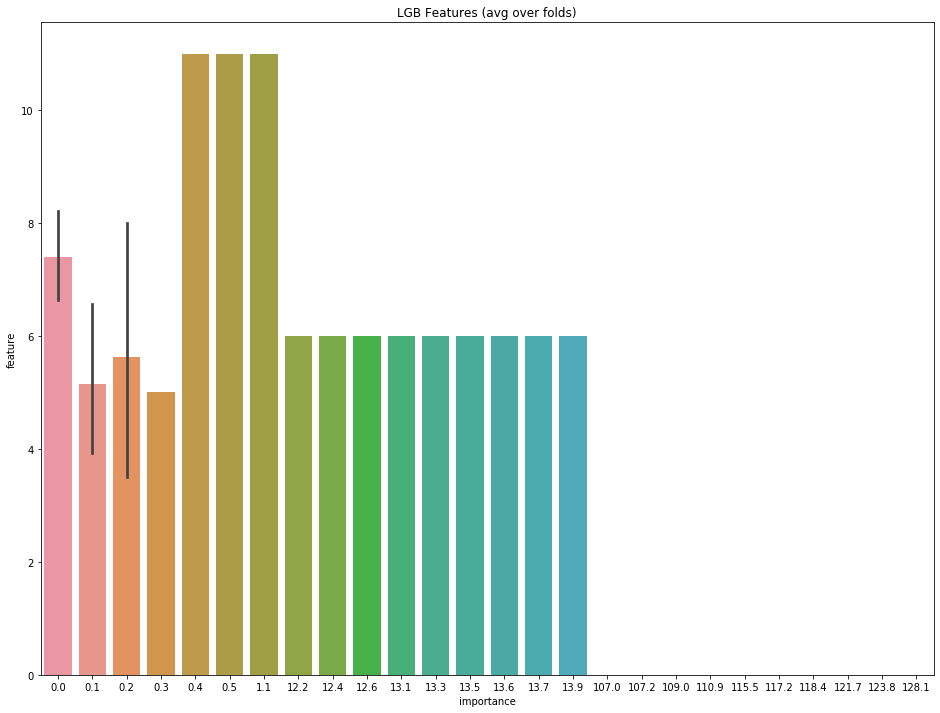

In [6]:
#lgb训练
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb, _ = train_model(X, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 00:05:18 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[564]	training's rmse: 0.00617057	valid_1's rmse: 0.00269838
Fold 1 started at Tue Dec 17 00:05:18 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[699]	training's rmse: 0.00606342	valid_1's rmse: 0.00398774
Fold 2 started at Tue Dec 17 00:05:19 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[666]	training's rmse: 0.00604245	valid_1's rmse: 0.00434099
Fold 3 started at Tue Dec 17 00:05:19 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[643]	training's rmse: 0.00566677	valid_1's rmse: 0.010692
Fold 4 started at Tue Dec 17 00:05:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[632]	training's rmse: 0.00532563	valid_1's rmse: 0.0

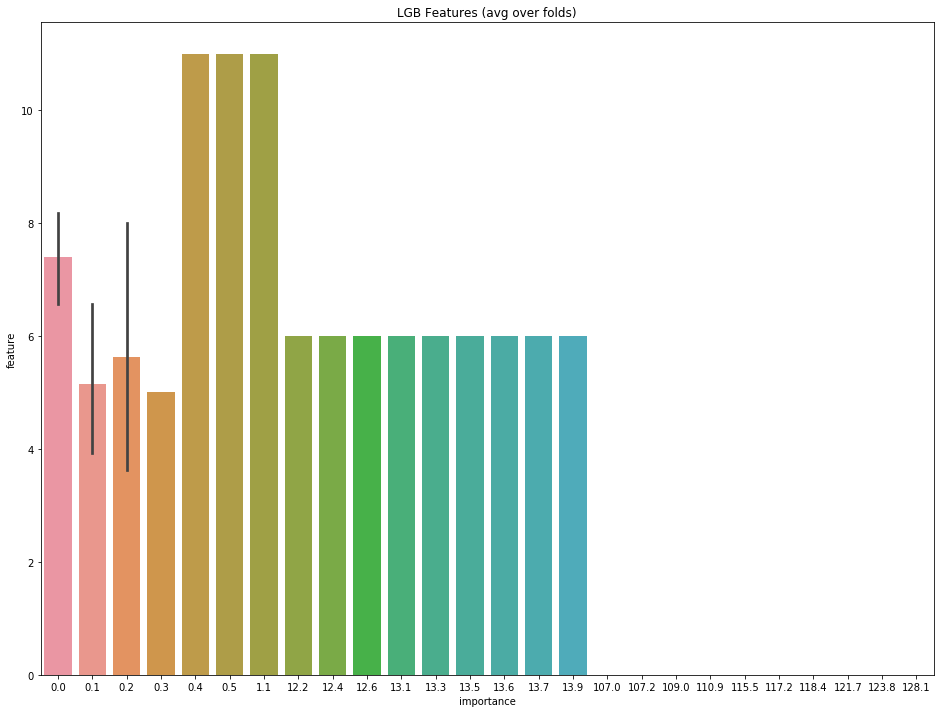

In [7]:
#交叉验证
#训练一个lgb
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_1, _ = train_model(X, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 00:05:24 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[564]	training's rmse: 0.00617057	valid_1's rmse: 0.00269838
Fold 1 started at Tue Dec 17 00:05:25 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[699]	training's rmse: 0.00606342	valid_1's rmse: 0.00398774
Fold 2 started at Tue Dec 17 00:05:25 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[666]	training's rmse: 0.00604245	valid_1's rmse: 0.00434099
Fold 3 started at Tue Dec 17 00:05:26 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[643]	training's rmse: 0.00566677	valid_1's rmse: 0.010692
Fold 4 started at Tue Dec 17 00:05:27 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[632]	training's rmse: 0.00532563	valid_1's rmse: 0.0

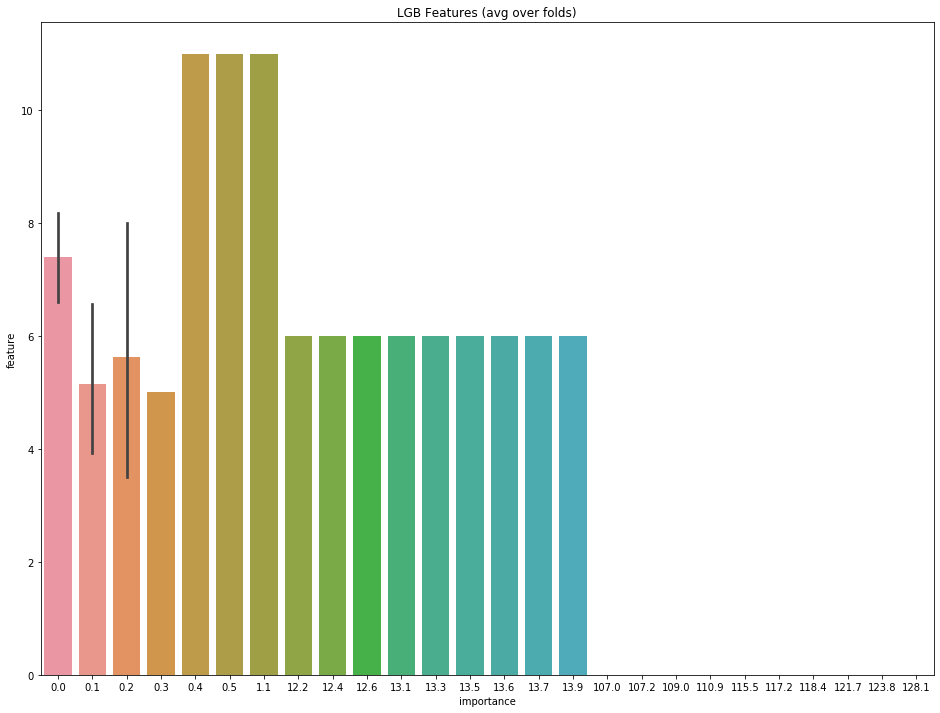

In [8]:
#另一组lgb的训练
pparams = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 7,
         'learning_rate': 0.02,
         "boosting": "gbdt",
         "feature_fraction": 0.7,
         "bagging_freq": 5,
         "bagging_fraction": 0.7,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_2,  _ = train_model(X, y, params=params, model_type='lgb', plot_feature_importance=True)

#### random forest regression

In [9]:
#随机森林的训练
#训练rfr
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr = train_model(X,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 00:05:34 2019
Fold 1 started at Tue Dec 17 00:05:34 2019
Fold 2 started at Tue Dec 17 00:05:34 2019
Fold 3 started at Tue Dec 17 00:05:35 2019
Fold 4 started at Tue Dec 17 00:05:35 2019
Fold 5 started at Tue Dec 17 00:05:35 2019
Fold 6 started at Tue Dec 17 00:05:35 2019
Fold 7 started at Tue Dec 17 00:05:36 2019
Fold 8 started at Tue Dec 17 00:05:36 2019
Fold 9 started at Tue Dec 17 00:05:36 2019
CV mean score: 0.0059, std: 0.0026.


#### xgboost

In [10]:
#xgboost
#训练xgboost
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb = train_model(X,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 00:05:36 2019
[0]	train-rmse:0.550137	valid_data-rmse:0.552468
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.004891	valid_data-rmse:0.004493
[1000]	train-rmse:0.000563	valid_data-rmse:0.000679
[1500]	train-rmse:0.000429	valid_data-rmse:0.000646
[2000]	train-rmse:0.000418	valid_data-rmse:0.00064
Stopping. Best iteration:
[2189]	train-rmse:0.000414	valid_data-rmse:0.000638

Fold 1 started at Tue Dec 17 00:05:37 2019
[0]	train-rmse:0.550162	valid_data-rmse:0.55234
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.004881	valid_data-rmse:0.004498
[1000]	train-rmse:0.000552	valid_data-rmse:0.001287
[1500]	train-rmse:0.000413	valid_data-rmse:0.001249
Stopping. Best iteration:
[1572]	train-rmse:0.000412	valid_data-r

#### catboost

In [11]:
#catboost
#catboost训练
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat = train_model(X, y, params=cat_params, model_type='cat')

Fold 0 started at Tue Dec 17 00:05:44 2019
Fold 1 started at Tue Dec 17 00:06:17 2019
Fold 2 started at Tue Dec 17 00:06:48 2019
Fold 3 started at Tue Dec 17 00:06:54 2019
Fold 4 started at Tue Dec 17 00:07:26 2019
Fold 5 started at Tue Dec 17 00:07:58 2019
Fold 6 started at Tue Dec 17 00:08:30 2019
Fold 7 started at Tue Dec 17 00:08:34 2019
Fold 8 started at Tue Dec 17 00:09:05 2019
Fold 9 started at Tue Dec 17 00:09:37 2019
CV mean score: 0.0032, std: 0.0023.


### stacking

#### 所有结果均用于做stacking

In [12]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_svr,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2','svr','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 00:10:08 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[551]	training's rmse: 0.00616635	valid_1's rmse: 0.00268463
Fold 1 started at Tue Dec 17 00:10:09 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[575]	training's rmse: 0.0061516	valid_1's rmse: 0.00414803
Fold 2 started at Tue Dec 17 00:10:09 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[507]	training's rmse: 0.00616457	valid_1's rmse: 0.00458975
Fold 3 started at Tue Dec 17 00:10:10 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[564]	training's rmse: 0.00570499	valid_1's rmse: 0.0109497
Fold 4 started at Tue Dec 17 00:10:10 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[529]	training's rmse: 0.00540671	valid_1's rmse: 0.0

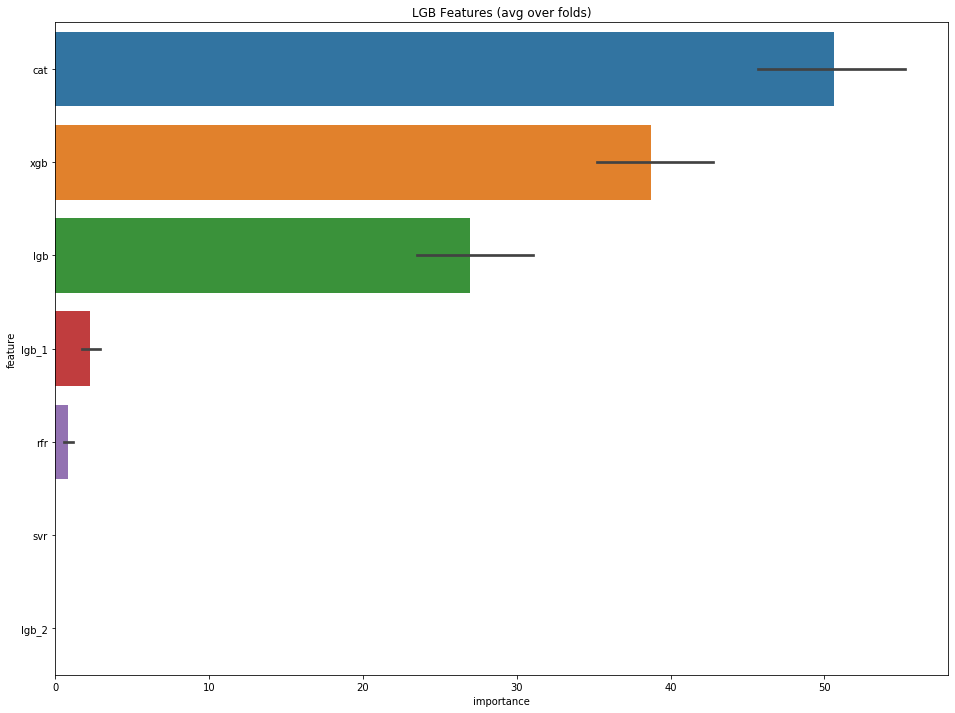

In [13]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 00:10:14 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00589349	valid_1's rmse: 0.00245621
[2000]	training's rmse: 0.00589036	valid_1's rmse: 0.00245399
Early stopping, best iteration is:
[2525]	training's rmse: 0.00589036	valid_1's rmse: 0.00245399
Fold 1 started at Tue Dec 17 00:10:15 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00589836	valid_1's rmse: 0.00389688
[2000]	training's rmse: 0.00589506	valid_1's rmse: 0.00389355
[3000]	training's rmse: 0.00589506	valid_1's rmse: 0.00389355
Early stopping, best iteration is:
[3730]	training's rmse: 0.00589506	valid_1's rmse: 0.00389355
Fold 2 started at Tue Dec 17 00:10:19 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00582524	valid_1's rmse: 0.00430938
[2000]	training's rmse: 0.00582164	valid_1's rmse: 0.00430667
[3000]	training's rmse: 0.00582164	valid_1's rmse: 0.0

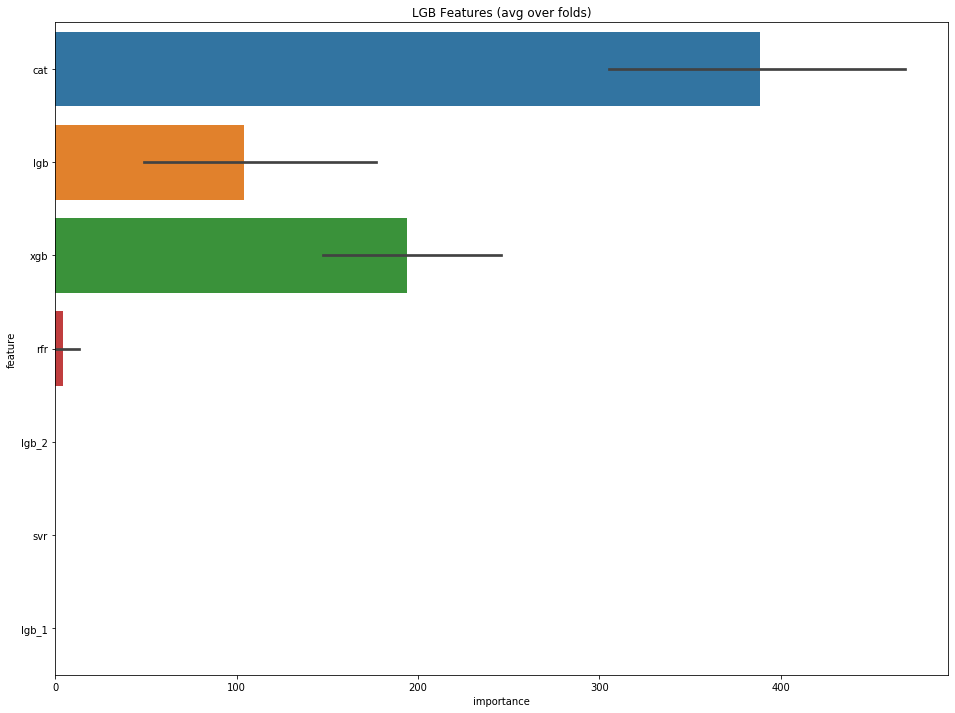

In [14]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [15]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 00:10:41 2019
Fold 1 started at Tue Dec 17 00:10:47 2019
Fold 2 started at Tue Dec 17 00:11:17 2019
Fold 3 started at Tue Dec 17 00:11:21 2019
Fold 4 started at Tue Dec 17 00:11:55 2019
Fold 5 started at Tue Dec 17 00:12:28 2019
Fold 6 started at Tue Dec 17 00:12:33 2019
Fold 7 started at Tue Dec 17 00:12:36 2019
Fold 8 started at Tue Dec 17 00:12:48 2019
Fold 9 started at Tue Dec 17 00:13:00 2019
CV mean score: 0.0033, std: 0.0023.


##### randomforest作为第二层融合模型

In [16]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 00:13:04 2019
Fold 1 started at Tue Dec 17 00:13:04 2019
Fold 2 started at Tue Dec 17 00:13:04 2019
Fold 3 started at Tue Dec 17 00:13:04 2019
Fold 4 started at Tue Dec 17 00:13:04 2019
Fold 5 started at Tue Dec 17 00:13:05 2019
Fold 6 started at Tue Dec 17 00:13:05 2019
Fold 7 started at Tue Dec 17 00:13:05 2019
Fold 8 started at Tue Dec 17 00:13:05 2019
Fold 9 started at Tue Dec 17 00:13:06 2019
CV mean score: 0.0039, std: 0.0025.


##### xgboost作为第二层融合模型

In [17]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 00:13:06 2019
[0]	train-rmse:0.550137	valid_data-rmse:0.552468
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.004963	valid_data-rmse:0.004311
Stopping. Best iteration:
[699]	train-rmse:0.001695	valid_data-rmse:0.002036

Fold 1 started at Tue Dec 17 00:13:06 2019
[0]	train-rmse:0.550162	valid_data-rmse:0.55234
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.004971	valid_data-rmse:0.004226
[1000]	train-rmse:0.00078	valid_data-rmse:0.00135
[1500]	train-rmse:0.000653	valid_data-rmse:0.001346
Stopping. Best iteration:
[1340]	train-rmse:0.00067	valid_data-rmse:0.001344

Fold 2 started at Tue Dec 17 00:13:07 2019
[0]	train-rmse:0.550262	valid_data-rmse:0.551404
Multiple eval metrics have been passed: 'valid_data-r

##### svr 作为第二层融合模型

In [18]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 00:13:10 2019
Fold 1 started at Tue Dec 17 00:13:10 2019
Fold 2 started at Tue Dec 17 00:13:10 2019
Fold 3 started at Tue Dec 17 00:13:10 2019
Fold 4 started at Tue Dec 17 00:13:10 2019
Fold 5 started at Tue Dec 17 00:13:10 2019
Fold 6 started at Tue Dec 17 00:13:10 2019
Fold 7 started at Tue Dec 17 00:13:10 2019
Fold 8 started at Tue Dec 17 00:13:10 2019
Fold 9 started at Tue Dec 17 00:13:10 2019
CV mean score: 0.0197, std: 0.0037.


##### 岭回归做第二层融合模型

In [19]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 00:13:10 2019
Fold 1 started at Tue Dec 17 00:13:10 2019
Fold 2 started at Tue Dec 17 00:13:10 2019
Fold 3 started at Tue Dec 17 00:13:10 2019
Fold 4 started at Tue Dec 17 00:13:10 2019
Fold 5 started at Tue Dec 17 00:13:10 2019
Fold 6 started at Tue Dec 17 00:13:10 2019
Fold 7 started at Tue Dec 17 00:13:11 2019
Fold 8 started at Tue Dec 17 00:13:11 2019
Fold 9 started at Tue Dec 17 00:13:11 2019
CV mean score: 0.0036, std: 0.0026.


#### 去掉lgb的结果

In [20]:
#构建第二层训练矩阵
train_stack = np.vstack([ oof_xgb, oof_cat, oof_svr,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=[ 'xgb', 'cat', 'svr','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 00:13:11 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[551]	training's rmse: 0.00618635	valid_1's rmse: 0.0027096
Fold 1 started at Tue Dec 17 00:13:11 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[575]	training's rmse: 0.00616529	valid_1's rmse: 0.00419228
Fold 2 started at Tue Dec 17 00:13:12 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[507]	training's rmse: 0.00617902	valid_1's rmse: 0.00461429
Fold 3 started at Tue Dec 17 00:13:12 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[539]	training's rmse: 0.00574534	valid_1's rmse: 0.0110167
Fold 4 started at Tue Dec 17 00:13:13 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[607]	training's rmse: 0.00537374	valid_1's rmse: 0.0

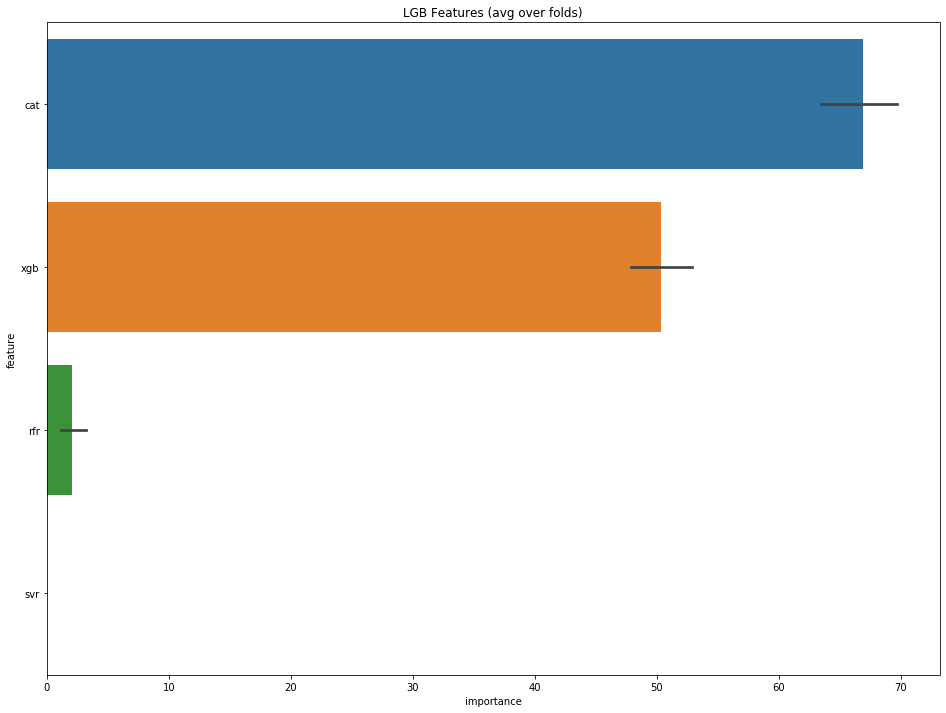

In [21]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 00:13:17 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00590565	valid_1's rmse: 0.00248225
[2000]	training's rmse: 0.00590252	valid_1's rmse: 0.00247993
[3000]	training's rmse: 0.00590252	valid_1's rmse: 0.00247993
Early stopping, best iteration is:
[3141]	training's rmse: 0.00590252	valid_1's rmse: 0.00247993
Fold 1 started at Tue Dec 17 00:13:19 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00590099	valid_1's rmse: 0.00393527
[2000]	training's rmse: 0.0058977	valid_1's rmse: 0.00393208
[3000]	training's rmse: 0.0058977	valid_1's rmse: 0.00393208
Early stopping, best iteration is:
[3712]	training's rmse: 0.0058977	valid_1's rmse: 0.00393208
Fold 2 started at Tue Dec 17 00:13:21 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00583174	valid_1's rmse: 0.00433727
[2000]	training's rmse: 0.00582815	valid_1's rmse: 0.0043

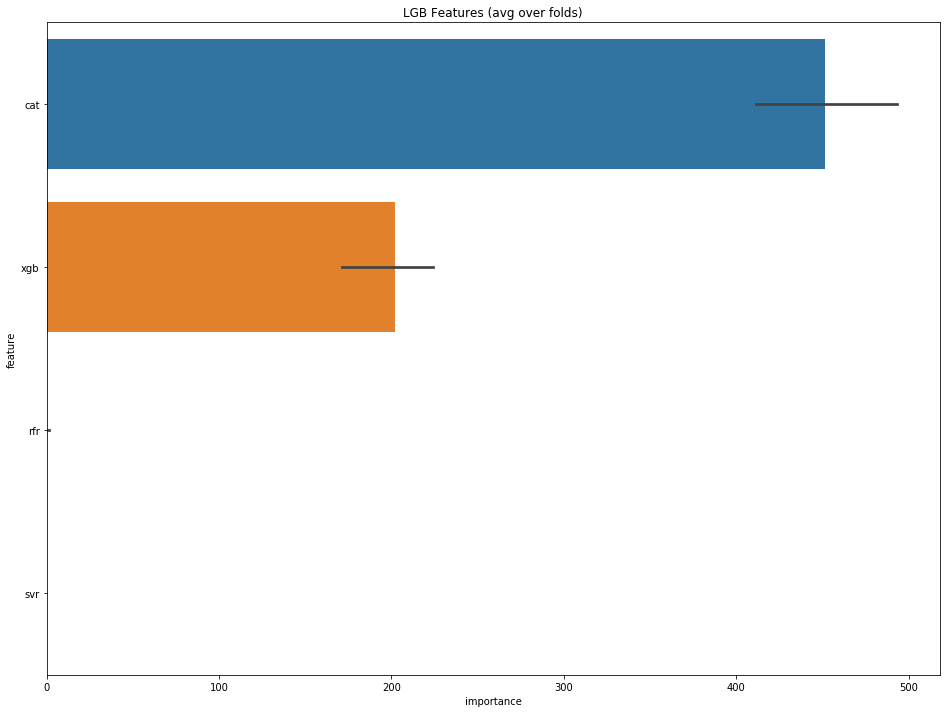

In [22]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [23]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 00:13:41 2019
Fold 1 started at Tue Dec 17 00:13:44 2019
Fold 2 started at Tue Dec 17 00:14:01 2019
Fold 3 started at Tue Dec 17 00:14:03 2019
Fold 4 started at Tue Dec 17 00:14:20 2019
Fold 5 started at Tue Dec 17 00:14:49 2019
Fold 6 started at Tue Dec 17 00:15:02 2019
Fold 7 started at Tue Dec 17 00:15:04 2019
Fold 8 started at Tue Dec 17 00:15:15 2019
Fold 9 started at Tue Dec 17 00:15:28 2019
CV mean score: 0.0033, std: 0.0023.


##### randomforest作为第二层融合模型

In [24]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 00:15:31 2019
Fold 1 started at Tue Dec 17 00:15:31 2019
Fold 2 started at Tue Dec 17 00:15:31 2019
Fold 3 started at Tue Dec 17 00:15:31 2019
Fold 4 started at Tue Dec 17 00:15:32 2019
Fold 5 started at Tue Dec 17 00:15:32 2019
Fold 6 started at Tue Dec 17 00:15:32 2019
Fold 7 started at Tue Dec 17 00:15:32 2019
Fold 8 started at Tue Dec 17 00:15:32 2019
Fold 9 started at Tue Dec 17 00:15:33 2019
CV mean score: 0.0039, std: 0.0025.


##### xgboost作为第二层融合模型

In [25]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 00:15:33 2019
[0]	train-rmse:0.550137	valid_data-rmse:0.552468
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.004949	valid_data-rmse:0.004534
[1000]	train-rmse:0.000812	valid_data-rmse:0.001857
Stopping. Best iteration:
[830]	train-rmse:0.001089	valid_data-rmse:0.001825

Fold 1 started at Tue Dec 17 00:15:33 2019
[0]	train-rmse:0.550162	valid_data-rmse:0.55234
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.00498	valid_data-rmse:0.004088
Stopping. Best iteration:
[795]	train-rmse:0.001187	valid_data-rmse:0.001316

Fold 2 started at Tue Dec 17 00:15:34 2019
[0]	train-rmse:0.550262	valid_data-rmse:0.551404
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train u

##### svr 作为第二层融合模型

In [26]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 00:15:36 2019
Fold 1 started at Tue Dec 17 00:15:36 2019
Fold 2 started at Tue Dec 17 00:15:36 2019
Fold 3 started at Tue Dec 17 00:15:36 2019
Fold 4 started at Tue Dec 17 00:15:36 2019
Fold 5 started at Tue Dec 17 00:15:36 2019
Fold 6 started at Tue Dec 17 00:15:36 2019
Fold 7 started at Tue Dec 17 00:15:36 2019
Fold 8 started at Tue Dec 17 00:15:36 2019
Fold 9 started at Tue Dec 17 00:15:36 2019
CV mean score: 0.0197, std: 0.0037.


##### 岭回归做第二层融合模型

In [27]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 00:15:36 2019
Fold 1 started at Tue Dec 17 00:15:36 2019
Fold 2 started at Tue Dec 17 00:15:36 2019
Fold 3 started at Tue Dec 17 00:15:36 2019
Fold 4 started at Tue Dec 17 00:15:36 2019
Fold 5 started at Tue Dec 17 00:15:36 2019
Fold 6 started at Tue Dec 17 00:15:37 2019
Fold 7 started at Tue Dec 17 00:15:37 2019
Fold 8 started at Tue Dec 17 00:15:37 2019
Fold 9 started at Tue Dec 17 00:15:37 2019
CV mean score: 0.0034, std: 0.0025.


#### 去掉xgboost的结果

In [28]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb,  oof_cat, oof_lgb_1, oof_lgb_2,oof_svr,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb',  'cat', 'lgb_1', 'lgb_2','svr','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 00:15:37 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[550]	training's rmse: 0.00621021	valid_1's rmse: 0.00274352
Fold 1 started at Tue Dec 17 00:15:37 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[575]	training's rmse: 0.00619701	valid_1's rmse: 0.00420535
Fold 2 started at Tue Dec 17 00:15:38 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[507]	training's rmse: 0.00621781	valid_1's rmse: 0.0046097
Fold 3 started at Tue Dec 17 00:15:38 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[539]	training's rmse: 0.00576543	valid_1's rmse: 0.010913
Fold 4 started at Tue Dec 17 00:15:39 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[529]	training's rmse: 0.0054585	valid_1's rmse: 0.011

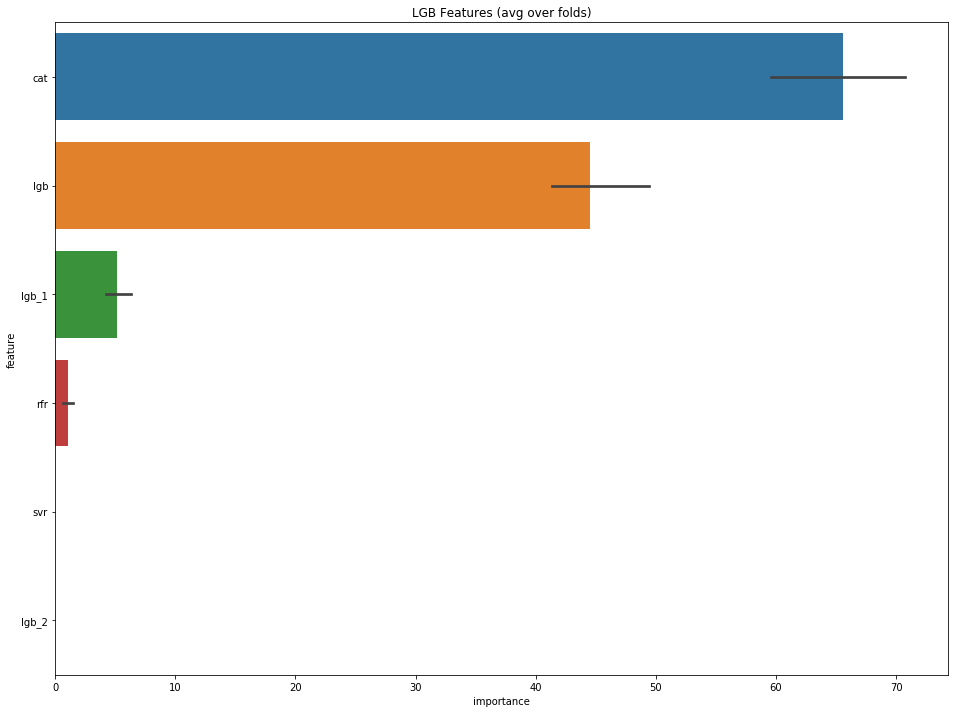

In [29]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 00:15:42 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00592148	valid_1's rmse: 0.0025264
[2000]	training's rmse: 0.00591774	valid_1's rmse: 0.00252451
Early stopping, best iteration is:
[2511]	training's rmse: 0.00591774	valid_1's rmse: 0.0025245
Fold 1 started at Tue Dec 17 00:15:44 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00592944	valid_1's rmse: 0.00392323
[2000]	training's rmse: 0.00592556	valid_1's rmse: 0.00391951
[3000]	training's rmse: 0.00592556	valid_1's rmse: 0.00391951
[4000]	training's rmse: 0.00592556	valid_1's rmse: 0.00391951
Early stopping, best iteration is:
[4363]	training's rmse: 0.00592556	valid_1's rmse: 0.00391951
Fold 2 started at Tue Dec 17 00:15:46 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00587783	valid_1's rmse: 0.00431093
[2000]	training's rmse: 0.00587397	valid_1's rmse: 0.004

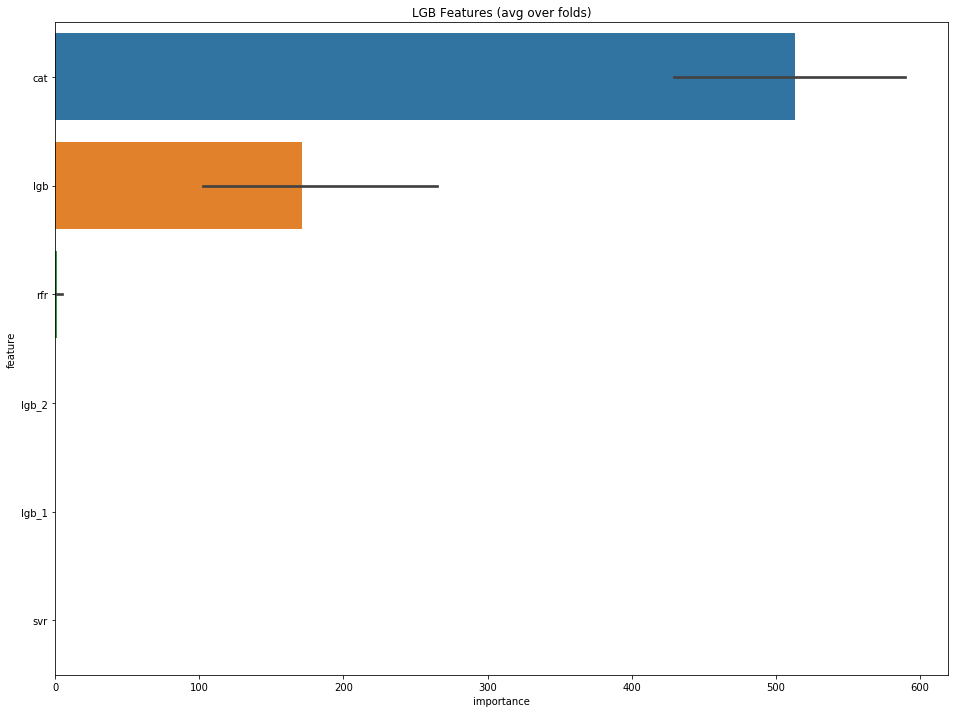

In [30]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [31]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 00:16:05 2019
Fold 1 started at Tue Dec 17 00:16:08 2019
Fold 2 started at Tue Dec 17 00:16:29 2019
Fold 3 started at Tue Dec 17 00:16:59 2019
Fold 4 started at Tue Dec 17 00:17:36 2019
Fold 5 started at Tue Dec 17 00:18:10 2019
Fold 6 started at Tue Dec 17 00:18:15 2019
Fold 7 started at Tue Dec 17 00:18:19 2019
Fold 8 started at Tue Dec 17 00:18:37 2019
Fold 9 started at Tue Dec 17 00:19:05 2019
CV mean score: 0.0035, std: 0.0023.


##### randomforest作为第二层融合模型

In [32]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 00:19:09 2019
Fold 1 started at Tue Dec 17 00:19:09 2019
Fold 2 started at Tue Dec 17 00:19:09 2019
Fold 3 started at Tue Dec 17 00:19:10 2019
Fold 4 started at Tue Dec 17 00:19:10 2019
Fold 5 started at Tue Dec 17 00:19:10 2019
Fold 6 started at Tue Dec 17 00:19:10 2019
Fold 7 started at Tue Dec 17 00:19:11 2019
Fold 8 started at Tue Dec 17 00:19:11 2019
Fold 9 started at Tue Dec 17 00:19:11 2019
CV mean score: 0.0044, std: 0.0025.


##### xgboost作为第二层融合模型

In [33]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 00:19:11 2019
[0]	train-rmse:0.550137	valid_data-rmse:0.552468
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.005066	valid_data-rmse:0.004573
Stopping. Best iteration:
[724]	train-rmse:0.001643	valid_data-rmse:0.002233

Fold 1 started at Tue Dec 17 00:19:12 2019
[0]	train-rmse:0.550162	valid_data-rmse:0.55234
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.005068	valid_data-rmse:0.004521
[1000]	train-rmse:0.00086	valid_data-rmse:0.001725
[1500]	train-rmse:0.000687	valid_data-rmse:0.001677
Stopping. Best iteration:
[1730]	train-rmse:0.000672	valid_data-rmse:0.001669

Fold 2 started at Tue Dec 17 00:19:12 2019
[0]	train-rmse:0.550262	valid_data-rmse:0.551404
Multiple eval metrics have been passed: 'valid_data

##### svr 作为第二层融合模型

In [34]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 00:19:16 2019
Fold 1 started at Tue Dec 17 00:19:16 2019
Fold 2 started at Tue Dec 17 00:19:16 2019
Fold 3 started at Tue Dec 17 00:19:16 2019
Fold 4 started at Tue Dec 17 00:19:16 2019
Fold 5 started at Tue Dec 17 00:19:16 2019
Fold 6 started at Tue Dec 17 00:19:16 2019
Fold 7 started at Tue Dec 17 00:19:16 2019
Fold 8 started at Tue Dec 17 00:19:16 2019
Fold 9 started at Tue Dec 17 00:19:16 2019
CV mean score: 0.0197, std: 0.0037.


##### 岭回归做第二层融合模型

In [35]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 00:19:16 2019
Fold 1 started at Tue Dec 17 00:19:16 2019
Fold 2 started at Tue Dec 17 00:19:16 2019
Fold 3 started at Tue Dec 17 00:19:16 2019
Fold 4 started at Tue Dec 17 00:19:16 2019
Fold 5 started at Tue Dec 17 00:19:16 2019
Fold 6 started at Tue Dec 17 00:19:16 2019
Fold 7 started at Tue Dec 17 00:19:17 2019
Fold 8 started at Tue Dec 17 00:19:17 2019
Fold 9 started at Tue Dec 17 00:19:17 2019
CV mean score: 0.0041, std: 0.0026.


#### 去掉svr的结果

In [36]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 00:19:17 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[551]	training's rmse: 0.00616605	valid_1's rmse: 0.00268907
Fold 1 started at Tue Dec 17 00:19:19 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[575]	training's rmse: 0.00615118	valid_1's rmse: 0.00414017
Fold 2 started at Tue Dec 17 00:19:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[507]	training's rmse: 0.0061639	valid_1's rmse: 0.00459709
Fold 3 started at Tue Dec 17 00:19:22 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[564]	training's rmse: 0.00570511	valid_1's rmse: 0.0109499
Fold 4 started at Tue Dec 17 00:19:23 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[529]	training's rmse: 0.0054081	valid_1's rmse: 0.01

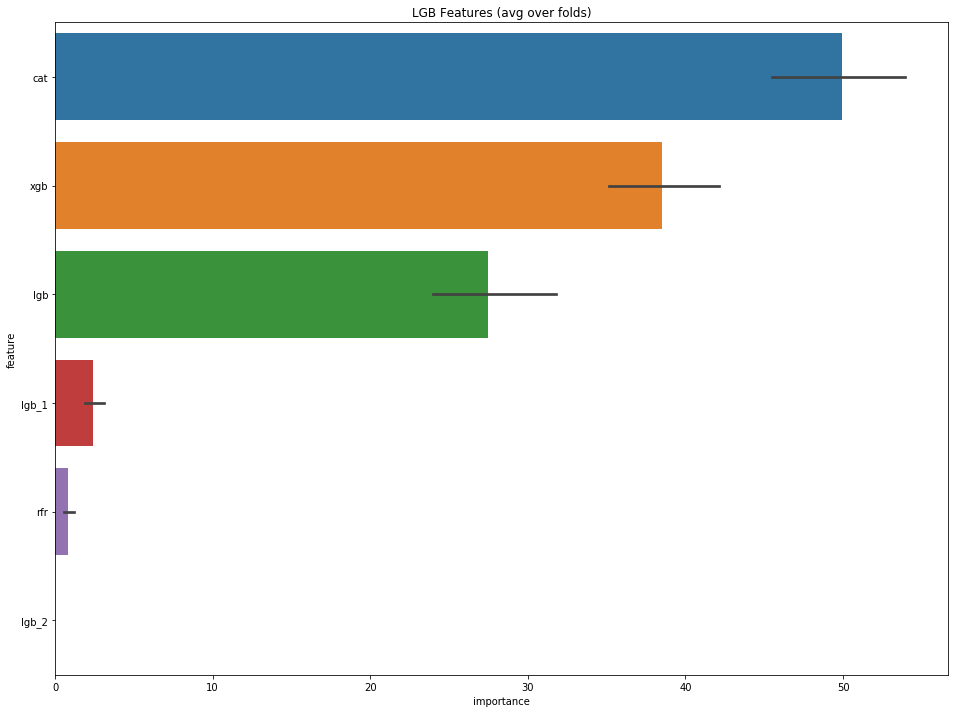

In [37]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 00:19:32 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00589349	valid_1's rmse: 0.00245621
[2000]	training's rmse: 0.00589036	valid_1's rmse: 0.00245399
Early stopping, best iteration is:
[2525]	training's rmse: 0.00589036	valid_1's rmse: 0.00245399
Fold 1 started at Tue Dec 17 00:19:40 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00589836	valid_1's rmse: 0.00389688
[2000]	training's rmse: 0.00589506	valid_1's rmse: 0.00389355
[3000]	training's rmse: 0.00589506	valid_1's rmse: 0.00389355
Early stopping, best iteration is:
[3730]	training's rmse: 0.00589506	valid_1's rmse: 0.00389355
Fold 2 started at Tue Dec 17 00:19:51 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00582524	valid_1's rmse: 0.00430938
[2000]	training's rmse: 0.00582164	valid_1's rmse: 0.00430667
[3000]	training's rmse: 0.00582164	valid_1's rmse: 0.0

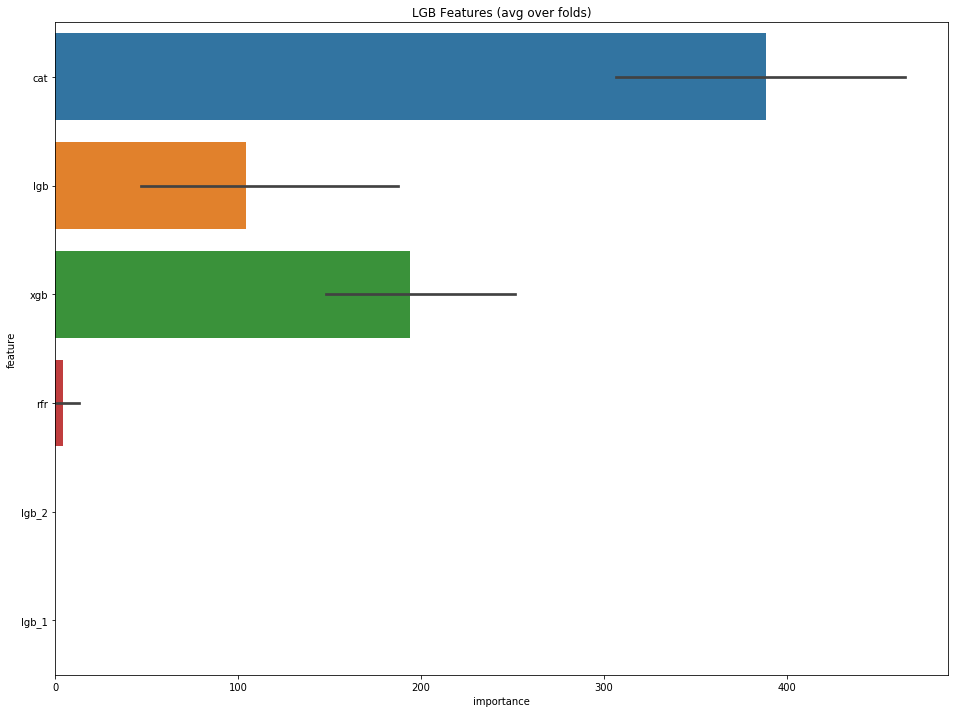

In [38]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [39]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 00:21:57 2019
Fold 1 started at Tue Dec 17 00:22:09 2019
Fold 2 started at Tue Dec 17 00:23:19 2019
Fold 3 started at Tue Dec 17 00:23:29 2019
Fold 4 started at Tue Dec 17 00:25:05 2019
Fold 5 started at Tue Dec 17 00:26:04 2019
Fold 6 started at Tue Dec 17 00:26:16 2019
Fold 7 started at Tue Dec 17 00:26:20 2019
Fold 8 started at Tue Dec 17 00:26:36 2019
Fold 9 started at Tue Dec 17 00:26:49 2019
CV mean score: 0.0033, std: 0.0023.


##### randomforest作为第二层融合模型

In [40]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 00:26:53 2019
Fold 1 started at Tue Dec 17 00:26:53 2019
Fold 2 started at Tue Dec 17 00:26:54 2019
Fold 3 started at Tue Dec 17 00:26:54 2019
Fold 4 started at Tue Dec 17 00:26:54 2019
Fold 5 started at Tue Dec 17 00:26:54 2019
Fold 6 started at Tue Dec 17 00:26:54 2019
Fold 7 started at Tue Dec 17 00:26:55 2019
Fold 8 started at Tue Dec 17 00:26:55 2019
Fold 9 started at Tue Dec 17 00:26:55 2019
CV mean score: 0.0040, std: 0.0025.


##### xgboost作为第二层融合模型

In [41]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 00:26:55 2019
[0]	train-rmse:0.550137	valid_data-rmse:0.552468
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.004977	valid_data-rmse:0.004267
Stopping. Best iteration:
[654]	train-rmse:0.002082	valid_data-rmse:0.002004

Fold 1 started at Tue Dec 17 00:26:56 2019
[0]	train-rmse:0.550162	valid_data-rmse:0.55234
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.005012	valid_data-rmse:0.004212
[1000]	train-rmse:0.000821	valid_data-rmse:0.001356
[1500]	train-rmse:0.000676	valid_data-rmse:0.001355
Stopping. Best iteration:
[1302]	train-rmse:0.000701	valid_data-rmse:0.00135

Fold 2 started at Tue Dec 17 00:26:56 2019
[0]	train-rmse:0.550262	valid_data-rmse:0.551404
Multiple eval metrics have been passed: 'valid_data

##### svr 作为第二层融合模型

In [42]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 00:26:59 2019
Fold 1 started at Tue Dec 17 00:26:59 2019
Fold 2 started at Tue Dec 17 00:26:59 2019
Fold 3 started at Tue Dec 17 00:26:59 2019
Fold 4 started at Tue Dec 17 00:26:59 2019
Fold 5 started at Tue Dec 17 00:26:59 2019
Fold 6 started at Tue Dec 17 00:26:59 2019
Fold 7 started at Tue Dec 17 00:26:59 2019
Fold 8 started at Tue Dec 17 00:26:59 2019
Fold 9 started at Tue Dec 17 00:26:59 2019
CV mean score: 0.0197, std: 0.0037.


##### 岭回归做第二层融合模型

In [43]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 00:26:59 2019
Fold 1 started at Tue Dec 17 00:26:59 2019
Fold 2 started at Tue Dec 17 00:26:59 2019
Fold 3 started at Tue Dec 17 00:26:59 2019
Fold 4 started at Tue Dec 17 00:26:59 2019
Fold 5 started at Tue Dec 17 00:26:59 2019
Fold 6 started at Tue Dec 17 00:26:59 2019
Fold 7 started at Tue Dec 17 00:26:59 2019
Fold 8 started at Tue Dec 17 00:27:00 2019
Fold 9 started at Tue Dec 17 00:27:00 2019
CV mean score: 0.0036, std: 0.0026.


#### 去掉rfr的结果

In [44]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2','svr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 00:27:00 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[551]	training's rmse: 0.0061662	valid_1's rmse: 0.00268902
Fold 1 started at Tue Dec 17 00:27:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[575]	training's rmse: 0.00615112	valid_1's rmse: 0.00413807
Fold 2 started at Tue Dec 17 00:27:04 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[507]	training's rmse: 0.00616452	valid_1's rmse: 0.00459749
Fold 3 started at Tue Dec 17 00:27:07 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[564]	training's rmse: 0.00570579	valid_1's rmse: 0.0109467
Fold 4 started at Tue Dec 17 00:27:09 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[529]	training's rmse: 0.00540749	valid_1's rmse: 0.0

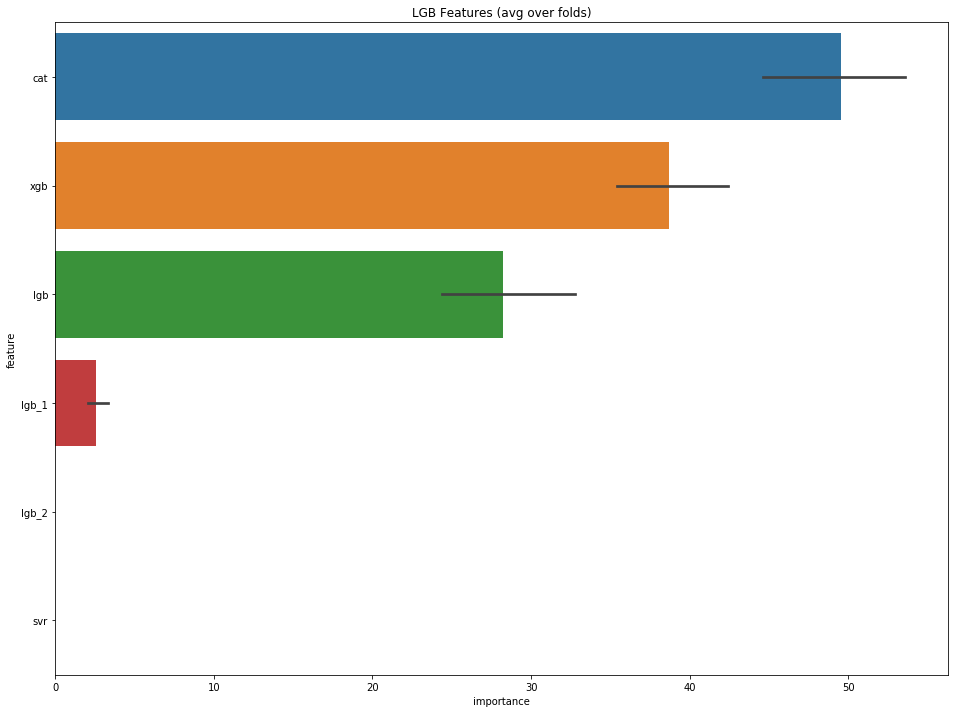

In [45]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 00:27:24 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00589349	valid_1's rmse: 0.00245621
[2000]	training's rmse: 0.00589036	valid_1's rmse: 0.00245399
Early stopping, best iteration is:
[2525]	training's rmse: 0.00589036	valid_1's rmse: 0.00245399
Fold 1 started at Tue Dec 17 00:27:33 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00589836	valid_1's rmse: 0.00389688
[2000]	training's rmse: 0.00589506	valid_1's rmse: 0.00389355
[3000]	training's rmse: 0.00589506	valid_1's rmse: 0.00389355
Early stopping, best iteration is:
[3730]	training's rmse: 0.00589506	valid_1's rmse: 0.00389355
Fold 2 started at Tue Dec 17 00:27:44 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00582524	valid_1's rmse: 0.00430938
[2000]	training's rmse: 0.00582164	valid_1's rmse: 0.00430667
[3000]	training's rmse: 0.00582164	valid_1's rmse: 0.0

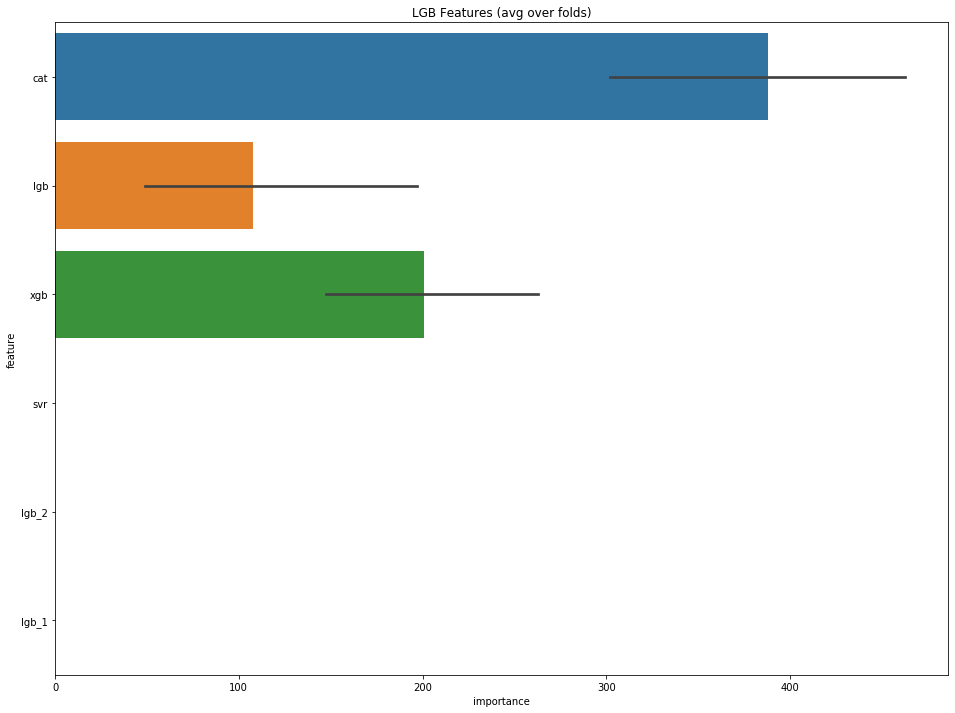

In [46]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [47]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 00:29:27 2019
Fold 1 started at Tue Dec 17 00:30:09 2019
Fold 2 started at Tue Dec 17 00:30:35 2019
Fold 3 started at Tue Dec 17 00:30:43 2019
Fold 4 started at Tue Dec 17 00:31:16 2019
Fold 5 started at Tue Dec 17 00:31:41 2019
Fold 6 started at Tue Dec 17 00:31:44 2019
Fold 7 started at Tue Dec 17 00:31:46 2019
Fold 8 started at Tue Dec 17 00:31:55 2019
Fold 9 started at Tue Dec 17 00:32:05 2019
CV mean score: 0.0032, std: 0.0023.


##### randomforest作为第二层融合模型

In [48]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 00:32:09 2019
Fold 1 started at Tue Dec 17 00:32:09 2019
Fold 2 started at Tue Dec 17 00:32:09 2019
Fold 3 started at Tue Dec 17 00:32:09 2019
Fold 4 started at Tue Dec 17 00:32:10 2019
Fold 5 started at Tue Dec 17 00:32:10 2019
Fold 6 started at Tue Dec 17 00:32:10 2019
Fold 7 started at Tue Dec 17 00:32:10 2019
Fold 8 started at Tue Dec 17 00:32:11 2019
Fold 9 started at Tue Dec 17 00:32:11 2019
CV mean score: 0.0039, std: 0.0026.


##### xgboost作为第二层融合模型

In [49]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 00:32:11 2019
[0]	train-rmse:0.550137	valid_data-rmse:0.552468
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.004973	valid_data-rmse:0.004276
[1000]	train-rmse:0.000894	valid_data-rmse:0.00116
Stopping. Best iteration:
[980]	train-rmse:0.00091	valid_data-rmse:0.001157

Fold 1 started at Tue Dec 17 00:32:12 2019
[0]	train-rmse:0.550162	valid_data-rmse:0.55234
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.004997	valid_data-rmse:0.004189
[1000]	train-rmse:0.000864	valid_data-rmse:0.001396
Stopping. Best iteration:
[969]	train-rmse:0.000889	valid_data-rmse:0.001395

Fold 2 started at Tue Dec 17 00:32:12 2019
[0]	train-rmse:0.550262	valid_data-rmse:0.551404
Multiple eval metrics have been passed: 'valid_data-r

##### svr 作为第二层融合模型

In [50]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 00:32:14 2019
Fold 1 started at Tue Dec 17 00:32:14 2019
Fold 2 started at Tue Dec 17 00:32:14 2019
Fold 3 started at Tue Dec 17 00:32:14 2019
Fold 4 started at Tue Dec 17 00:32:14 2019
Fold 5 started at Tue Dec 17 00:32:14 2019
Fold 6 started at Tue Dec 17 00:32:14 2019
Fold 7 started at Tue Dec 17 00:32:14 2019
Fold 8 started at Tue Dec 17 00:32:14 2019
Fold 9 started at Tue Dec 17 00:32:14 2019
CV mean score: 0.0197, std: 0.0037.


##### 岭回归做第二层融合模型

In [51]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 00:32:14 2019
Fold 1 started at Tue Dec 17 00:32:14 2019
Fold 2 started at Tue Dec 17 00:32:15 2019
Fold 3 started at Tue Dec 17 00:32:15 2019
Fold 4 started at Tue Dec 17 00:32:15 2019
Fold 5 started at Tue Dec 17 00:32:15 2019
Fold 6 started at Tue Dec 17 00:32:15 2019
Fold 7 started at Tue Dec 17 00:32:15 2019
Fold 8 started at Tue Dec 17 00:32:15 2019
Fold 9 started at Tue Dec 17 00:32:15 2019
CV mean score: 0.0035, std: 0.0025.


#### 去掉catboost的结果

In [52]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_lgb_1, oof_lgb_2,oof_svr,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb',  'lgb_1', 'lgb_2','svr','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 00:32:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[551]	training's rmse: 0.00623674	valid_1's rmse: 0.00304834
Fold 1 started at Tue Dec 17 00:32:17 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[575]	training's rmse: 0.00622826	valid_1's rmse: 0.00429688
Fold 2 started at Tue Dec 17 00:32:19 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[506]	training's rmse: 0.00622525	valid_1's rmse: 0.00489556
Fold 3 started at Tue Dec 17 00:32:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[539]	training's rmse: 0.00581125	valid_1's rmse: 0.0109767
Fold 4 started at Tue Dec 17 00:32:22 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[529]	training's rmse: 0.00541852	valid_1's rmse: 0.

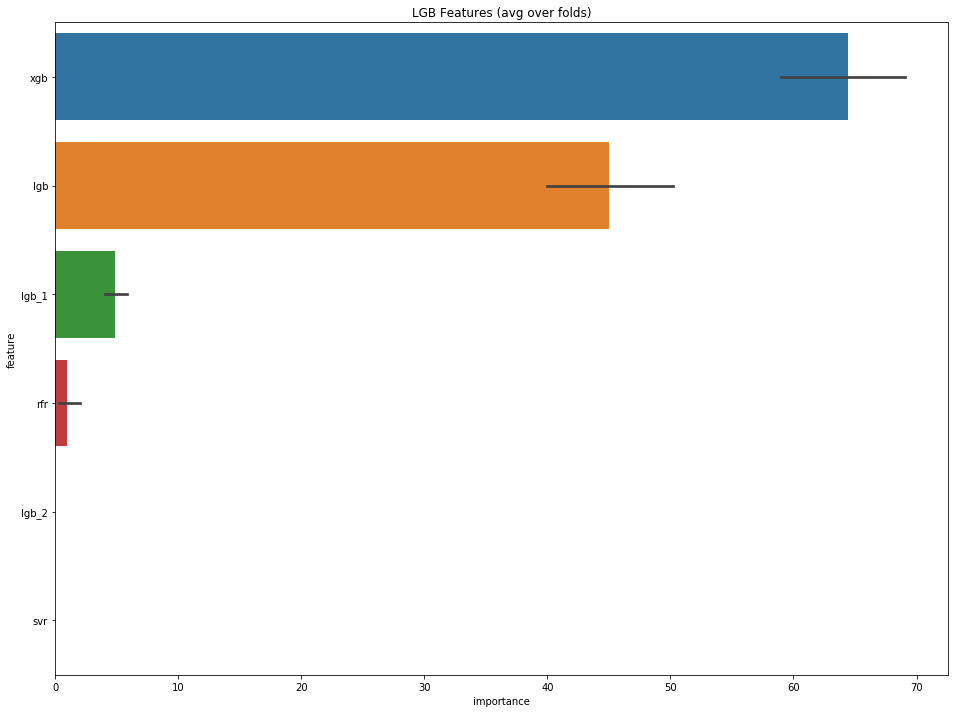

In [53]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 00:32:34 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0059948	valid_1's rmse: 0.0029194
[2000]	training's rmse: 0.00599193	valid_1's rmse: 0.00291763
[3000]	training's rmse: 0.00599193	valid_1's rmse: 0.00291763
[4000]	training's rmse: 0.00599193	valid_1's rmse: 0.00291763
Early stopping, best iteration is:
[4207]	training's rmse: 0.00599193	valid_1's rmse: 0.00291763
Fold 1 started at Tue Dec 17 00:32:43 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00599347	valid_1's rmse: 0.00410339
[2000]	training's rmse: 0.0059901	valid_1's rmse: 0.00410005
[3000]	training's rmse: 0.0059901	valid_1's rmse: 0.00410005
[4000]	training's rmse: 0.0059901	valid_1's rmse: 0.00410005
[5000]	training's rmse: 0.0059901	valid_1's rmse: 0.00410005
[6000]	training's rmse: 0.0059901	valid_1's rmse: 0.00410005
Early stopping, best iteration is:
[5967]	training's rmse: 0.0059901	valid_1's

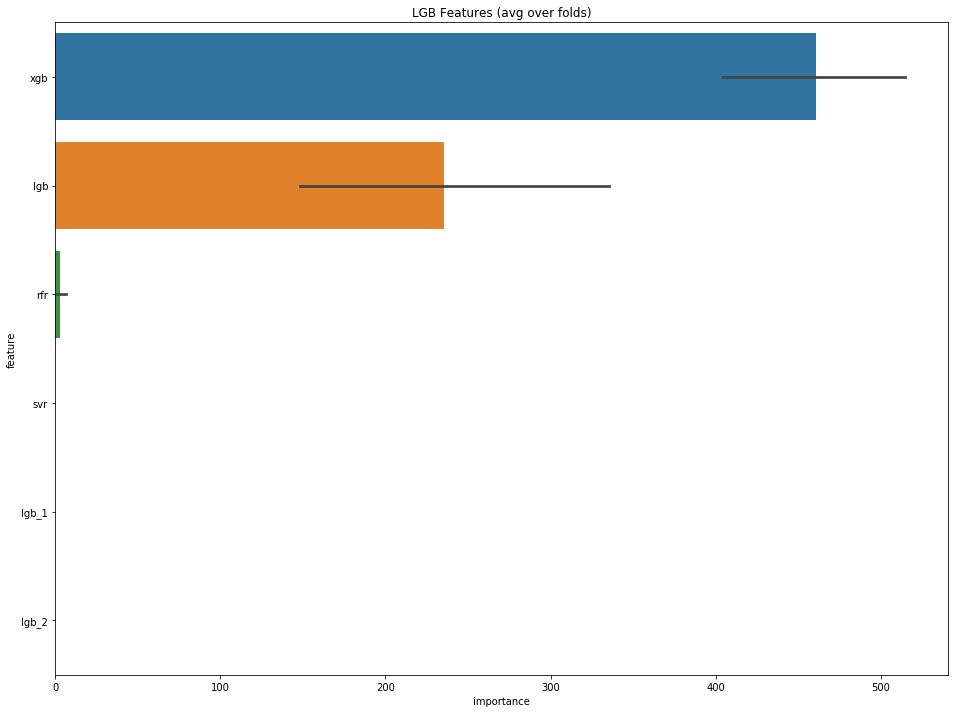

In [54]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [55]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 00:34:00 2019
Fold 1 started at Tue Dec 17 00:34:06 2019
Fold 2 started at Tue Dec 17 00:34:38 2019
Fold 3 started at Tue Dec 17 00:34:42 2019
Fold 4 started at Tue Dec 17 00:35:15 2019
Fold 5 started at Tue Dec 17 00:35:38 2019
Fold 6 started at Tue Dec 17 00:35:42 2019
Fold 7 started at Tue Dec 17 00:35:44 2019
Fold 8 started at Tue Dec 17 00:35:54 2019
Fold 9 started at Tue Dec 17 00:36:00 2019
CV mean score: 0.0035, std: 0.0023.


##### randomforest作为第二层融合模型

In [56]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 00:36:03 2019
Fold 1 started at Tue Dec 17 00:36:04 2019
Fold 2 started at Tue Dec 17 00:36:04 2019
Fold 3 started at Tue Dec 17 00:36:04 2019
Fold 4 started at Tue Dec 17 00:36:04 2019
Fold 5 started at Tue Dec 17 00:36:05 2019
Fold 6 started at Tue Dec 17 00:36:05 2019
Fold 7 started at Tue Dec 17 00:36:05 2019
Fold 8 started at Tue Dec 17 00:36:05 2019
Fold 9 started at Tue Dec 17 00:36:06 2019
CV mean score: 0.0043, std: 0.0026.


##### xgboost作为第二层融合模型

In [57]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 00:36:06 2019
[0]	train-rmse:0.550137	valid_data-rmse:0.552468
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.005074	valid_data-rmse:0.004229
Stopping. Best iteration:
[684]	train-rmse:0.001927	valid_data-rmse:0.002154

Fold 1 started at Tue Dec 17 00:36:06 2019
[0]	train-rmse:0.550162	valid_data-rmse:0.55234
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.005071	valid_data-rmse:0.004066
[1000]	train-rmse:0.000863	valid_data-rmse:0.00151
[1500]	train-rmse:0.000708	valid_data-rmse:0.001497
[2000]	train-rmse:0.000674	valid_data-rmse:0.001487
Stopping. Best iteration:
[1935]	train-rmse:0.000677	valid_data-rmse:0.001486

Fold 2 started at Tue Dec 17 00:36:07 2019
[0]	train-rmse:0.550262	valid_data-rmse:0.551404

##### svr 作为第二层融合模型

In [58]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 00:36:10 2019
Fold 1 started at Tue Dec 17 00:36:10 2019
Fold 2 started at Tue Dec 17 00:36:10 2019
Fold 3 started at Tue Dec 17 00:36:10 2019
Fold 4 started at Tue Dec 17 00:36:10 2019
Fold 5 started at Tue Dec 17 00:36:10 2019
Fold 6 started at Tue Dec 17 00:36:10 2019
Fold 7 started at Tue Dec 17 00:36:10 2019
Fold 8 started at Tue Dec 17 00:36:10 2019
Fold 9 started at Tue Dec 17 00:36:10 2019
CV mean score: 0.0197, std: 0.0037.


##### 岭回归做第二层融合模型

In [59]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 00:36:10 2019
Fold 1 started at Tue Dec 17 00:36:10 2019
Fold 2 started at Tue Dec 17 00:36:10 2019
Fold 3 started at Tue Dec 17 00:36:10 2019
Fold 4 started at Tue Dec 17 00:36:10 2019
Fold 5 started at Tue Dec 17 00:36:10 2019
Fold 6 started at Tue Dec 17 00:36:10 2019
Fold 7 started at Tue Dec 17 00:36:10 2019
Fold 8 started at Tue Dec 17 00:36:10 2019
Fold 9 started at Tue Dec 17 00:36:10 2019
CV mean score: 0.0040, std: 0.0026.


#### 去掉xgb和lgb的结果

In [60]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_cat, oof_svr,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=[ 'cat', 'svr','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 00:36:11 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[646]	training's rmse: 0.00635743	valid_1's rmse: 0.00297707
Fold 1 started at Tue Dec 17 00:36:13 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[637]	training's rmse: 0.00636569	valid_1's rmse: 0.00426016
Fold 2 started at Tue Dec 17 00:36:14 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[644]	training's rmse: 0.00631122	valid_1's rmse: 0.00473083
Fold 3 started at Tue Dec 17 00:36:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[692]	training's rmse: 0.00584849	valid_1's rmse: 0.0109547
Fold 4 started at Tue Dec 17 00:36:18 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[617]	training's rmse: 0.00557215	valid_1's rmse: 0.

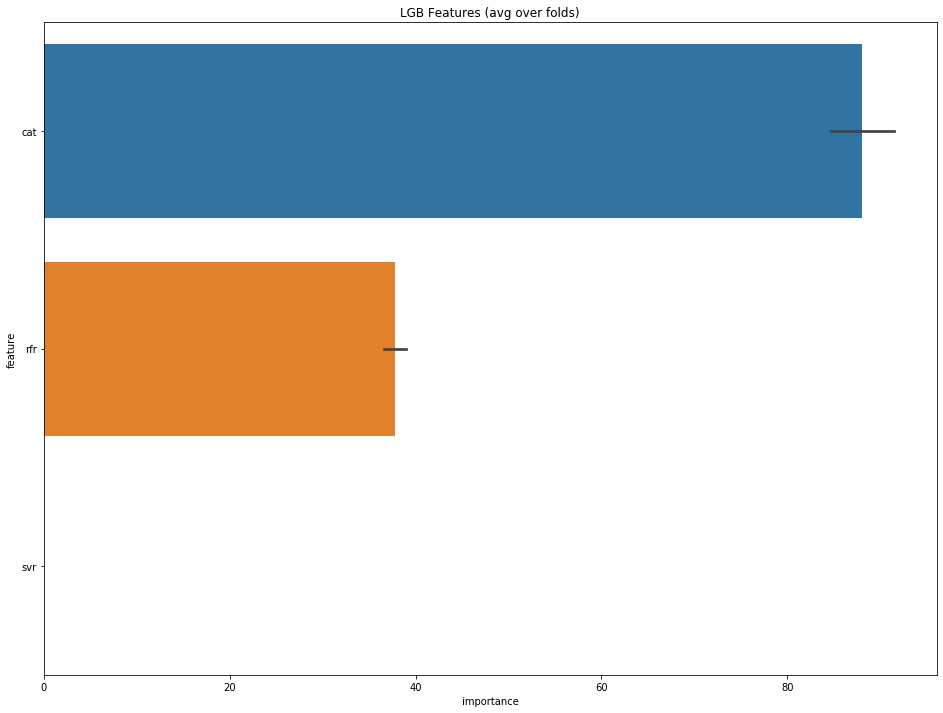

In [61]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 00:36:30 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00595873	valid_1's rmse: 0.00251597
[2000]	training's rmse: 0.00595491	valid_1's rmse: 0.00251386
Early stopping, best iteration is:
[2518]	training's rmse: 0.00595491	valid_1's rmse: 0.00251386
Fold 1 started at Tue Dec 17 00:36:36 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0059541	valid_1's rmse: 0.00387005
[2000]	training's rmse: 0.00595021	valid_1's rmse: 0.00386636
[3000]	training's rmse: 0.00595021	valid_1's rmse: 0.00386635
[4000]	training's rmse: 0.00595021	valid_1's rmse: 0.00386635
Early stopping, best iteration is:
[4052]	training's rmse: 0.00595021	valid_1's rmse: 0.00386635
Fold 2 started at Tue Dec 17 00:36:45 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00590507	valid_1's rmse: 0.00431765
[2000]	training's rmse: 0.00590116	valid_1's rmse: 0.00

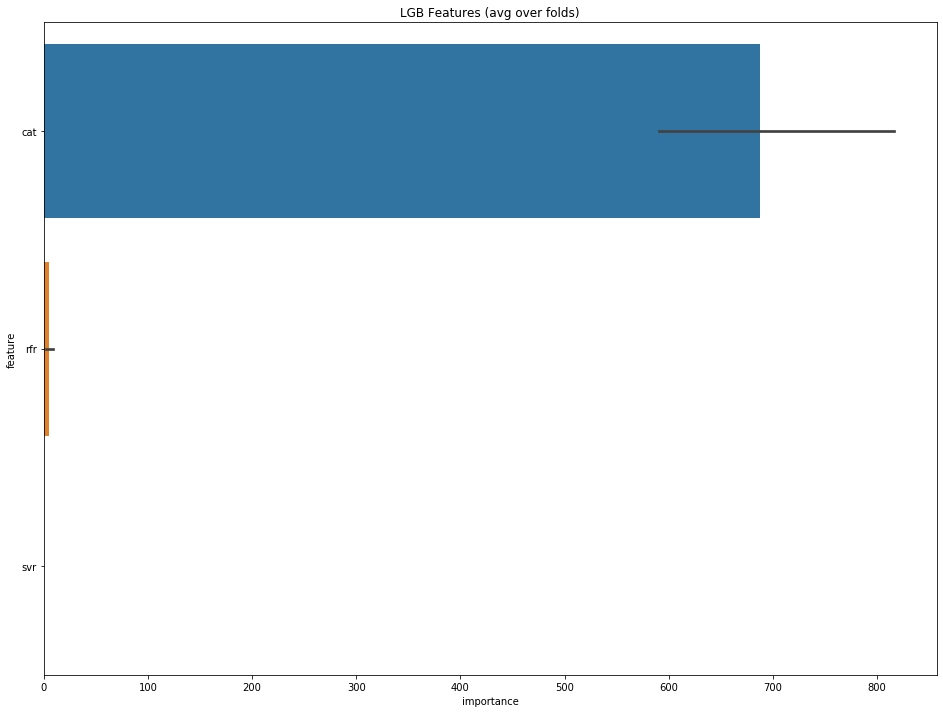

In [62]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [63]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 00:37:54 2019
Fold 1 started at Tue Dec 17 00:38:01 2019
Fold 2 started at Tue Dec 17 00:38:11 2019
Fold 3 started at Tue Dec 17 00:38:19 2019
Fold 4 started at Tue Dec 17 00:39:03 2019
Fold 5 started at Tue Dec 17 00:39:45 2019
Fold 6 started at Tue Dec 17 00:39:51 2019
Fold 7 started at Tue Dec 17 00:39:53 2019
Fold 8 started at Tue Dec 17 00:40:05 2019
Fold 9 started at Tue Dec 17 00:40:48 2019
CV mean score: 0.0037, std: 0.0023.


##### randomforest作为第二层融合模型

In [64]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 00:40:52 2019
Fold 1 started at Tue Dec 17 00:40:53 2019
Fold 2 started at Tue Dec 17 00:40:53 2019
Fold 3 started at Tue Dec 17 00:40:53 2019
Fold 4 started at Tue Dec 17 00:40:53 2019
Fold 5 started at Tue Dec 17 00:40:54 2019
Fold 6 started at Tue Dec 17 00:40:54 2019
Fold 7 started at Tue Dec 17 00:40:54 2019
Fold 8 started at Tue Dec 17 00:40:54 2019
Fold 9 started at Tue Dec 17 00:40:55 2019
CV mean score: 0.0046, std: 0.0024.


##### xgboost作为第二层融合模型

In [65]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 00:40:55 2019
[0]	train-rmse:0.550137	valid_data-rmse:0.552468
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.005232	valid_data-rmse:0.005032
[1000]	train-rmse:0.000987	valid_data-rmse:0.001934
Stopping. Best iteration:
[1077]	train-rmse:0.000893	valid_data-rmse:0.001925

Fold 1 started at Tue Dec 17 00:40:55 2019
[0]	train-rmse:0.550162	valid_data-rmse:0.55234
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.005244	valid_data-rmse:0.004505
[1000]	train-rmse:0.000965	valid_data-rmse:0.00157
[1500]	train-rmse:0.000745	valid_data-rmse:0.001535
[2000]	train-rmse:0.000707	valid_data-rmse:0.001526
Stopping. Best iteration:
[1841]	train-rmse:0.000714	valid_data-rmse:0.001525

Fold 2 started at Tue Dec 17 00:40:56 

##### svr 作为第二层融合模型

In [66]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 00:40:59 2019
Fold 1 started at Tue Dec 17 00:40:59 2019
Fold 2 started at Tue Dec 17 00:40:59 2019
Fold 3 started at Tue Dec 17 00:40:59 2019
Fold 4 started at Tue Dec 17 00:40:59 2019
Fold 5 started at Tue Dec 17 00:40:59 2019
Fold 6 started at Tue Dec 17 00:40:59 2019
Fold 7 started at Tue Dec 17 00:40:59 2019
Fold 8 started at Tue Dec 17 00:40:59 2019
Fold 9 started at Tue Dec 17 00:40:59 2019
CV mean score: 0.0197, std: 0.0037.


##### 岭回归做第二层融合模型

In [67]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 00:40:59 2019
Fold 1 started at Tue Dec 17 00:40:59 2019
Fold 2 started at Tue Dec 17 00:40:59 2019
Fold 3 started at Tue Dec 17 00:40:59 2019
Fold 4 started at Tue Dec 17 00:40:59 2019
Fold 5 started at Tue Dec 17 00:40:59 2019
Fold 6 started at Tue Dec 17 00:40:59 2019
Fold 7 started at Tue Dec 17 00:41:00 2019
Fold 8 started at Tue Dec 17 00:41:00 2019
Fold 9 started at Tue Dec 17 00:41:00 2019
CV mean score: 0.0041, std: 0.0024.


#### 去掉lgb和svr的结果

In [68]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_xgb, oof_cat, oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['xgb', 'cat','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 00:41:00 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[551]	training's rmse: 0.00619148	valid_1's rmse: 0.00273027
Fold 1 started at Tue Dec 17 00:41:01 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[575]	training's rmse: 0.00617047	valid_1's rmse: 0.00417804
Fold 2 started at Tue Dec 17 00:41:03 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[507]	training's rmse: 0.0061814	valid_1's rmse: 0.00464214
Fold 3 started at Tue Dec 17 00:41:04 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[564]	training's rmse: 0.00571397	valid_1's rmse: 0.0109663
Fold 4 started at Tue Dec 17 00:41:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[610]	training's rmse: 0.00537641	valid_1's rmse: 0.0

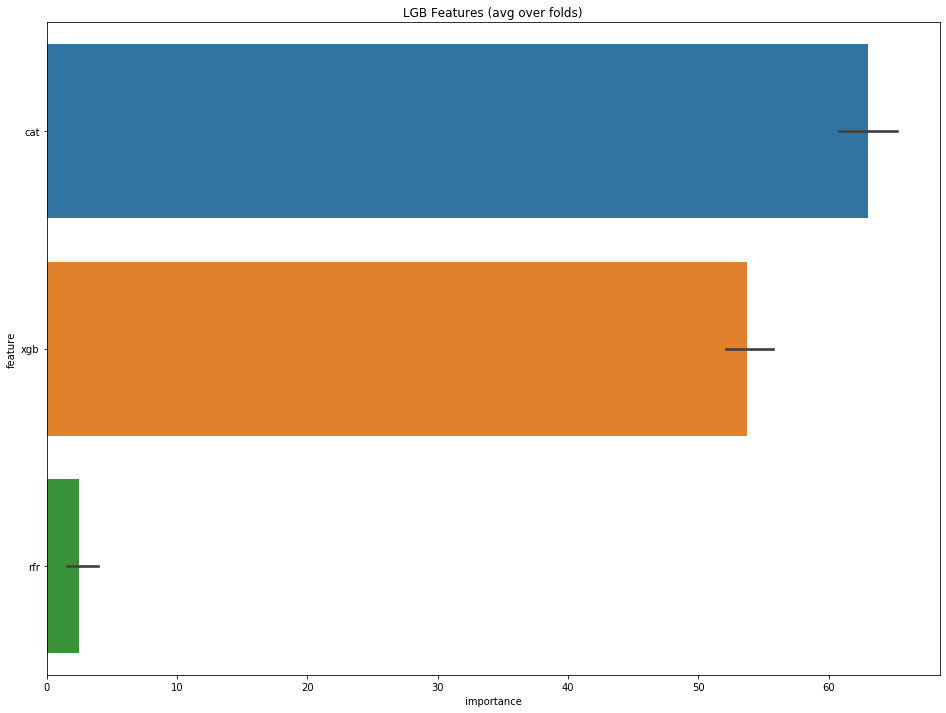

In [69]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 00:41:15 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00590565	valid_1's rmse: 0.00248225
[2000]	training's rmse: 0.00590252	valid_1's rmse: 0.00247993
[3000]	training's rmse: 0.00590252	valid_1's rmse: 0.00247993
Early stopping, best iteration is:
[3141]	training's rmse: 0.00590252	valid_1's rmse: 0.00247993
Fold 1 started at Tue Dec 17 00:41:20 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00590099	valid_1's rmse: 0.00393527
[2000]	training's rmse: 0.0058977	valid_1's rmse: 0.00393208
[3000]	training's rmse: 0.0058977	valid_1's rmse: 0.00393208
Early stopping, best iteration is:
[3712]	training's rmse: 0.0058977	valid_1's rmse: 0.00393208
Fold 2 started at Tue Dec 17 00:41:27 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00583174	valid_1's rmse: 0.00433727
[2000]	training's rmse: 0.00582815	valid_1's rmse: 0.0043

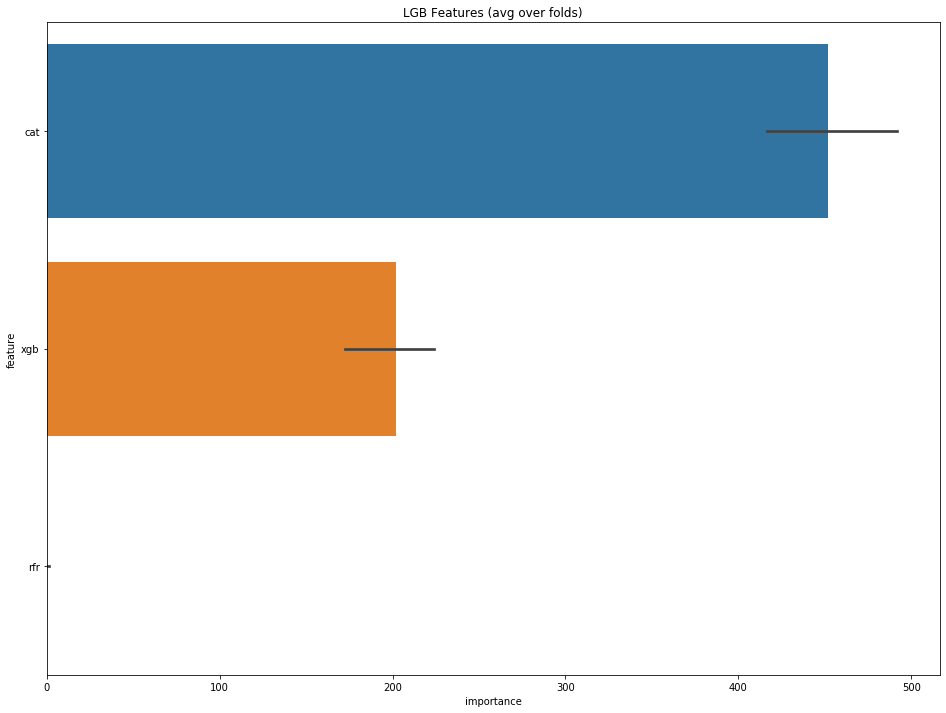

In [70]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [71]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 00:42:21 2019
Fold 1 started at Tue Dec 17 00:42:29 2019
Fold 2 started at Tue Dec 17 00:43:09 2019
Fold 3 started at Tue Dec 17 00:43:13 2019
Fold 4 started at Tue Dec 17 00:43:42 2019
Fold 5 started at Tue Dec 17 00:44:07 2019
Fold 6 started at Tue Dec 17 00:44:21 2019
Fold 7 started at Tue Dec 17 00:44:24 2019
Fold 8 started at Tue Dec 17 00:44:33 2019
Fold 9 started at Tue Dec 17 00:44:43 2019
CV mean score: 0.0034, std: 0.0024.


##### randomforest作为第二层融合模型

In [72]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 00:44:45 2019
Fold 1 started at Tue Dec 17 00:44:46 2019
Fold 2 started at Tue Dec 17 00:44:46 2019
Fold 3 started at Tue Dec 17 00:44:46 2019
Fold 4 started at Tue Dec 17 00:44:46 2019
Fold 5 started at Tue Dec 17 00:44:46 2019
Fold 6 started at Tue Dec 17 00:44:47 2019
Fold 7 started at Tue Dec 17 00:44:47 2019
Fold 8 started at Tue Dec 17 00:44:47 2019
Fold 9 started at Tue Dec 17 00:44:47 2019
CV mean score: 0.0039, std: 0.0025.


##### xgboost作为第二层融合模型

In [73]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 00:44:48 2019
[0]	train-rmse:0.550137	valid_data-rmse:0.552468
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.00499	valid_data-rmse:0.004562
[1000]	train-rmse:0.000838	valid_data-rmse:0.00183
Stopping. Best iteration:
[822]	train-rmse:0.001137	valid_data-rmse:0.001805

Fold 1 started at Tue Dec 17 00:44:48 2019
[0]	train-rmse:0.550162	valid_data-rmse:0.55234
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.00502	valid_data-rmse:0.004183
[1000]	train-rmse:0.000836	valid_data-rmse:0.00127
[1500]	train-rmse:0.000702	valid_data-rmse:0.001254
Stopping. Best iteration:
[1445]	train-rmse:0.000708	valid_data-rmse:0.001254

Fold 2 started at Tue Dec 17 00:44:48 2019
[0]	train-rmse:0.550262	valid_data-rmse:0.551404
Mu

##### svr 作为第二层融合模型

In [74]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 00:44:50 2019
Fold 1 started at Tue Dec 17 00:44:50 2019
Fold 2 started at Tue Dec 17 00:44:50 2019
Fold 3 started at Tue Dec 17 00:44:50 2019
Fold 4 started at Tue Dec 17 00:44:50 2019
Fold 5 started at Tue Dec 17 00:44:50 2019
Fold 6 started at Tue Dec 17 00:44:50 2019
Fold 7 started at Tue Dec 17 00:44:50 2019
Fold 8 started at Tue Dec 17 00:44:50 2019
Fold 9 started at Tue Dec 17 00:44:50 2019
CV mean score: 0.0197, std: 0.0037.


##### 岭回归做第二层融合模型

In [75]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 00:44:50 2019
Fold 1 started at Tue Dec 17 00:44:50 2019
Fold 2 started at Tue Dec 17 00:44:51 2019
Fold 3 started at Tue Dec 17 00:44:51 2019
Fold 4 started at Tue Dec 17 00:44:51 2019
Fold 5 started at Tue Dec 17 00:44:51 2019
Fold 6 started at Tue Dec 17 00:44:51 2019
Fold 7 started at Tue Dec 17 00:44:51 2019
Fold 8 started at Tue Dec 17 00:44:51 2019
Fold 9 started at Tue Dec 17 00:44:51 2019
CV mean score: 0.0034, std: 0.0025.


#### 去掉lgb和rfr的结果

In [77]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_xgb, oof_cat, oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['xgb', 'cat', 'svr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 01:10:54 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[551]	training's rmse: 0.00619206	valid_1's rmse: 0.00273289
Fold 1 started at Tue Dec 17 01:10:57 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[575]	training's rmse: 0.00617035	valid_1's rmse: 0.00417663
Fold 2 started at Tue Dec 17 01:11:00 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[507]	training's rmse: 0.00618162	valid_1's rmse: 0.00464122
Fold 3 started at Tue Dec 17 01:11:03 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[564]	training's rmse: 0.00571361	valid_1's rmse: 0.0109652
Fold 4 started at Tue Dec 17 01:11:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[610]	training's rmse: 0.00537808	valid_1's rmse: 0.

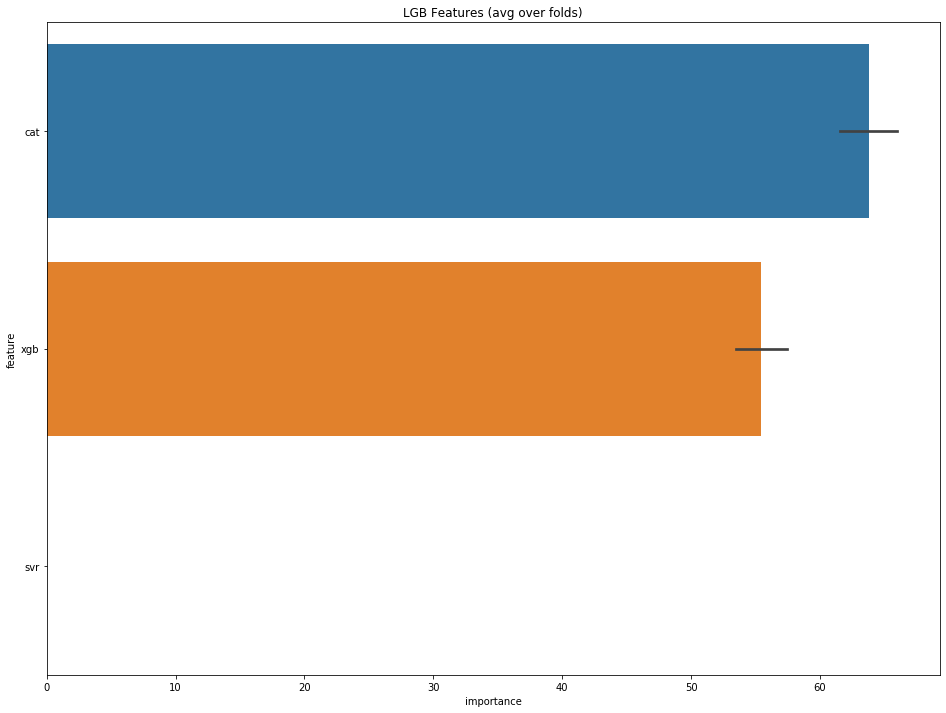

In [78]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 01:11:25 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00590565	valid_1's rmse: 0.00248225
[2000]	training's rmse: 0.00590252	valid_1's rmse: 0.00247993
[3000]	training's rmse: 0.00590252	valid_1's rmse: 0.00247993
Early stopping, best iteration is:
[3141]	training's rmse: 0.00590252	valid_1's rmse: 0.00247993
Fold 1 started at Tue Dec 17 01:11:38 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00590099	valid_1's rmse: 0.00393527
[2000]	training's rmse: 0.0058977	valid_1's rmse: 0.00393208
[3000]	training's rmse: 0.0058977	valid_1's rmse: 0.00393208
Early stopping, best iteration is:
[3712]	training's rmse: 0.0058977	valid_1's rmse: 0.00393208
Fold 2 started at Tue Dec 17 01:11:51 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00583174	valid_1's rmse: 0.00433727
[2000]	training's rmse: 0.00582815	valid_1's rmse: 0.0043

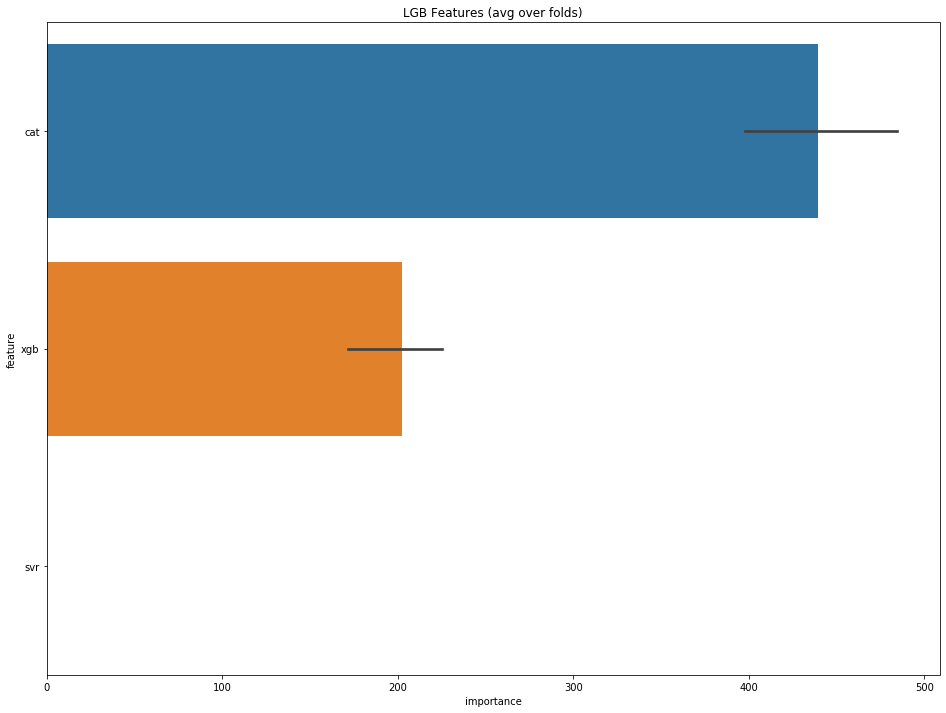

In [79]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [80]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 01:13:19 2019
Fold 1 started at Tue Dec 17 01:13:41 2019
Fold 2 started at Tue Dec 17 01:13:55 2019
Fold 3 started at Tue Dec 17 01:14:03 2019
Fold 4 started at Tue Dec 17 01:14:54 2019
Fold 5 started at Tue Dec 17 01:15:49 2019
Fold 6 started at Tue Dec 17 01:16:06 2019
Fold 7 started at Tue Dec 17 01:16:10 2019
Fold 8 started at Tue Dec 17 01:16:26 2019
Fold 9 started at Tue Dec 17 01:16:46 2019
CV mean score: 0.0030, std: 0.0024.


##### randomforest作为第二层融合模型

In [81]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 01:16:51 2019
Fold 1 started at Tue Dec 17 01:16:52 2019
Fold 2 started at Tue Dec 17 01:16:52 2019
Fold 3 started at Tue Dec 17 01:16:52 2019
Fold 4 started at Tue Dec 17 01:16:52 2019
Fold 5 started at Tue Dec 17 01:16:53 2019
Fold 6 started at Tue Dec 17 01:16:53 2019
Fold 7 started at Tue Dec 17 01:16:53 2019
Fold 8 started at Tue Dec 17 01:16:53 2019
Fold 9 started at Tue Dec 17 01:16:54 2019
CV mean score: 0.0035, std: 0.0025.


##### xgboost作为第二层融合模型

In [82]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 01:16:54 2019
[0]	train-rmse:0.550137	valid_data-rmse:0.552468
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.004989	valid_data-rmse:0.004592
Stopping. Best iteration:
[773]	train-rmse:0.001394	valid_data-rmse:0.001943

Fold 1 started at Tue Dec 17 01:16:54 2019
[0]	train-rmse:0.550162	valid_data-rmse:0.55234
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.005	valid_data-rmse:0.004177
[1000]	train-rmse:0.000907	valid_data-rmse:0.001517
Stopping. Best iteration:
[969]	train-rmse:0.000934	valid_data-rmse:0.001509

Fold 2 started at Tue Dec 17 01:16:54 2019
[0]	train-rmse:0.550262	valid_data-rmse:0.551404
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train unt

##### svr 作为第二层融合模型

In [83]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 01:16:57 2019
Fold 1 started at Tue Dec 17 01:16:57 2019
Fold 2 started at Tue Dec 17 01:16:57 2019
Fold 3 started at Tue Dec 17 01:16:57 2019
Fold 4 started at Tue Dec 17 01:16:57 2019
Fold 5 started at Tue Dec 17 01:16:57 2019
Fold 6 started at Tue Dec 17 01:16:57 2019
Fold 7 started at Tue Dec 17 01:16:57 2019
Fold 8 started at Tue Dec 17 01:16:57 2019
Fold 9 started at Tue Dec 17 01:16:57 2019
CV mean score: 0.0197, std: 0.0037.


##### 岭回归做第二层融合模型

In [84]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 01:16:57 2019
Fold 1 started at Tue Dec 17 01:16:57 2019
Fold 2 started at Tue Dec 17 01:16:57 2019
Fold 3 started at Tue Dec 17 01:16:57 2019
Fold 4 started at Tue Dec 17 01:16:57 2019
Fold 5 started at Tue Dec 17 01:16:57 2019
Fold 6 started at Tue Dec 17 01:16:57 2019
Fold 7 started at Tue Dec 17 01:16:57 2019
Fold 8 started at Tue Dec 17 01:16:57 2019
Fold 9 started at Tue Dec 17 01:16:58 2019
CV mean score: 0.0031, std: 0.0025.


#### 去掉lgb和cat的结果

In [85]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_xgb, oof_svr,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=[ 'xgb', 'svr','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 01:16:58 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[553]	training's rmse: 0.00641565	valid_1's rmse: 0.00322105
Fold 1 started at Tue Dec 17 01:16:59 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[582]	training's rmse: 0.00640408	valid_1's rmse: 0.00451875
Fold 2 started at Tue Dec 17 01:17:01 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[644]	training's rmse: 0.00627669	valid_1's rmse: 0.00495051
Fold 3 started at Tue Dec 17 01:17:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[540]	training's rmse: 0.00595316	valid_1's rmse: 0.0112008
Fold 4 started at Tue Dec 17 01:17:03 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[586]	training's rmse: 0.00554384	valid_1's rmse: 0.

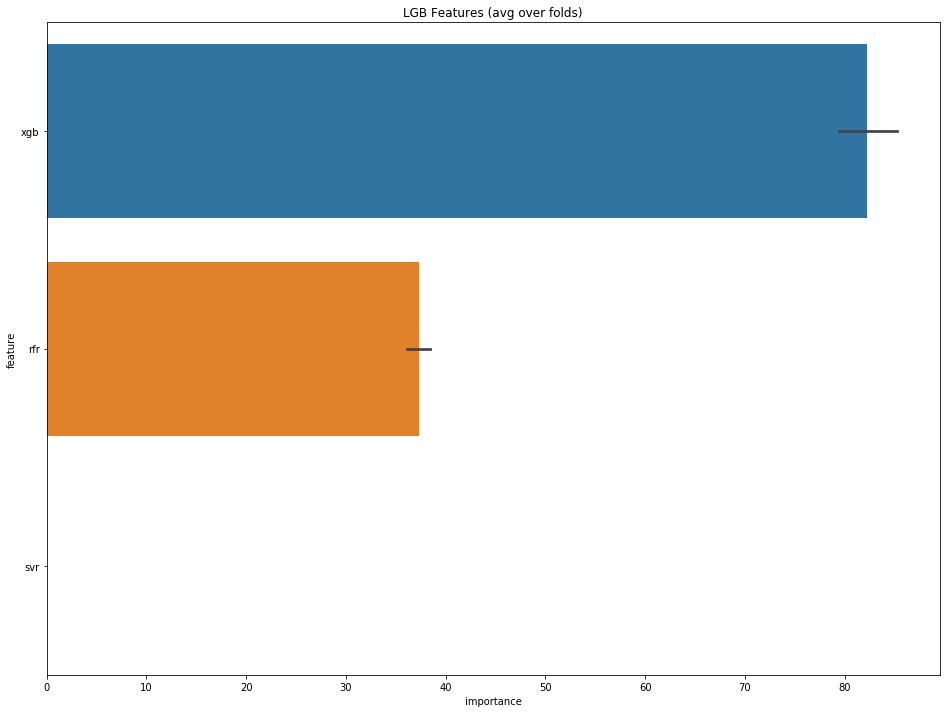

In [86]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 01:17:13 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00602688	valid_1's rmse: 0.00304076
[2000]	training's rmse: 0.00602391	valid_1's rmse: 0.00303917
Early stopping, best iteration is:
[2596]	training's rmse: 0.0060239	valid_1's rmse: 0.00303917
Fold 1 started at Tue Dec 17 01:17:18 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00604023	valid_1's rmse: 0.00415301
[2000]	training's rmse: 0.00603719	valid_1's rmse: 0.00415009
[3000]	training's rmse: 0.00603719	valid_1's rmse: 0.00415009
Early stopping, best iteration is:
[3569]	training's rmse: 0.00603719	valid_1's rmse: 0.00415009
Fold 2 started at Tue Dec 17 01:17:25 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00593512	valid_1's rmse: 0.00476781
[2000]	training's rmse: 0.00593183	valid_1's rmse: 0.00476564
Early stopping, best iteration is:
[2638]	training's rm

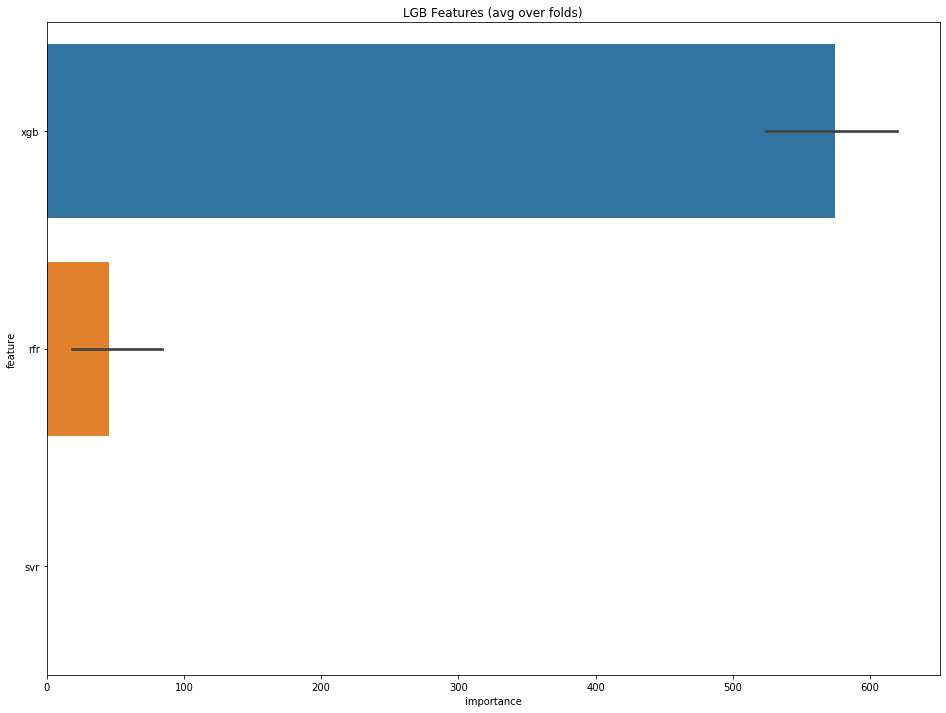

In [87]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [88]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 01:18:14 2019
Fold 1 started at Tue Dec 17 01:18:22 2019
Fold 2 started at Tue Dec 17 01:18:31 2019
Fold 3 started at Tue Dec 17 01:18:35 2019
Fold 4 started at Tue Dec 17 01:19:16 2019
Fold 5 started at Tue Dec 17 01:19:53 2019
Fold 6 started at Tue Dec 17 01:20:36 2019
Fold 7 started at Tue Dec 17 01:20:41 2019
Fold 8 started at Tue Dec 17 01:20:59 2019
Fold 9 started at Tue Dec 17 01:21:12 2019
CV mean score: 0.0037, std: 0.0023.


##### randomforest作为第二层融合模型

In [89]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 01:21:16 2019
Fold 1 started at Tue Dec 17 01:21:17 2019
Fold 2 started at Tue Dec 17 01:21:17 2019
Fold 3 started at Tue Dec 17 01:21:17 2019
Fold 4 started at Tue Dec 17 01:21:17 2019
Fold 5 started at Tue Dec 17 01:21:18 2019
Fold 6 started at Tue Dec 17 01:21:18 2019
Fold 7 started at Tue Dec 17 01:21:18 2019
Fold 8 started at Tue Dec 17 01:21:18 2019
Fold 9 started at Tue Dec 17 01:21:19 2019
CV mean score: 0.0045, std: 0.0024.


##### xgboost作为第二层融合模型

In [90]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 01:21:19 2019
[0]	train-rmse:0.550137	valid_data-rmse:0.552468
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.005242	valid_data-rmse:0.004672
Stopping. Best iteration:
[681]	train-rmse:0.002138	valid_data-rmse:0.002876

Fold 1 started at Tue Dec 17 01:21:19 2019
[0]	train-rmse:0.550162	valid_data-rmse:0.55234
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.005245	valid_data-rmse:0.004667
Stopping. Best iteration:
[774]	train-rmse:0.001578	valid_data-rmse:0.002673

Fold 2 started at Tue Dec 17 01:21:19 2019
[0]	train-rmse:0.550262	valid_data-rmse:0.551404
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.

##### svr 作为第二层融合模型

In [91]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 01:21:23 2019
Fold 1 started at Tue Dec 17 01:21:23 2019
Fold 2 started at Tue Dec 17 01:21:23 2019
Fold 3 started at Tue Dec 17 01:21:23 2019
Fold 4 started at Tue Dec 17 01:21:23 2019
Fold 5 started at Tue Dec 17 01:21:23 2019
Fold 6 started at Tue Dec 17 01:21:23 2019
Fold 7 started at Tue Dec 17 01:21:23 2019
Fold 8 started at Tue Dec 17 01:21:23 2019
Fold 9 started at Tue Dec 17 01:21:23 2019
CV mean score: 0.0197, std: 0.0037.


##### 岭回归做第二层融合模型

In [92]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 01:21:23 2019
Fold 1 started at Tue Dec 17 01:21:23 2019
Fold 2 started at Tue Dec 17 01:21:23 2019
Fold 3 started at Tue Dec 17 01:21:23 2019
Fold 4 started at Tue Dec 17 01:21:23 2019
Fold 5 started at Tue Dec 17 01:21:23 2019
Fold 6 started at Tue Dec 17 01:21:23 2019
Fold 7 started at Tue Dec 17 01:21:23 2019
Fold 8 started at Tue Dec 17 01:21:23 2019
Fold 9 started at Tue Dec 17 01:21:24 2019
CV mean score: 0.0039, std: 0.0025.


#### 去掉xgb和svr

In [93]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'cat', 'lgb_1', 'lgb_2','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 01:21:24 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[550]	training's rmse: 0.00621274	valid_1's rmse: 0.00273063
Fold 1 started at Tue Dec 17 01:21:25 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[575]	training's rmse: 0.00619699	valid_1's rmse: 0.00420194
Fold 2 started at Tue Dec 17 01:21:26 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[507]	training's rmse: 0.00621894	valid_1's rmse: 0.00461383
Fold 3 started at Tue Dec 17 01:21:28 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[539]	training's rmse: 0.00576421	valid_1's rmse: 0.010912
Fold 4 started at Tue Dec 17 01:21:29 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[529]	training's rmse: 0.00546184	valid_1's rmse: 0.0

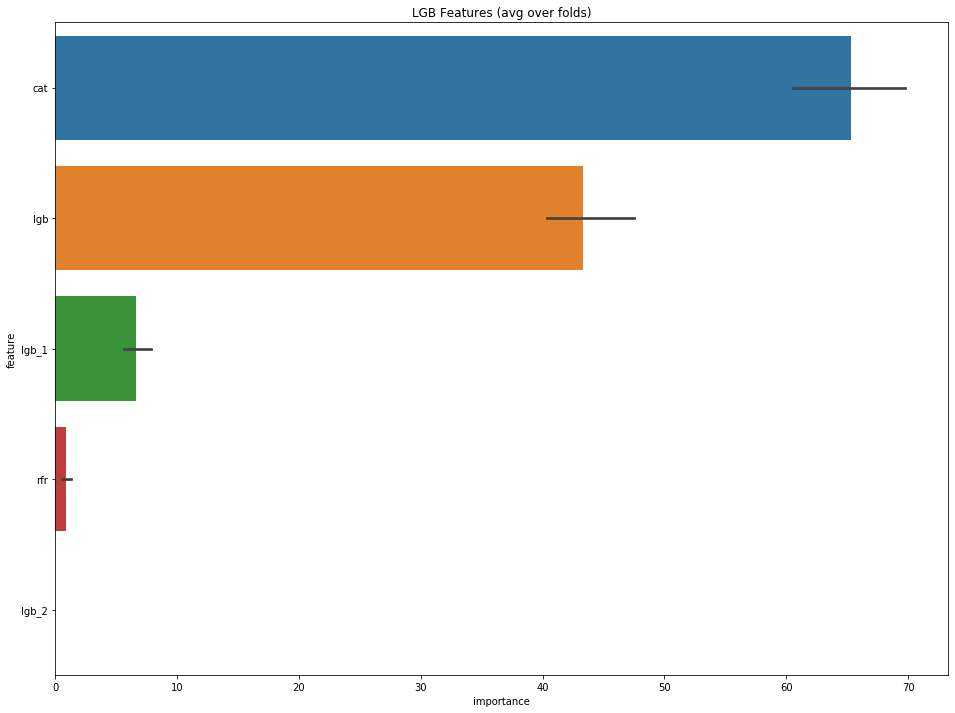

In [94]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 01:21:38 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00592148	valid_1's rmse: 0.0025264
[2000]	training's rmse: 0.00591774	valid_1's rmse: 0.00252451
Early stopping, best iteration is:
[2511]	training's rmse: 0.00591774	valid_1's rmse: 0.0025245
Fold 1 started at Tue Dec 17 01:21:43 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00592944	valid_1's rmse: 0.00392323
[2000]	training's rmse: 0.00592556	valid_1's rmse: 0.00391951
[3000]	training's rmse: 0.00592556	valid_1's rmse: 0.00391951
[4000]	training's rmse: 0.00592556	valid_1's rmse: 0.00391951
Early stopping, best iteration is:
[4363]	training's rmse: 0.00592556	valid_1's rmse: 0.00391951
Fold 2 started at Tue Dec 17 01:21:51 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00587783	valid_1's rmse: 0.00431093
[2000]	training's rmse: 0.00587397	valid_1's rmse: 0.004

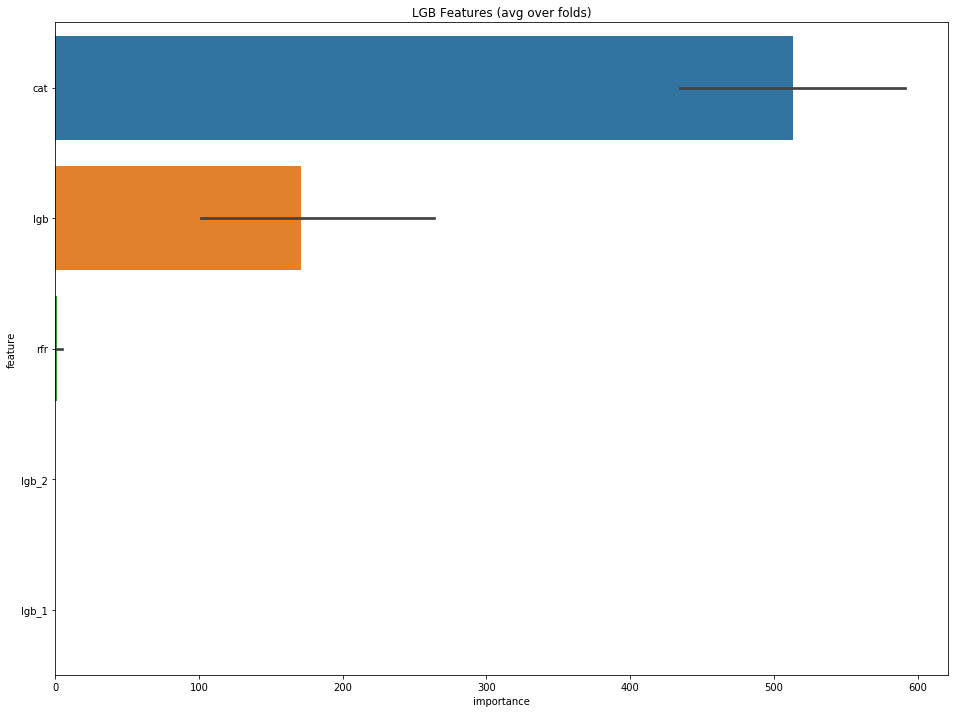

In [95]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [96]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 01:22:43 2019
Fold 1 started at Tue Dec 17 01:22:49 2019
Fold 2 started at Tue Dec 17 01:23:19 2019
Fold 3 started at Tue Dec 17 01:23:58 2019
Fold 4 started at Tue Dec 17 01:24:45 2019
Fold 5 started at Tue Dec 17 01:25:32 2019
Fold 6 started at Tue Dec 17 01:25:37 2019
Fold 7 started at Tue Dec 17 01:25:41 2019
Fold 8 started at Tue Dec 17 01:26:05 2019
Fold 9 started at Tue Dec 17 01:26:15 2019
CV mean score: 0.0035, std: 0.0024.


##### randomforest作为第二层融合模型

In [97]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 01:26:17 2019
Fold 1 started at Tue Dec 17 01:26:17 2019
Fold 2 started at Tue Dec 17 01:26:17 2019
Fold 3 started at Tue Dec 17 01:26:17 2019
Fold 4 started at Tue Dec 17 01:26:18 2019
Fold 5 started at Tue Dec 17 01:26:18 2019
Fold 6 started at Tue Dec 17 01:26:18 2019
Fold 7 started at Tue Dec 17 01:26:18 2019
Fold 8 started at Tue Dec 17 01:26:19 2019
Fold 9 started at Tue Dec 17 01:26:19 2019
CV mean score: 0.0044, std: 0.0024.


##### xgboost作为第二层融合模型

In [98]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 01:26:19 2019
[0]	train-rmse:0.550137	valid_data-rmse:0.552468
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.005043	valid_data-rmse:0.004513
Stopping. Best iteration:
[661]	train-rmse:0.00209	valid_data-rmse:0.002437

Fold 1 started at Tue Dec 17 01:26:19 2019
[0]	train-rmse:0.550162	valid_data-rmse:0.55234
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.005059	valid_data-rmse:0.004421
[1000]	train-rmse:0.000855	valid_data-rmse:0.001437
Stopping. Best iteration:
[974]	train-rmse:0.000879	valid_data-rmse:0.001436

Fold 2 started at Tue Dec 17 01:26:20 2019
[0]	train-rmse:0.550262	valid_data-rmse:0.551404
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train u

##### svr 作为第二层融合模型

In [99]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 01:26:21 2019
Fold 1 started at Tue Dec 17 01:26:21 2019
Fold 2 started at Tue Dec 17 01:26:21 2019
Fold 3 started at Tue Dec 17 01:26:21 2019
Fold 4 started at Tue Dec 17 01:26:21 2019
Fold 5 started at Tue Dec 17 01:26:21 2019
Fold 6 started at Tue Dec 17 01:26:21 2019
Fold 7 started at Tue Dec 17 01:26:21 2019
Fold 8 started at Tue Dec 17 01:26:21 2019
Fold 9 started at Tue Dec 17 01:26:21 2019
CV mean score: 0.0197, std: 0.0037.


##### 岭回归做第二层融合模型

In [100]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 01:26:21 2019
Fold 1 started at Tue Dec 17 01:26:22 2019
Fold 2 started at Tue Dec 17 01:26:22 2019
Fold 3 started at Tue Dec 17 01:26:22 2019
Fold 4 started at Tue Dec 17 01:26:22 2019
Fold 5 started at Tue Dec 17 01:26:22 2019
Fold 6 started at Tue Dec 17 01:26:22 2019
Fold 7 started at Tue Dec 17 01:26:22 2019
Fold 8 started at Tue Dec 17 01:26:22 2019
Fold 9 started at Tue Dec 17 01:26:22 2019
CV mean score: 0.0041, std: 0.0026.


#### 去掉xgb和rfr

In [101]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb',  'cat', 'lgb_1', 'lgb_2','svr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 01:26:22 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[550]	training's rmse: 0.00621214	valid_1's rmse: 0.00273112
Fold 1 started at Tue Dec 17 01:26:23 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[575]	training's rmse: 0.00619706	valid_1's rmse: 0.0042015
Fold 2 started at Tue Dec 17 01:26:24 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[507]	training's rmse: 0.00621815	valid_1's rmse: 0.00461225
Fold 3 started at Tue Dec 17 01:26:25 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[539]	training's rmse: 0.00576416	valid_1's rmse: 0.0109093
Fold 4 started at Tue Dec 17 01:26:26 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[529]	training's rmse: 0.00545945	valid_1's rmse: 0.0

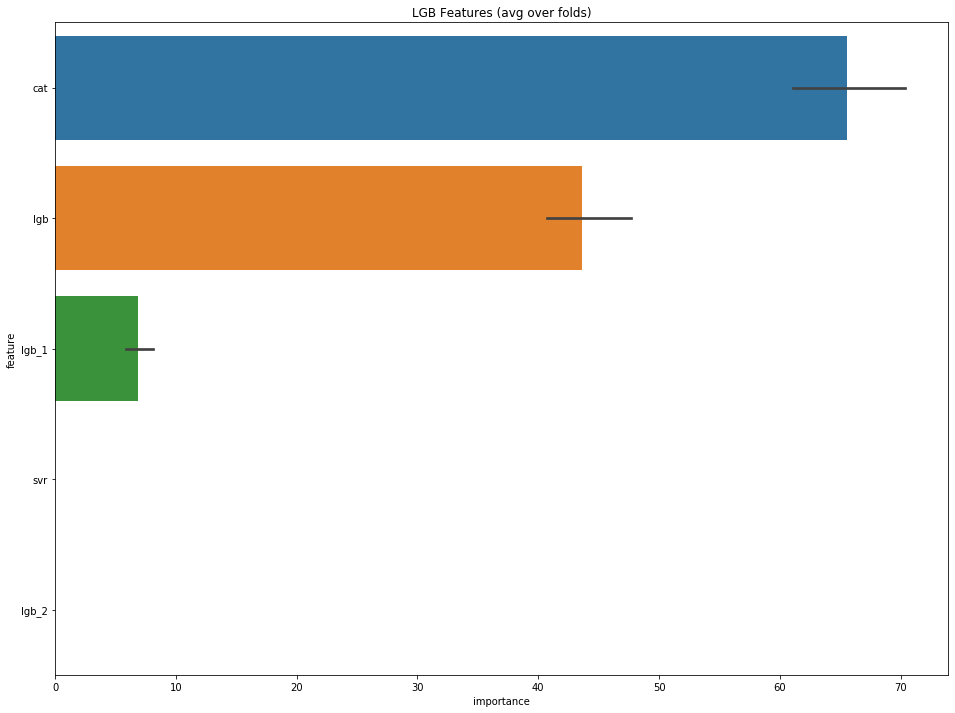

In [102]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 01:26:35 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00592148	valid_1's rmse: 0.0025264
[2000]	training's rmse: 0.00591774	valid_1's rmse: 0.00252451
Early stopping, best iteration is:
[2511]	training's rmse: 0.00591774	valid_1's rmse: 0.0025245
Fold 1 started at Tue Dec 17 01:26:41 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00592944	valid_1's rmse: 0.00392323
[2000]	training's rmse: 0.00592556	valid_1's rmse: 0.00391951
[3000]	training's rmse: 0.00592556	valid_1's rmse: 0.00391951
[4000]	training's rmse: 0.00592556	valid_1's rmse: 0.00391951
Early stopping, best iteration is:
[4363]	training's rmse: 0.00592556	valid_1's rmse: 0.00391951
Fold 2 started at Tue Dec 17 01:26:51 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00587783	valid_1's rmse: 0.00431093
[2000]	training's rmse: 0.00587397	valid_1's rmse: 0.004

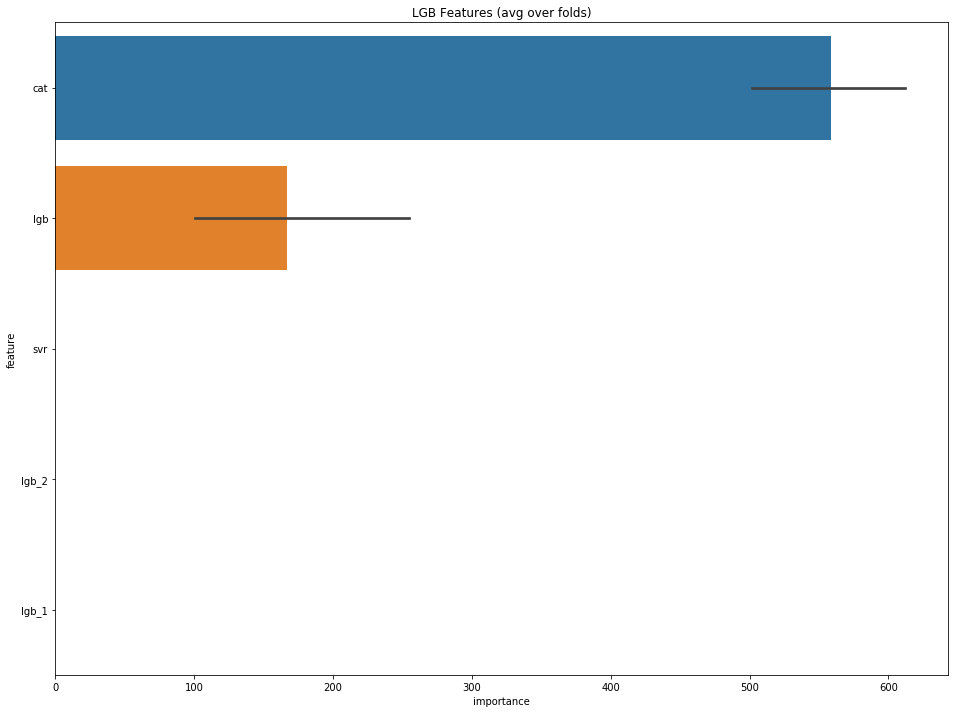

In [103]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [104]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 01:28:20 2019
Fold 1 started at Tue Dec 17 01:28:32 2019
Fold 2 started at Tue Dec 17 01:28:51 2019
Fold 3 started at Tue Dec 17 01:29:13 2019
Fold 4 started at Tue Dec 17 01:29:54 2019
Fold 5 started at Tue Dec 17 01:30:16 2019
Fold 6 started at Tue Dec 17 01:30:21 2019
Fold 7 started at Tue Dec 17 01:30:24 2019
Fold 8 started at Tue Dec 17 01:30:41 2019
Fold 9 started at Tue Dec 17 01:31:02 2019
CV mean score: 0.0034, std: 0.0023.


##### randomforest作为第二层融合模型

In [105]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 01:31:05 2019
Fold 1 started at Tue Dec 17 01:31:06 2019
Fold 2 started at Tue Dec 17 01:31:06 2019
Fold 3 started at Tue Dec 17 01:31:06 2019
Fold 4 started at Tue Dec 17 01:31:06 2019
Fold 5 started at Tue Dec 17 01:31:07 2019
Fold 6 started at Tue Dec 17 01:31:07 2019
Fold 7 started at Tue Dec 17 01:31:07 2019
Fold 8 started at Tue Dec 17 01:31:07 2019
Fold 9 started at Tue Dec 17 01:31:07 2019
CV mean score: 0.0043, std: 0.0026.


##### xgboost作为第二层融合模型

In [106]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 01:31:08 2019
[0]	train-rmse:0.550137	valid_data-rmse:0.552468
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.005041	valid_data-rmse:0.004522
[1000]	train-rmse:0.001017	valid_data-rmse:0.001334
Stopping. Best iteration:
[1165]	train-rmse:0.0009	valid_data-rmse:0.001327

Fold 1 started at Tue Dec 17 01:31:08 2019
[0]	train-rmse:0.550162	valid_data-rmse:0.55234
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.005043	valid_data-rmse:0.00439
[1000]	train-rmse:0.000989	valid_data-rmse:0.001843
Stopping. Best iteration:
[969]	train-rmse:0.001023	valid_data-rmse:0.00184

Fold 2 started at Tue Dec 17 01:31:08 2019
[0]	train-rmse:0.550262	valid_data-rmse:0.551404
Multiple eval metrics have been passed: 'valid_data-rm

##### svr 作为第二层融合模型

In [107]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 01:31:11 2019
Fold 1 started at Tue Dec 17 01:31:11 2019
Fold 2 started at Tue Dec 17 01:31:11 2019
Fold 3 started at Tue Dec 17 01:31:11 2019
Fold 4 started at Tue Dec 17 01:31:11 2019
Fold 5 started at Tue Dec 17 01:31:11 2019
Fold 6 started at Tue Dec 17 01:31:11 2019
Fold 7 started at Tue Dec 17 01:31:11 2019
Fold 8 started at Tue Dec 17 01:31:11 2019
Fold 9 started at Tue Dec 17 01:31:11 2019
CV mean score: 0.0197, std: 0.0037.


##### 岭回归做第二层融合模型

In [108]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 01:31:11 2019
Fold 1 started at Tue Dec 17 01:31:11 2019
Fold 2 started at Tue Dec 17 01:31:12 2019
Fold 3 started at Tue Dec 17 01:31:12 2019
Fold 4 started at Tue Dec 17 01:31:12 2019
Fold 5 started at Tue Dec 17 01:31:12 2019
Fold 6 started at Tue Dec 17 01:31:12 2019
Fold 7 started at Tue Dec 17 01:31:12 2019
Fold 8 started at Tue Dec 17 01:31:12 2019
Fold 9 started at Tue Dec 17 01:31:12 2019
CV mean score: 0.0041, std: 0.0026.


#### 去掉xgb和cat

In [109]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_lgb_1, oof_lgb_2,oof_svr,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb',  'lgb_1', 'lgb_2','svr','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 01:31:12 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[550]	training's rmse: 0.00632448	valid_1's rmse: 0.00321641
Fold 1 started at Tue Dec 17 01:31:14 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[575]	training's rmse: 0.00629917	valid_1's rmse: 0.00440049
Fold 2 started at Tue Dec 17 01:31:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[507]	training's rmse: 0.00632586	valid_1's rmse: 0.00476732
Fold 3 started at Tue Dec 17 01:31:17 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[539]	training's rmse: 0.00589528	valid_1's rmse: 0.0108901
Fold 4 started at Tue Dec 17 01:31:19 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[529]	training's rmse: 0.00550366	valid_1's rmse: 0.

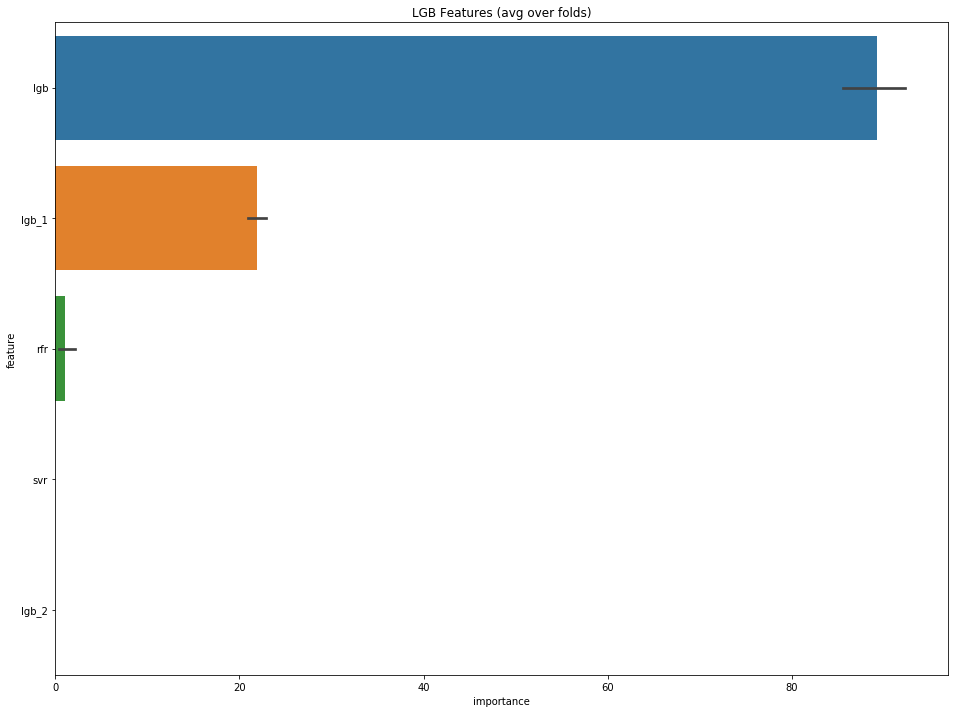

In [110]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 01:31:29 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00610014	valid_1's rmse: 0.00311819
[2000]	training's rmse: 0.00609758	valid_1's rmse: 0.00311725
[3000]	training's rmse: 0.00609758	valid_1's rmse: 0.00311725
Early stopping, best iteration is:
[3434]	training's rmse: 0.00609758	valid_1's rmse: 0.00311725
Fold 1 started at Tue Dec 17 01:31:37 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00608123	valid_1's rmse: 0.00418015
[2000]	training's rmse: 0.00607828	valid_1's rmse: 0.00417735
[3000]	training's rmse: 0.00607828	valid_1's rmse: 0.00417735
Early stopping, best iteration is:
[2862]	training's rmse: 0.00607828	valid_1's rmse: 0.00417735
Fold 2 started at Tue Dec 17 01:31:46 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00604474	valid_1's rmse: 0.00452251
[2000]	training's rmse: 0.00604216	valid_1's rmse: 0.0

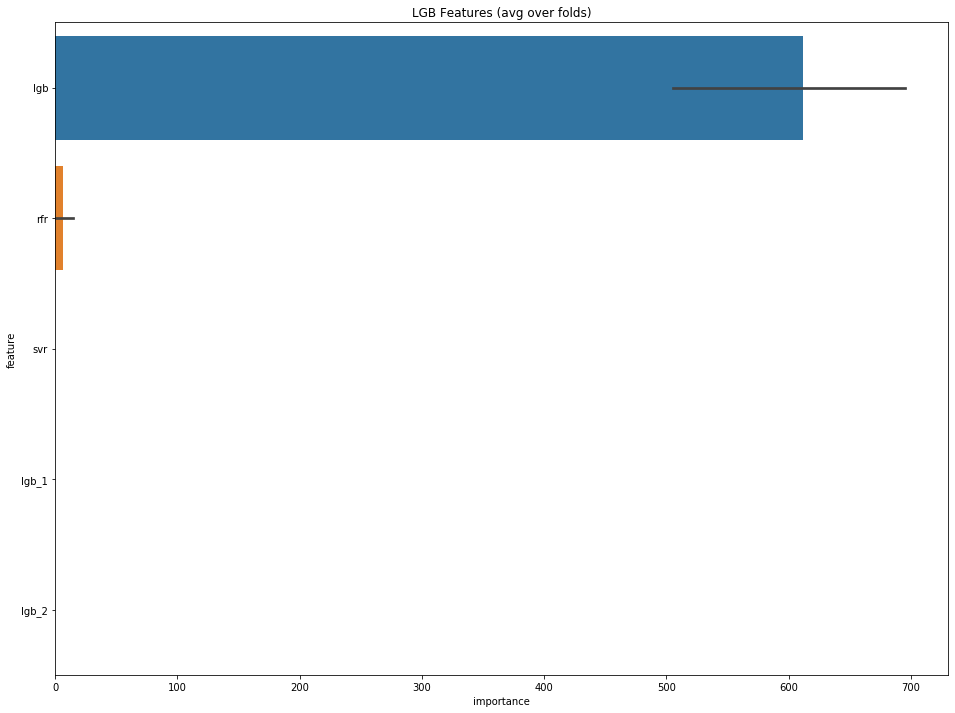

In [111]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [112]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 01:33:03 2019
Fold 1 started at Tue Dec 17 01:33:08 2019
Fold 2 started at Tue Dec 17 01:33:22 2019
Fold 3 started at Tue Dec 17 01:34:07 2019
Fold 4 started at Tue Dec 17 01:34:16 2019
Fold 5 started at Tue Dec 17 01:34:40 2019
Fold 6 started at Tue Dec 17 01:34:44 2019
Fold 7 started at Tue Dec 17 01:34:48 2019
Fold 8 started at Tue Dec 17 01:35:25 2019
Fold 9 started at Tue Dec 17 01:35:51 2019
CV mean score: 0.0044, std: 0.0027.


##### randomforest作为第二层融合模型

In [113]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 01:35:53 2019
Fold 1 started at Tue Dec 17 01:35:53 2019
Fold 2 started at Tue Dec 17 01:35:54 2019
Fold 3 started at Tue Dec 17 01:35:54 2019
Fold 4 started at Tue Dec 17 01:35:54 2019
Fold 5 started at Tue Dec 17 01:35:54 2019
Fold 6 started at Tue Dec 17 01:35:55 2019
Fold 7 started at Tue Dec 17 01:35:55 2019
Fold 8 started at Tue Dec 17 01:35:55 2019
Fold 9 started at Tue Dec 17 01:35:55 2019
CV mean score: 0.0050, std: 0.0024.


##### xgboost作为第二层融合模型

In [114]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 01:35:56 2019
[0]	train-rmse:0.550137	valid_data-rmse:0.552468
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.005445	valid_data-rmse:0.004988
Stopping. Best iteration:
[625]	train-rmse:0.00294	valid_data-rmse:0.003779

Fold 1 started at Tue Dec 17 01:35:56 2019
[0]	train-rmse:0.550162	valid_data-rmse:0.55234
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.005446	valid_data-rmse:0.004511
[1000]	train-rmse:0.001222	valid_data-rmse:0.002585
Stopping. Best iteration:
[1031]	train-rmse:0.001168	valid_data-rmse:0.002578

Fold 2 started at Tue Dec 17 01:35:56 2019
[0]	train-rmse:0.550262	valid_data-rmse:0.551404
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train 

##### svr 作为第二层融合模型

In [115]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 01:35:59 2019
Fold 1 started at Tue Dec 17 01:35:59 2019
Fold 2 started at Tue Dec 17 01:35:59 2019
Fold 3 started at Tue Dec 17 01:35:59 2019
Fold 4 started at Tue Dec 17 01:35:59 2019
Fold 5 started at Tue Dec 17 01:35:59 2019
Fold 6 started at Tue Dec 17 01:35:59 2019
Fold 7 started at Tue Dec 17 01:35:59 2019
Fold 8 started at Tue Dec 17 01:35:59 2019
Fold 9 started at Tue Dec 17 01:35:59 2019
CV mean score: 0.0197, std: 0.0037.


##### 岭回归做第二层融合模型

In [116]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 01:35:59 2019
Fold 1 started at Tue Dec 17 01:35:59 2019
Fold 2 started at Tue Dec 17 01:35:59 2019
Fold 3 started at Tue Dec 17 01:35:59 2019
Fold 4 started at Tue Dec 17 01:35:59 2019
Fold 5 started at Tue Dec 17 01:35:59 2019
Fold 6 started at Tue Dec 17 01:35:59 2019
Fold 7 started at Tue Dec 17 01:36:00 2019
Fold 8 started at Tue Dec 17 01:36:00 2019
Fold 9 started at Tue Dec 17 01:36:00 2019
CV mean score: 0.0050, std: 0.0028.


#### 去掉svr和rfr

In [117]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 01:36:00 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[551]	training's rmse: 0.00616786	valid_1's rmse: 0.0026828
Fold 1 started at Tue Dec 17 01:36:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[575]	training's rmse: 0.00615093	valid_1's rmse: 0.00414128
Fold 2 started at Tue Dec 17 01:36:03 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[507]	training's rmse: 0.0061644	valid_1's rmse: 0.00459286
Fold 3 started at Tue Dec 17 01:36:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[564]	training's rmse: 0.00570503	valid_1's rmse: 0.0109446
Fold 4 started at Tue Dec 17 01:36:07 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[529]	training's rmse: 0.00540761	valid_1's rmse: 0.01

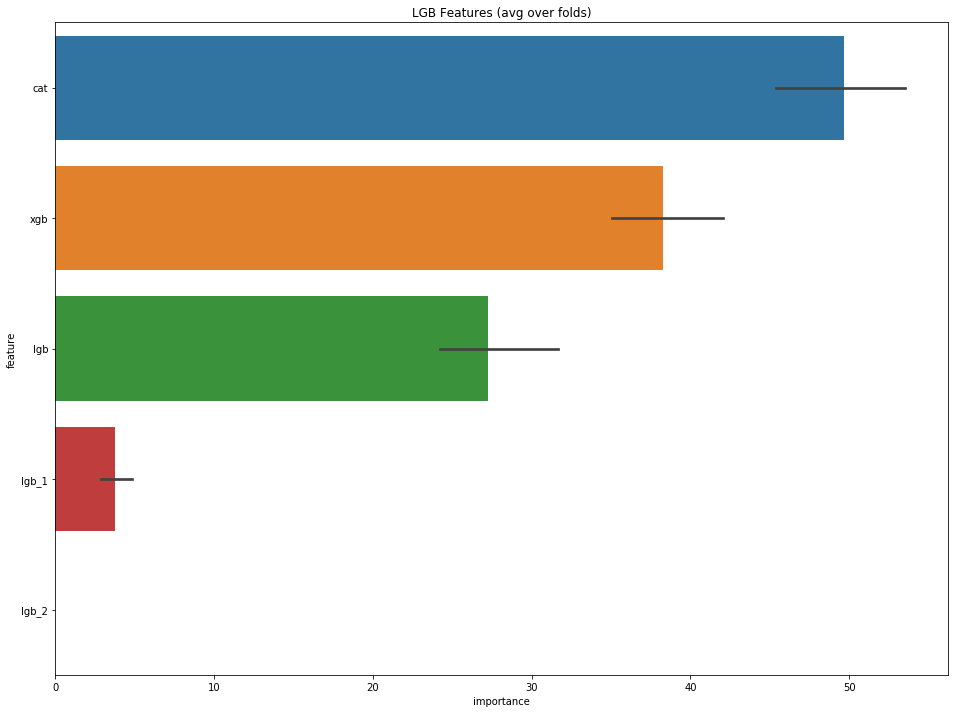

In [118]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 01:36:17 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00589349	valid_1's rmse: 0.00245621
[2000]	training's rmse: 0.00589036	valid_1's rmse: 0.00245399
Early stopping, best iteration is:
[2525]	training's rmse: 0.00589036	valid_1's rmse: 0.00245399
Fold 1 started at Tue Dec 17 01:36:23 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00589836	valid_1's rmse: 0.00389688
[2000]	training's rmse: 0.00589506	valid_1's rmse: 0.00389355
[3000]	training's rmse: 0.00589506	valid_1's rmse: 0.00389355
Early stopping, best iteration is:
[3730]	training's rmse: 0.00589506	valid_1's rmse: 0.00389355
Fold 2 started at Tue Dec 17 01:36:32 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00582524	valid_1's rmse: 0.00430938
[2000]	training's rmse: 0.00582164	valid_1's rmse: 0.00430667
[3000]	training's rmse: 0.00582164	valid_1's rmse: 0.0

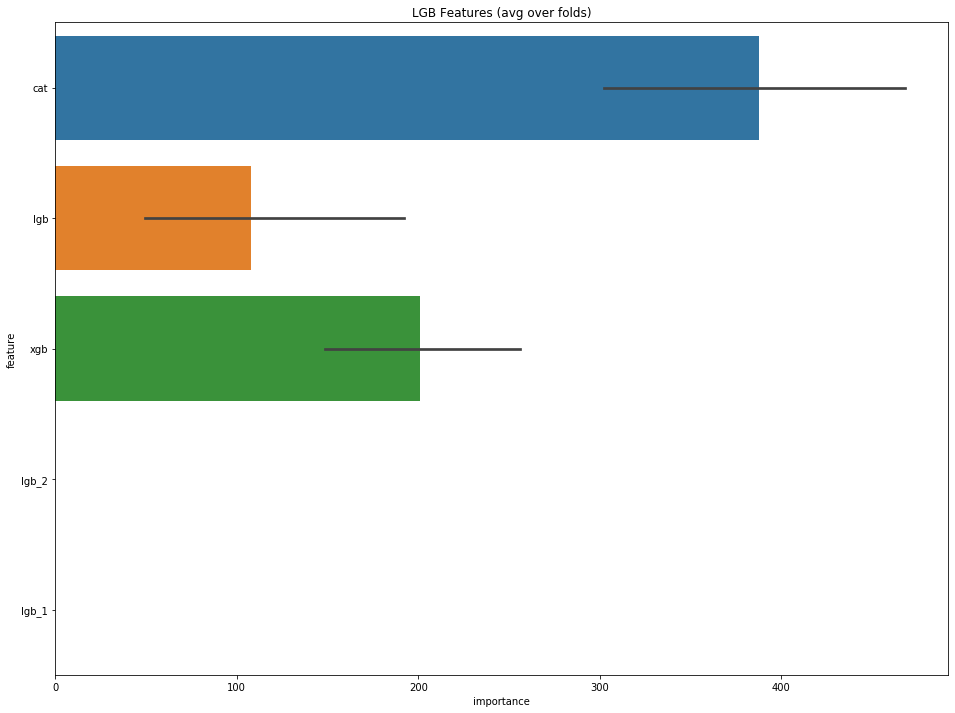

In [119]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [120]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 01:37:59 2019
Fold 1 started at Tue Dec 17 01:38:08 2019
Fold 2 started at Tue Dec 17 01:38:45 2019
Fold 3 started at Tue Dec 17 01:38:51 2019
Fold 4 started at Tue Dec 17 01:39:38 2019
Fold 5 started at Tue Dec 17 01:40:23 2019
Fold 6 started at Tue Dec 17 01:40:30 2019
Fold 7 started at Tue Dec 17 01:40:33 2019
Fold 8 started at Tue Dec 17 01:40:46 2019
Fold 9 started at Tue Dec 17 01:40:56 2019
CV mean score: 0.0032, std: 0.0023.


##### randomforest作为第二层融合模型

In [121]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 01:41:00 2019
Fold 1 started at Tue Dec 17 01:41:00 2019
Fold 2 started at Tue Dec 17 01:41:00 2019
Fold 3 started at Tue Dec 17 01:41:00 2019
Fold 4 started at Tue Dec 17 01:41:00 2019
Fold 5 started at Tue Dec 17 01:41:01 2019
Fold 6 started at Tue Dec 17 01:41:01 2019
Fold 7 started at Tue Dec 17 01:41:01 2019
Fold 8 started at Tue Dec 17 01:41:01 2019
Fold 9 started at Tue Dec 17 01:41:02 2019
CV mean score: 0.0039, std: 0.0025.


##### xgboost作为第二层融合模型

In [122]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 01:41:02 2019
[0]	train-rmse:0.550137	valid_data-rmse:0.552468
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.004982	valid_data-rmse:0.004306
[1000]	train-rmse:0.000905	valid_data-rmse:0.001341
Stopping. Best iteration:
[815]	train-rmse:0.001205	valid_data-rmse:0.001325

Fold 1 started at Tue Dec 17 01:41:02 2019
[0]	train-rmse:0.550162	valid_data-rmse:0.55234
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.005005	valid_data-rmse:0.004195
[1000]	train-rmse:0.000876	valid_data-rmse:0.001454
Stopping. Best iteration:
[970]	train-rmse:0.000903	valid_data-rmse:0.001451

Fold 2 started at Tue Dec 17 01:41:03 2019
[0]	train-rmse:0.550262	valid_data-rmse:0.551404
Multiple eval metrics have been passed: 'valid_data

##### svr 作为第二层融合模型

In [123]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 01:41:05 2019
Fold 1 started at Tue Dec 17 01:41:05 2019
Fold 2 started at Tue Dec 17 01:41:05 2019
Fold 3 started at Tue Dec 17 01:41:05 2019
Fold 4 started at Tue Dec 17 01:41:05 2019
Fold 5 started at Tue Dec 17 01:41:05 2019
Fold 6 started at Tue Dec 17 01:41:05 2019
Fold 7 started at Tue Dec 17 01:41:05 2019
Fold 8 started at Tue Dec 17 01:41:05 2019
Fold 9 started at Tue Dec 17 01:41:05 2019
CV mean score: 0.0197, std: 0.0037.


##### 岭回归做第二层融合模型

In [124]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 01:41:05 2019
Fold 1 started at Tue Dec 17 01:41:05 2019
Fold 2 started at Tue Dec 17 01:41:05 2019
Fold 3 started at Tue Dec 17 01:41:05 2019
Fold 4 started at Tue Dec 17 01:41:06 2019
Fold 5 started at Tue Dec 17 01:41:06 2019
Fold 6 started at Tue Dec 17 01:41:06 2019
Fold 7 started at Tue Dec 17 01:41:06 2019
Fold 8 started at Tue Dec 17 01:41:06 2019
Fold 9 started at Tue Dec 17 01:41:06 2019
CV mean score: 0.0035, std: 0.0026.


#### 去掉svr和cat

In [125]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb,  oof_lgb_1, oof_lgb_2,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb',  'lgb_1', 'lgb_2','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 01:41:06 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[551]	training's rmse: 0.00623589	valid_1's rmse: 0.0030602
Fold 1 started at Tue Dec 17 01:41:08 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[575]	training's rmse: 0.00622753	valid_1's rmse: 0.00429479
Fold 2 started at Tue Dec 17 01:41:10 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[506]	training's rmse: 0.00622437	valid_1's rmse: 0.00488998
Fold 3 started at Tue Dec 17 01:41:13 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[539]	training's rmse: 0.00581089	valid_1's rmse: 0.0109755
Fold 4 started at Tue Dec 17 01:41:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[529]	training's rmse: 0.005418	valid_1's rmse: 0.011

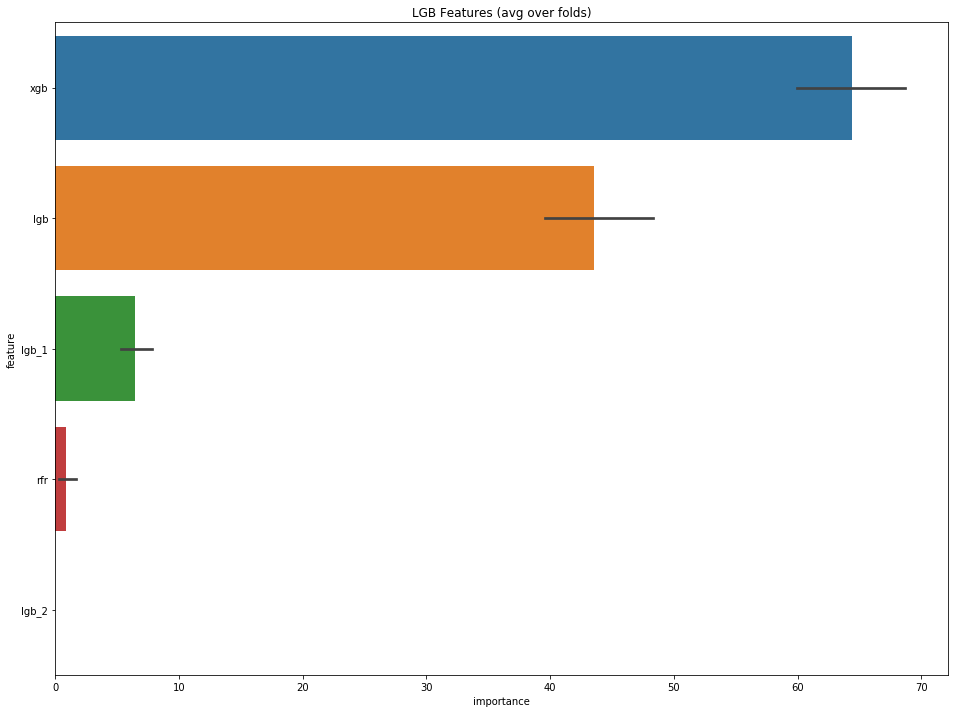

In [126]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 01:41:28 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0059948	valid_1's rmse: 0.0029194
[2000]	training's rmse: 0.00599193	valid_1's rmse: 0.00291763
[3000]	training's rmse: 0.00599193	valid_1's rmse: 0.00291763
[4000]	training's rmse: 0.00599193	valid_1's rmse: 0.00291763
Early stopping, best iteration is:
[4207]	training's rmse: 0.00599193	valid_1's rmse: 0.00291763
Fold 1 started at Tue Dec 17 01:41:38 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00599347	valid_1's rmse: 0.00410339
[2000]	training's rmse: 0.0059901	valid_1's rmse: 0.00410005
[3000]	training's rmse: 0.0059901	valid_1's rmse: 0.00410005
[4000]	training's rmse: 0.0059901	valid_1's rmse: 0.00410005
[5000]	training's rmse: 0.0059901	valid_1's rmse: 0.00410005
[6000]	training's rmse: 0.0059901	valid_1's rmse: 0.00410005
Early stopping, best iteration is:
[5967]	training's rmse: 0.0059901	valid_1's

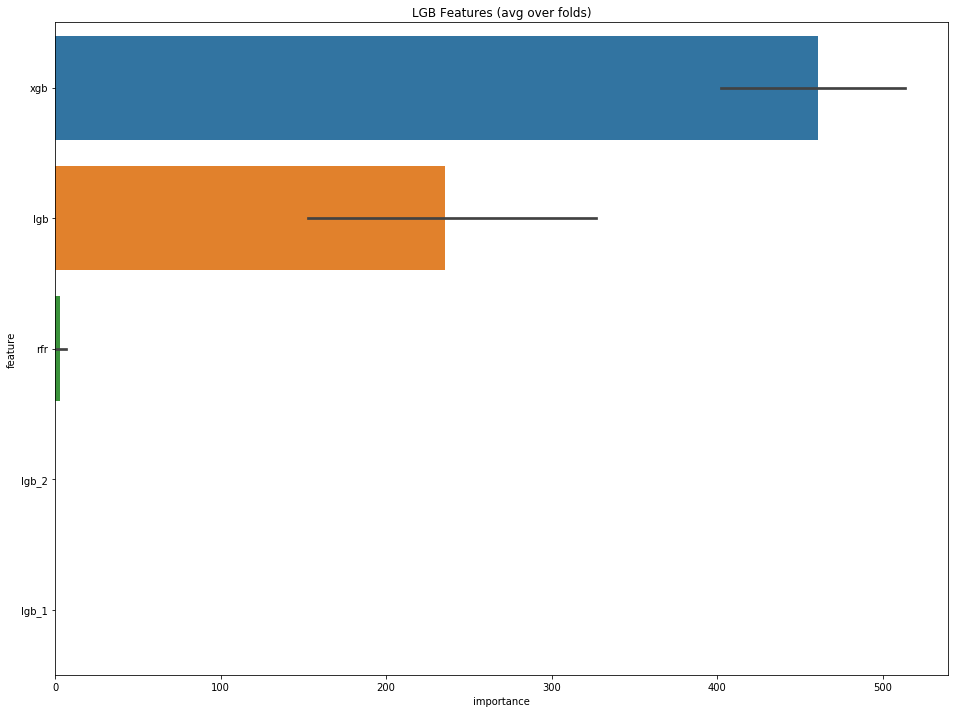

In [127]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [128]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 01:42:49 2019
Fold 1 started at Tue Dec 17 01:42:54 2019
Fold 2 started at Tue Dec 17 01:43:21 2019
Fold 3 started at Tue Dec 17 01:43:24 2019
Fold 4 started at Tue Dec 17 01:43:52 2019
Fold 5 started at Tue Dec 17 01:44:14 2019
Fold 6 started at Tue Dec 17 01:44:18 2019
Fold 7 started at Tue Dec 17 01:44:19 2019
Fold 8 started at Tue Dec 17 01:44:28 2019
Fold 9 started at Tue Dec 17 01:44:32 2019
CV mean score: 0.0035, std: 0.0023.


##### randomforest作为第二层融合模型

In [129]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 01:44:34 2019
Fold 1 started at Tue Dec 17 01:44:34 2019
Fold 2 started at Tue Dec 17 01:44:35 2019
Fold 3 started at Tue Dec 17 01:44:35 2019
Fold 4 started at Tue Dec 17 01:44:35 2019
Fold 5 started at Tue Dec 17 01:44:35 2019
Fold 6 started at Tue Dec 17 01:44:36 2019
Fold 7 started at Tue Dec 17 01:44:36 2019
Fold 8 started at Tue Dec 17 01:44:36 2019
Fold 9 started at Tue Dec 17 01:44:36 2019
CV mean score: 0.0044, std: 0.0024.


##### xgboost作为第二层融合模型

In [130]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 01:44:36 2019
[0]	train-rmse:0.550137	valid_data-rmse:0.552468
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.00506	valid_data-rmse:0.004152
Stopping. Best iteration:
[606]	train-rmse:0.002707	valid_data-rmse:0.002579

Fold 1 started at Tue Dec 17 01:44:37 2019
[0]	train-rmse:0.550162	valid_data-rmse:0.55234
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.005074	valid_data-rmse:0.004029
[1000]	train-rmse:0.000882	valid_data-rmse:0.001479
Stopping. Best iteration:
[875]	train-rmse:0.001076	valid_data-rmse:0.001468

Fold 2 started at Tue Dec 17 01:44:37 2019
[0]	train-rmse:0.550262	valid_data-rmse:0.551404
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train u

##### svr 作为第二层融合模型

In [131]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 01:44:39 2019
Fold 1 started at Tue Dec 17 01:44:39 2019
Fold 2 started at Tue Dec 17 01:44:39 2019
Fold 3 started at Tue Dec 17 01:44:39 2019
Fold 4 started at Tue Dec 17 01:44:39 2019
Fold 5 started at Tue Dec 17 01:44:39 2019
Fold 6 started at Tue Dec 17 01:44:39 2019
Fold 7 started at Tue Dec 17 01:44:39 2019
Fold 8 started at Tue Dec 17 01:44:39 2019
Fold 9 started at Tue Dec 17 01:44:39 2019
CV mean score: 0.0197, std: 0.0037.


##### 岭回归做第二层融合模型

In [132]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 01:44:39 2019
Fold 1 started at Tue Dec 17 01:44:39 2019
Fold 2 started at Tue Dec 17 01:44:39 2019
Fold 3 started at Tue Dec 17 01:44:39 2019
Fold 4 started at Tue Dec 17 01:44:39 2019
Fold 5 started at Tue Dec 17 01:44:39 2019
Fold 6 started at Tue Dec 17 01:44:39 2019
Fold 7 started at Tue Dec 17 01:44:39 2019
Fold 8 started at Tue Dec 17 01:44:39 2019
Fold 9 started at Tue Dec 17 01:44:39 2019
CV mean score: 0.0040, std: 0.0027.


#### 去掉rfr和cat

In [133]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb,  oof_lgb_1, oof_lgb_2,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb',  'lgb_1', 'lgb_2','svr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 01:44:39 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[551]	training's rmse: 0.00623589	valid_1's rmse: 0.0030602
Fold 1 started at Tue Dec 17 01:44:40 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[575]	training's rmse: 0.00622781	valid_1's rmse: 0.00429472
Fold 2 started at Tue Dec 17 01:44:41 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[506]	training's rmse: 0.00622526	valid_1's rmse: 0.00489113
Fold 3 started at Tue Dec 17 01:44:41 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[539]	training's rmse: 0.00581044	valid_1's rmse: 0.0109746
Fold 4 started at Tue Dec 17 01:44:42 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[529]	training's rmse: 0.00541719	valid_1's rmse: 0.0

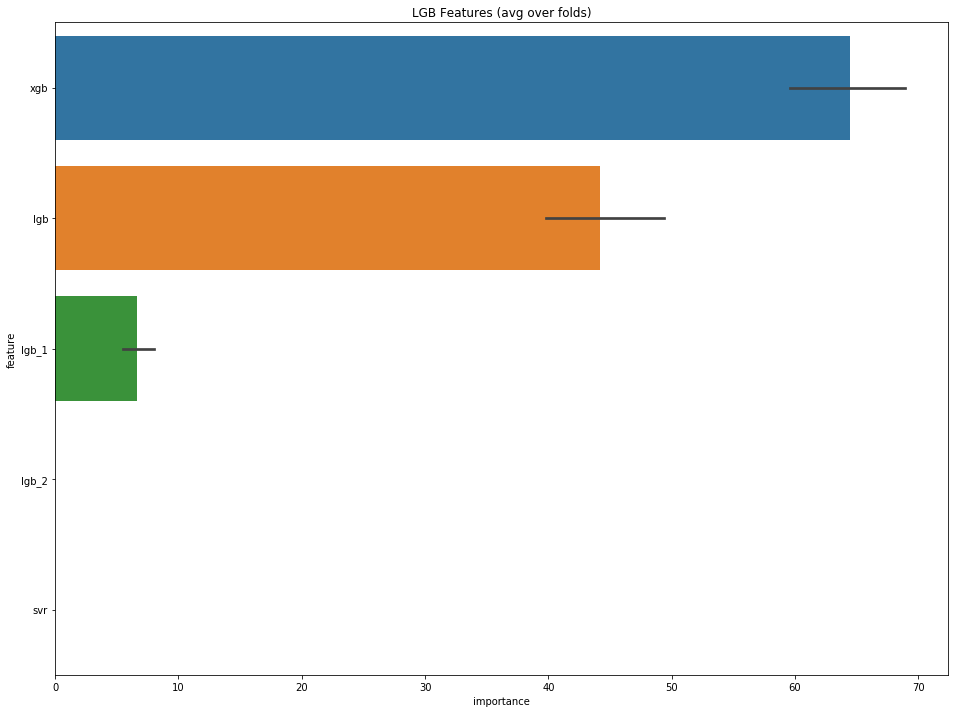

In [134]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 01:44:50 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0059948	valid_1's rmse: 0.0029194
[2000]	training's rmse: 0.00599193	valid_1's rmse: 0.00291763
[3000]	training's rmse: 0.00599193	valid_1's rmse: 0.00291763
[4000]	training's rmse: 0.00599193	valid_1's rmse: 0.00291763
Early stopping, best iteration is:
[4207]	training's rmse: 0.00599193	valid_1's rmse: 0.00291763
Fold 1 started at Tue Dec 17 01:44:57 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00599353	valid_1's rmse: 0.00410325
[2000]	training's rmse: 0.00599017	valid_1's rmse: 0.00409991
[3000]	training's rmse: 0.00599017	valid_1's rmse: 0.0040999
[4000]	training's rmse: 0.00599017	valid_1's rmse: 0.0040999
[5000]	training's rmse: 0.00599017	valid_1's rmse: 0.0040999
Early stopping, best iteration is:
[4916]	training's rmse: 0.00599017	valid_1's rmse: 0.0040999
Fold 2 started at Tue Dec 17 01:45:04 2019

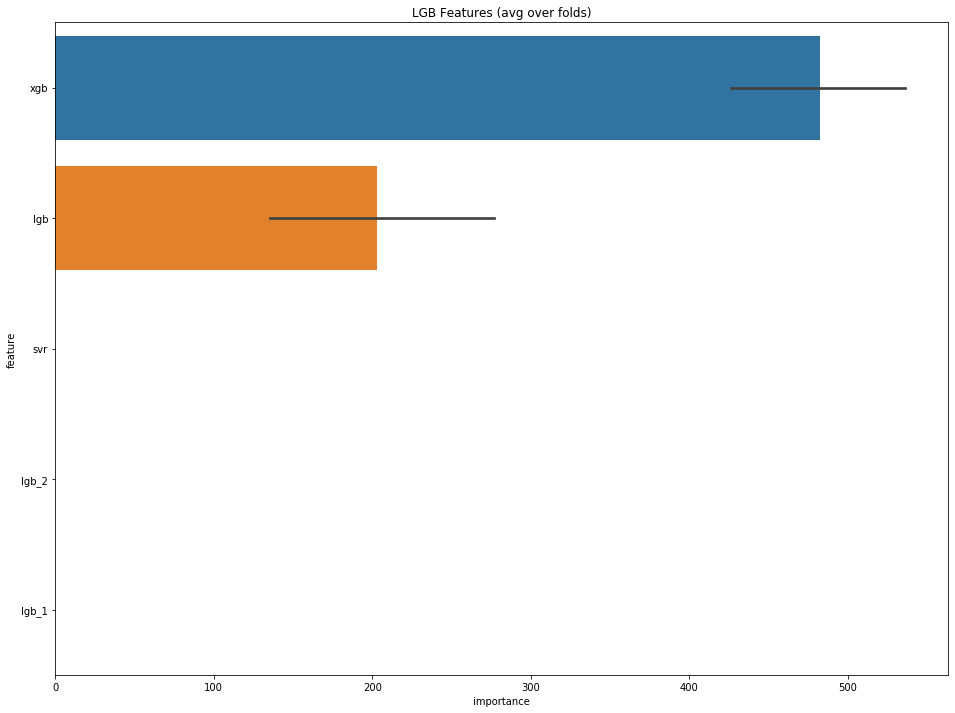

In [135]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [136]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 01:45:28 2019
Fold 1 started at Tue Dec 17 01:45:33 2019
Fold 2 started at Tue Dec 17 01:45:44 2019
Fold 3 started at Tue Dec 17 01:45:47 2019
Fold 4 started at Tue Dec 17 01:46:14 2019
Fold 5 started at Tue Dec 17 01:46:28 2019
Fold 6 started at Tue Dec 17 01:46:32 2019
Fold 7 started at Tue Dec 17 01:46:35 2019
Fold 8 started at Tue Dec 17 01:46:45 2019
Fold 9 started at Tue Dec 17 01:46:50 2019
CV mean score: 0.0033, std: 0.0024.


##### randomforest作为第二层融合模型

In [137]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 01:46:51 2019
Fold 1 started at Tue Dec 17 01:46:52 2019
Fold 2 started at Tue Dec 17 01:46:52 2019
Fold 3 started at Tue Dec 17 01:46:52 2019
Fold 4 started at Tue Dec 17 01:46:52 2019
Fold 5 started at Tue Dec 17 01:46:53 2019
Fold 6 started at Tue Dec 17 01:46:53 2019
Fold 7 started at Tue Dec 17 01:46:53 2019
Fold 8 started at Tue Dec 17 01:46:53 2019
Fold 9 started at Tue Dec 17 01:46:53 2019
CV mean score: 0.0044, std: 0.0026.


##### xgboost作为第二层融合模型

In [138]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 01:46:54 2019
[0]	train-rmse:0.550137	valid_data-rmse:0.552468
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.005059	valid_data-rmse:0.004149
Stopping. Best iteration:
[772]	train-rmse:0.001448	valid_data-rmse:0.001474

Fold 1 started at Tue Dec 17 01:46:54 2019
[0]	train-rmse:0.550162	valid_data-rmse:0.55234
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.005061	valid_data-rmse:0.003975
[1000]	train-rmse:0.000937	valid_data-rmse:0.001513
[1500]	train-rmse:0.00078	valid_data-rmse:0.001501
Stopping. Best iteration:
[1413]	train-rmse:0.000791	valid_data-rmse:0.001499

Fold 2 started at Tue Dec 17 01:46:54 2019
[0]	train-rmse:0.550262	valid_data-rmse:0.551404
Multiple eval metrics have been passed: 'valid_data

##### svr 作为第二层融合模型

In [139]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 01:46:56 2019
Fold 1 started at Tue Dec 17 01:46:56 2019
Fold 2 started at Tue Dec 17 01:46:56 2019
Fold 3 started at Tue Dec 17 01:46:56 2019
Fold 4 started at Tue Dec 17 01:46:56 2019
Fold 5 started at Tue Dec 17 01:46:56 2019
Fold 6 started at Tue Dec 17 01:46:56 2019
Fold 7 started at Tue Dec 17 01:46:56 2019
Fold 8 started at Tue Dec 17 01:46:56 2019
Fold 9 started at Tue Dec 17 01:46:56 2019
CV mean score: 0.0197, std: 0.0037.


##### 岭回归做第二层融合模型

In [140]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 01:46:56 2019
Fold 1 started at Tue Dec 17 01:46:56 2019
Fold 2 started at Tue Dec 17 01:46:56 2019
Fold 3 started at Tue Dec 17 01:46:56 2019
Fold 4 started at Tue Dec 17 01:46:56 2019
Fold 5 started at Tue Dec 17 01:46:56 2019
Fold 6 started at Tue Dec 17 01:46:56 2019
Fold 7 started at Tue Dec 17 01:46:56 2019
Fold 8 started at Tue Dec 17 01:46:56 2019
Fold 9 started at Tue Dec 17 01:46:56 2019
CV mean score: 0.0039, std: 0.0027.


#### 留下cat和rfr

In [141]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_cat, oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=[ 'cat', 'rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 01:46:56 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[656]	training's rmse: 0.00651474	valid_1's rmse: 0.00316544
Fold 1 started at Tue Dec 17 01:46:57 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[682]	training's rmse: 0.00648251	valid_1's rmse: 0.00440533
Fold 2 started at Tue Dec 17 01:46:58 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[679]	training's rmse: 0.00643282	valid_1's rmse: 0.00482852
Fold 3 started at Tue Dec 17 01:47:00 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[692]	training's rmse: 0.0059772	valid_1's rmse: 0.0110962
Fold 4 started at Tue Dec 17 01:47:01 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[618]	training's rmse: 0.00569513	valid_1's rmse: 0.0

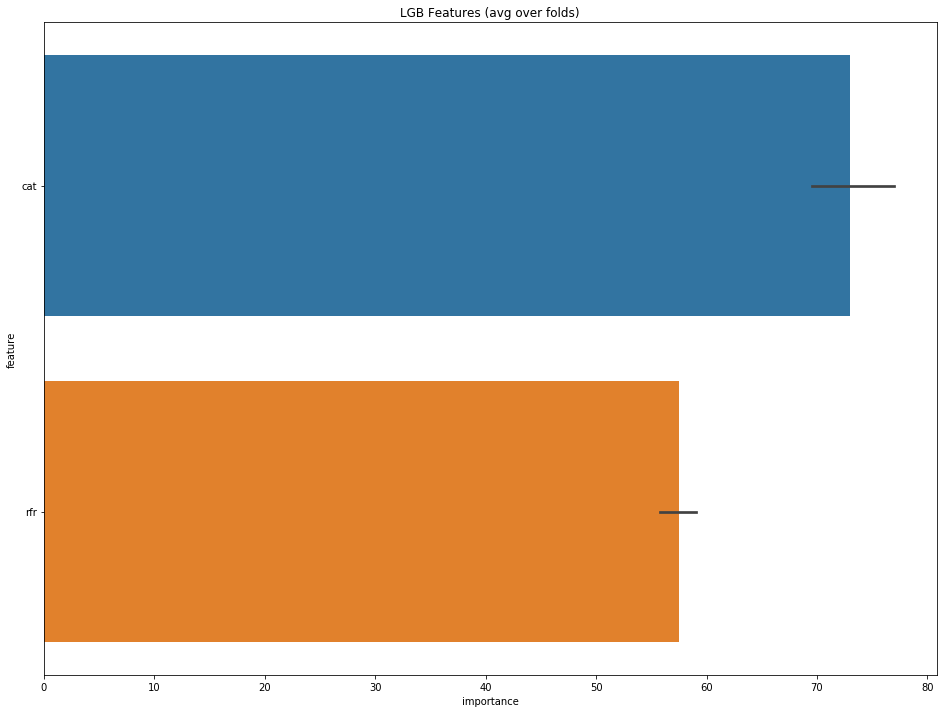

In [142]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 01:47:10 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00595873	valid_1's rmse: 0.00251597
[2000]	training's rmse: 0.00595491	valid_1's rmse: 0.00251386
Early stopping, best iteration is:
[2518]	training's rmse: 0.00595491	valid_1's rmse: 0.00251386
Fold 1 started at Tue Dec 17 01:47:14 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0059541	valid_1's rmse: 0.00387005
[2000]	training's rmse: 0.00595021	valid_1's rmse: 0.00386636
[3000]	training's rmse: 0.00595021	valid_1's rmse: 0.00386635
[4000]	training's rmse: 0.00595021	valid_1's rmse: 0.00386635
Early stopping, best iteration is:
[4052]	training's rmse: 0.00595021	valid_1's rmse: 0.00386635
Fold 2 started at Tue Dec 17 01:47:21 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00590507	valid_1's rmse: 0.00431765
[2000]	training's rmse: 0.00590116	valid_1's rmse: 0.00

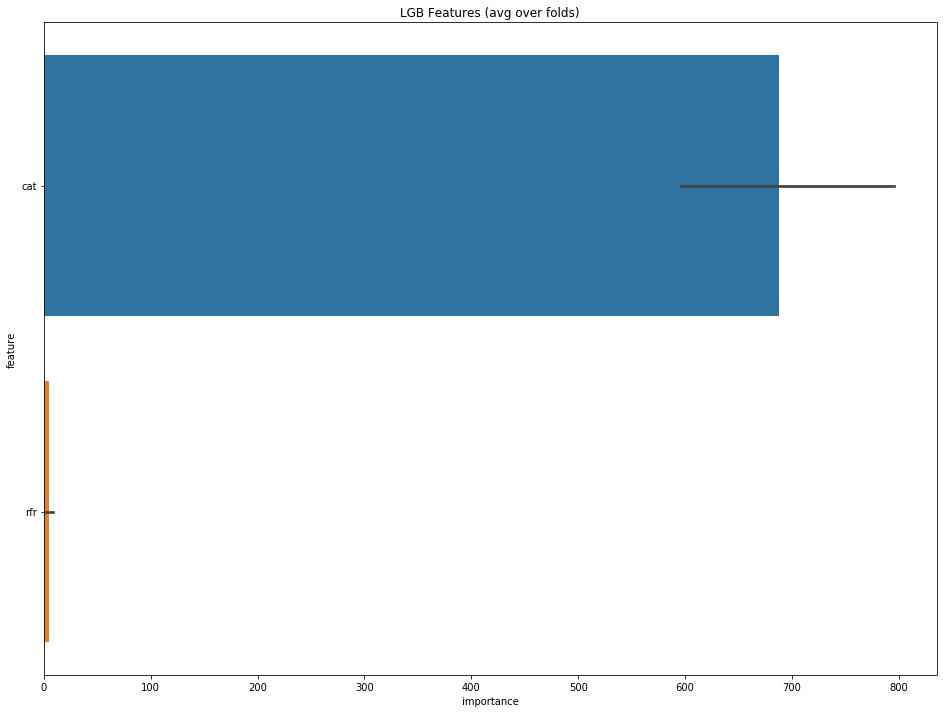

In [143]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [144]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 01:47:48 2019
Fold 1 started at Tue Dec 17 01:47:51 2019
Fold 2 started at Tue Dec 17 01:48:14 2019
Fold 3 started at Tue Dec 17 01:48:20 2019
Fold 4 started at Tue Dec 17 01:48:43 2019
Fold 5 started at Tue Dec 17 01:49:06 2019
Fold 6 started at Tue Dec 17 01:49:10 2019
Fold 7 started at Tue Dec 17 01:49:12 2019
Fold 8 started at Tue Dec 17 01:49:26 2019
Fold 9 started at Tue Dec 17 01:49:49 2019
CV mean score: 0.0038, std: 0.0024.


##### randomforest作为第二层融合模型

In [145]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 01:49:51 2019
Fold 1 started at Tue Dec 17 01:49:51 2019
Fold 2 started at Tue Dec 17 01:49:51 2019
Fold 3 started at Tue Dec 17 01:49:51 2019
Fold 4 started at Tue Dec 17 01:49:52 2019
Fold 5 started at Tue Dec 17 01:49:52 2019
Fold 6 started at Tue Dec 17 01:49:52 2019
Fold 7 started at Tue Dec 17 01:49:52 2019
Fold 8 started at Tue Dec 17 01:49:53 2019
Fold 9 started at Tue Dec 17 01:49:53 2019
CV mean score: 0.0044, std: 0.0024.


##### xgboost作为第二层融合模型

In [146]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 01:49:53 2019
[0]	train-rmse:0.550137	valid_data-rmse:0.552468
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.005533	valid_data-rmse:0.00515
Stopping. Best iteration:
[634]	train-rmse:0.003053	valid_data-rmse:0.003432

Fold 1 started at Tue Dec 17 01:49:53 2019
[0]	train-rmse:0.550162	valid_data-rmse:0.55234
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.00554	valid_data-rmse:0.004863
[1000]	train-rmse:0.001448	valid_data-rmse:0.00256
Stopping. Best iteration:
[874]	train-rmse:0.001737	valid_data-rmse:0.002548

Fold 2 started at Tue Dec 17 01:49:53 2019
[0]	train-rmse:0.550262	valid_data-rmse:0.551404
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train unt

##### svr 作为第二层融合模型

In [147]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 01:49:56 2019
Fold 1 started at Tue Dec 17 01:49:56 2019
Fold 2 started at Tue Dec 17 01:49:56 2019
Fold 3 started at Tue Dec 17 01:49:56 2019
Fold 4 started at Tue Dec 17 01:49:56 2019
Fold 5 started at Tue Dec 17 01:49:56 2019
Fold 6 started at Tue Dec 17 01:49:56 2019
Fold 7 started at Tue Dec 17 01:49:56 2019
Fold 8 started at Tue Dec 17 01:49:56 2019
Fold 9 started at Tue Dec 17 01:49:56 2019
CV mean score: 0.0197, std: 0.0037.


##### 岭回归做第二层融合模型

In [148]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 01:49:56 2019
Fold 1 started at Tue Dec 17 01:49:56 2019
Fold 2 started at Tue Dec 17 01:49:56 2019
Fold 3 started at Tue Dec 17 01:49:56 2019
Fold 4 started at Tue Dec 17 01:49:56 2019
Fold 5 started at Tue Dec 17 01:49:56 2019
Fold 6 started at Tue Dec 17 01:49:57 2019
Fold 7 started at Tue Dec 17 01:49:57 2019
Fold 8 started at Tue Dec 17 01:49:57 2019
Fold 9 started at Tue Dec 17 01:49:57 2019
CV mean score: 0.0041, std: 0.0025.


#### 留下cat和svr

In [149]:
#构建第二层训练矩阵
train_stack = np.vstack([ oof_cat, oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=[ 'cat','svr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 01:49:57 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00630778	valid_1's rmse: 0.00280712
Early stopping, best iteration is:
[1060]	training's rmse: 0.00627445	valid_1's rmse: 0.00277789
Fold 1 started at Tue Dec 17 01:49:58 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 1.05552	valid_1's rmse: 1.05321
Fold 2 started at Tue Dec 17 01:49:58 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00626285	valid_1's rmse: 0.00464403
Early stopping, best iteration is:
[1196]	training's rmse: 0.00615587	valid_1's rmse: 0.00454444
Fold 3 started at Tue Dec 17 01:49:58 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 1.05654	valid_1's rmse: 1.06479
Fold 4 started at Tue Dec 17 01:49:59 2019
Training until validation scores don't 

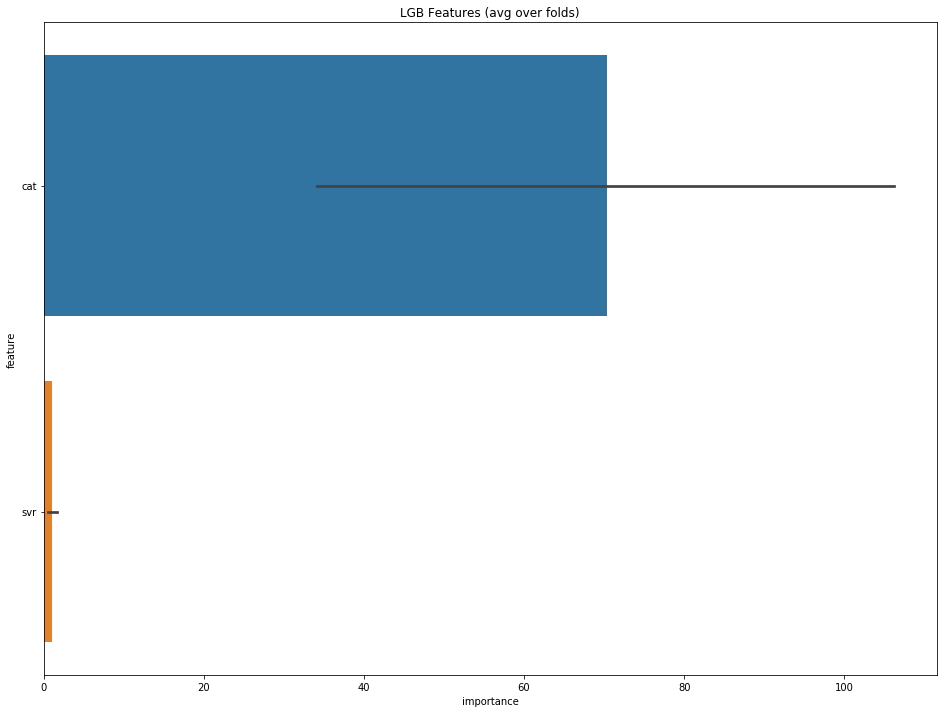

In [150]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 01:50:02 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00595873	valid_1's rmse: 0.00251597
[2000]	training's rmse: 0.00595491	valid_1's rmse: 0.00251386
Early stopping, best iteration is:
[2518]	training's rmse: 0.00595491	valid_1's rmse: 0.00251386
Fold 1 started at Tue Dec 17 01:50:03 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0059541	valid_1's rmse: 0.00387004
[2000]	training's rmse: 0.00595022	valid_1's rmse: 0.00386635
[3000]	training's rmse: 0.00595021	valid_1's rmse: 0.00386635
Early stopping, best iteration is:
[3764]	training's rmse: 0.00595021	valid_1's rmse: 0.00386635
Fold 2 started at Tue Dec 17 01:50:05 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00590523	valid_1's rmse: 0.00431486
[2000]	training's rmse: 0.00590135	valid_1's rmse: 0.00431113
[3000]	training's rmse: 0.00590135	valid_1's rmse: 0.00

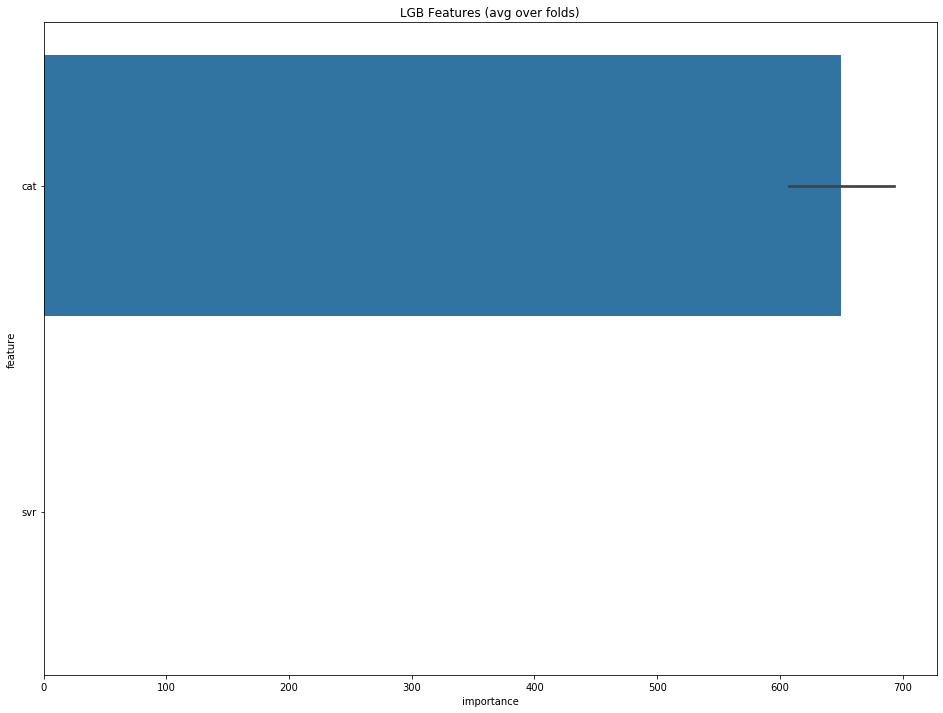

In [151]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [152]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 01:50:22 2019
Fold 1 started at Tue Dec 17 01:50:26 2019
Fold 2 started at Tue Dec 17 01:50:30 2019
Fold 3 started at Tue Dec 17 01:50:35 2019
Fold 4 started at Tue Dec 17 01:50:54 2019
Fold 5 started at Tue Dec 17 01:51:15 2019
Fold 6 started at Tue Dec 17 01:51:19 2019
Fold 7 started at Tue Dec 17 01:51:21 2019
Fold 8 started at Tue Dec 17 01:51:28 2019
Fold 9 started at Tue Dec 17 01:51:37 2019
CV mean score: 0.0033, std: 0.0023.


##### randomforest作为第二层融合模型

In [153]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 01:51:39 2019
Fold 1 started at Tue Dec 17 01:51:39 2019
Fold 2 started at Tue Dec 17 01:51:40 2019
Fold 3 started at Tue Dec 17 01:51:40 2019
Fold 4 started at Tue Dec 17 01:51:40 2019
Fold 5 started at Tue Dec 17 01:51:40 2019
Fold 6 started at Tue Dec 17 01:51:40 2019
Fold 7 started at Tue Dec 17 01:51:41 2019
Fold 8 started at Tue Dec 17 01:51:41 2019
Fold 9 started at Tue Dec 17 01:51:41 2019
CV mean score: 0.0038, std: 0.0024.


##### xgboost作为第二层融合模型

In [154]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 01:51:41 2019
[0]	train-rmse:0.550137	valid_data-rmse:0.552468
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.006133	valid_data-rmse:0.005245
[1000]	train-rmse:0.00179	valid_data-rmse:0.001451
Stopping. Best iteration:
[1200]	train-rmse:0.001469	valid_data-rmse:0.001435

Fold 1 started at Tue Dec 17 01:51:42 2019
[0]	train-rmse:0.550162	valid_data-rmse:0.55234
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.006152	valid_data-rmse:0.005103
[1000]	train-rmse:0.001767	valid_data-rmse:0.00152
Stopping. Best iteration:
[872]	train-rmse:0.002138	valid_data-rmse:0.001437

Fold 2 started at Tue Dec 17 01:51:42 2019
[0]	train-rmse:0.550262	valid_data-rmse:0.551404
Multiple eval metrics have been passed: 'valid_data-

##### svr 作为第二层融合模型

In [155]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 01:51:43 2019
Fold 1 started at Tue Dec 17 01:51:43 2019
Fold 2 started at Tue Dec 17 01:51:43 2019
Fold 3 started at Tue Dec 17 01:51:43 2019
Fold 4 started at Tue Dec 17 01:51:43 2019
Fold 5 started at Tue Dec 17 01:51:43 2019
Fold 6 started at Tue Dec 17 01:51:43 2019
Fold 7 started at Tue Dec 17 01:51:43 2019
Fold 8 started at Tue Dec 17 01:51:43 2019
Fold 9 started at Tue Dec 17 01:51:43 2019
CV mean score: 0.0197, std: 0.0037.


##### 岭回归做第二层融合模型

In [156]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 01:51:43 2019
Fold 1 started at Tue Dec 17 01:51:43 2019
Fold 2 started at Tue Dec 17 01:51:43 2019
Fold 3 started at Tue Dec 17 01:51:43 2019
Fold 4 started at Tue Dec 17 01:51:43 2019
Fold 5 started at Tue Dec 17 01:51:43 2019
Fold 6 started at Tue Dec 17 01:51:44 2019
Fold 7 started at Tue Dec 17 01:51:44 2019
Fold 8 started at Tue Dec 17 01:51:44 2019
Fold 9 started at Tue Dec 17 01:51:44 2019
CV mean score: 0.0039, std: 0.0023.


#### 留下rfr和svr

In [157]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_svr,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['svr','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 01:51:44 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00743922	valid_1's rmse: 0.00374802
Early stopping, best iteration is:
[983]	training's rmse: 0.00744013	valid_1's rmse: 0.00374793
Fold 1 started at Tue Dec 17 01:51:45 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00736623	valid_1's rmse: 0.00559248
Early stopping, best iteration is:
[999]	training's rmse: 0.00736623	valid_1's rmse: 0.00559248
Fold 2 started at Tue Dec 17 01:51:47 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00733469	valid_1's rmse: 0.00553818
Early stopping, best iteration is:
[983]	training's rmse: 0.00733469	valid_1's rmse: 0.00553818
Fold 3 started at Tue Dec 17 01:51:49 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00691041	valid_1's rmse: 0.0121738
Early stopping, best iteration is:
[951]	

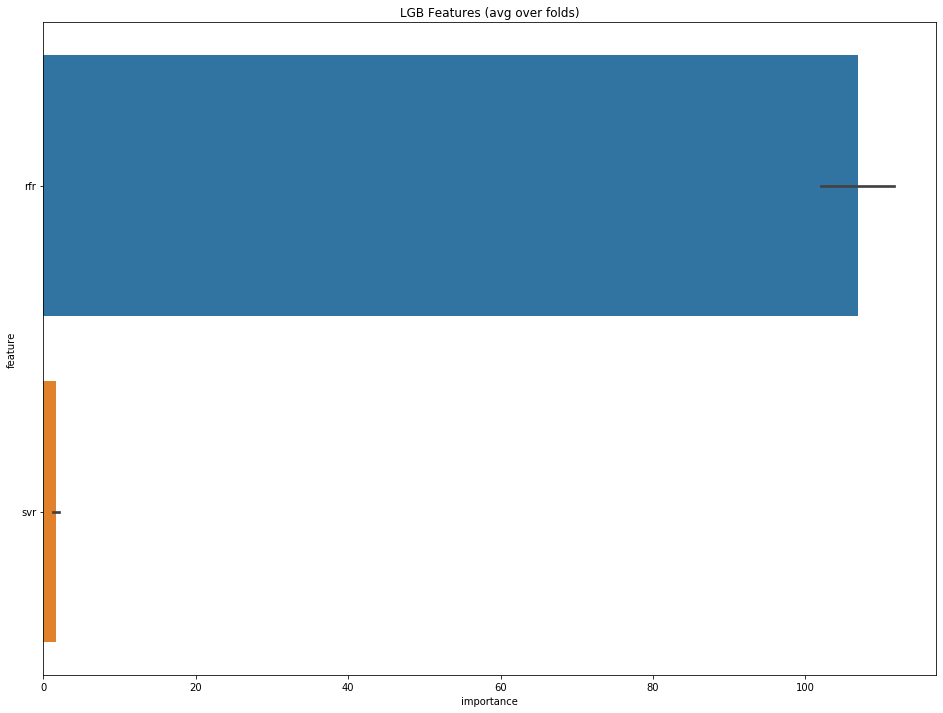

In [158]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 01:52:00 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00722829	valid_1's rmse: 0.00359116
[2000]	training's rmse: 0.00722636	valid_1's rmse: 0.00359028
Early stopping, best iteration is:
[2479]	training's rmse: 0.00722636	valid_1's rmse: 0.00359028
Fold 1 started at Tue Dec 17 01:52:04 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00715555	valid_1's rmse: 0.00535463
[2000]	training's rmse: 0.00715334	valid_1's rmse: 0.00535211
[3000]	training's rmse: 0.00715333	valid_1's rmse: 0.00535211
Early stopping, best iteration is:
[3493]	training's rmse: 0.00715333	valid_1's rmse: 0.00535211
Fold 2 started at Tue Dec 17 01:52:10 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00709057	valid_1's rmse: 0.00531335
[2000]	training's rmse: 0.00708832	valid_1's rmse: 0.00531099
[3000]	training's rmse: 0.00708832	valid_1's rmse: 0.0

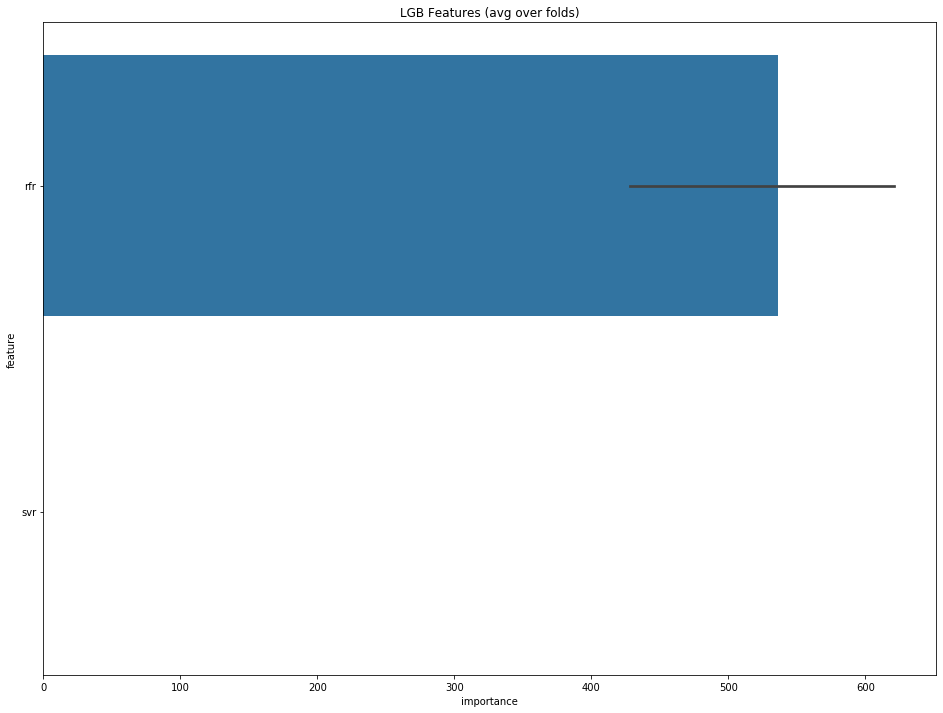

In [159]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [160]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 01:52:26 2019
Fold 1 started at Tue Dec 17 01:52:29 2019
Fold 2 started at Tue Dec 17 01:52:35 2019
Fold 3 started at Tue Dec 17 01:52:39 2019
Fold 4 started at Tue Dec 17 01:52:43 2019
Fold 5 started at Tue Dec 17 01:52:55 2019
Fold 6 started at Tue Dec 17 01:52:57 2019
Fold 7 started at Tue Dec 17 01:52:59 2019
Fold 8 started at Tue Dec 17 01:53:05 2019
Fold 9 started at Tue Dec 17 01:53:17 2019
CV mean score: 0.0059, std: 0.0025.


##### randomforest作为第二层融合模型

In [161]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 01:53:19 2019
Fold 1 started at Tue Dec 17 01:53:19 2019
Fold 2 started at Tue Dec 17 01:53:20 2019
Fold 3 started at Tue Dec 17 01:53:20 2019
Fold 4 started at Tue Dec 17 01:53:20 2019
Fold 5 started at Tue Dec 17 01:53:20 2019
Fold 6 started at Tue Dec 17 01:53:21 2019
Fold 7 started at Tue Dec 17 01:53:21 2019
Fold 8 started at Tue Dec 17 01:53:21 2019
Fold 9 started at Tue Dec 17 01:53:21 2019
CV mean score: 0.0064, std: 0.0025.


##### xgboost作为第二层融合模型

In [162]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 01:53:22 2019
[0]	train-rmse:0.550137	valid_data-rmse:0.552468
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.007484	valid_data-rmse:0.006021
Stopping. Best iteration:
[634]	train-rmse:0.005142	valid_data-rmse:0.00468

Fold 1 started at Tue Dec 17 01:53:22 2019
[0]	train-rmse:0.550162	valid_data-rmse:0.55234
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.007422	valid_data-rmse:0.007015
[1000]	train-rmse:0.003287	valid_data-rmse:0.005451
Stopping. Best iteration:
[800]	train-rmse:0.003893	valid_data-rmse:0.005349

Fold 2 started at Tue Dec 17 01:53:22 2019
[0]	train-rmse:0.550262	valid_data-rmse:0.551404
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train u

##### svr 作为第二层融合模型

In [163]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 01:53:24 2019
Fold 1 started at Tue Dec 17 01:53:24 2019
Fold 2 started at Tue Dec 17 01:53:24 2019
Fold 3 started at Tue Dec 17 01:53:24 2019
Fold 4 started at Tue Dec 17 01:53:24 2019
Fold 5 started at Tue Dec 17 01:53:24 2019
Fold 6 started at Tue Dec 17 01:53:24 2019
Fold 7 started at Tue Dec 17 01:53:24 2019
Fold 8 started at Tue Dec 17 01:53:24 2019
Fold 9 started at Tue Dec 17 01:53:24 2019
CV mean score: 0.0197, std: 0.0037.


##### 岭回归做第二层融合模型

In [164]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 01:53:24 2019
Fold 1 started at Tue Dec 17 01:53:24 2019
Fold 2 started at Tue Dec 17 01:53:24 2019
Fold 3 started at Tue Dec 17 01:53:24 2019
Fold 4 started at Tue Dec 17 01:53:24 2019
Fold 5 started at Tue Dec 17 01:53:24 2019
Fold 6 started at Tue Dec 17 01:53:24 2019
Fold 7 started at Tue Dec 17 01:53:24 2019
Fold 8 started at Tue Dec 17 01:53:24 2019
Fold 9 started at Tue Dec 17 01:53:24 2019
CV mean score: 0.0063, std: 0.0026.


#### 留下xgb和cat

In [165]:
#构建第二层训练矩阵
train_stack = np.vstack([ oof_xgb, oof_cat]).transpose()
train_stack = pd.DataFrame(train_stack, columns=[ 'xgb', 'cat'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 01:53:25 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[551]	training's rmse: 0.0062164	valid_1's rmse: 0.00278765
Fold 1 started at Tue Dec 17 01:53:25 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[575]	training's rmse: 0.00619173	valid_1's rmse: 0.00419962
Fold 2 started at Tue Dec 17 01:53:25 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[608]	training's rmse: 0.00610557	valid_1's rmse: 0.00456031
Fold 3 started at Tue Dec 17 01:53:26 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[565]	training's rmse: 0.00571826	valid_1's rmse: 0.0109756
Fold 4 started at Tue Dec 17 01:53:26 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[608]	training's rmse: 0.005399	valid_1's rmse: 0.010

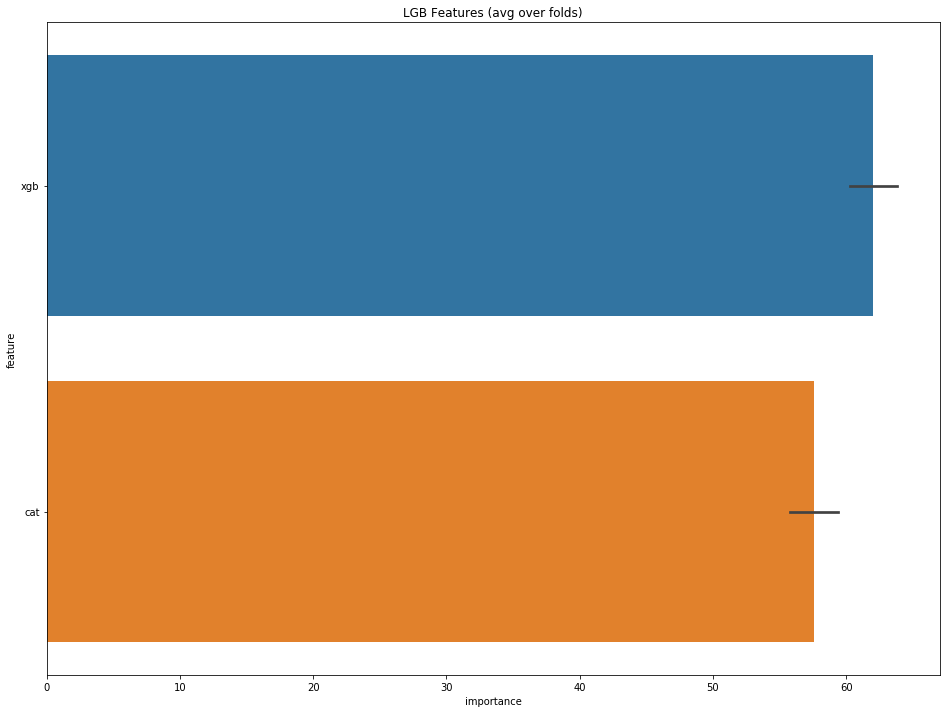

In [166]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 01:53:29 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00590565	valid_1's rmse: 0.00248225
[2000]	training's rmse: 0.00590252	valid_1's rmse: 0.00247993
[3000]	training's rmse: 0.00590252	valid_1's rmse: 0.00247993
Early stopping, best iteration is:
[3141]	training's rmse: 0.00590252	valid_1's rmse: 0.00247993
Fold 1 started at Tue Dec 17 01:53:31 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00590099	valid_1's rmse: 0.00393527
[2000]	training's rmse: 0.0058977	valid_1's rmse: 0.00393208
[3000]	training's rmse: 0.0058977	valid_1's rmse: 0.00393208
Early stopping, best iteration is:
[3712]	training's rmse: 0.0058977	valid_1's rmse: 0.00393208
Fold 2 started at Tue Dec 17 01:53:33 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00583174	valid_1's rmse: 0.00433727
[2000]	training's rmse: 0.00582815	valid_1's rmse: 0.0043

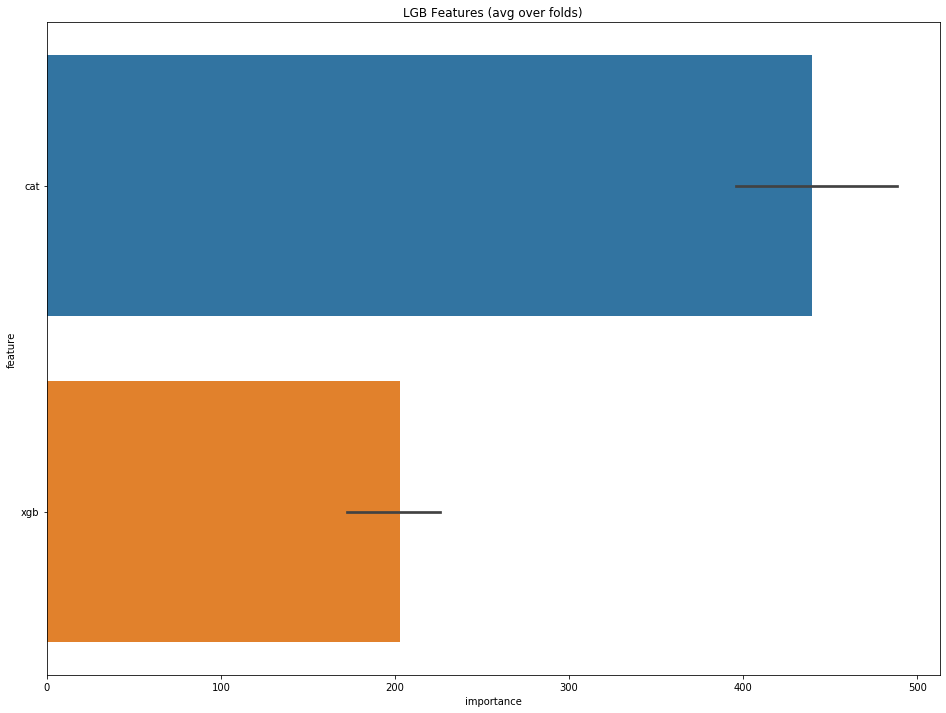

In [167]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [168]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 01:53:47 2019
Fold 1 started at Tue Dec 17 01:53:50 2019
Fold 2 started at Tue Dec 17 01:53:55 2019
Fold 3 started at Tue Dec 17 01:53:57 2019
Fold 4 started at Tue Dec 17 01:54:21 2019
Fold 5 started at Tue Dec 17 01:54:41 2019
Fold 6 started at Tue Dec 17 01:54:45 2019
Fold 7 started at Tue Dec 17 01:54:47 2019
Fold 8 started at Tue Dec 17 01:54:57 2019
Fold 9 started at Tue Dec 17 01:55:05 2019
CV mean score: 0.0031, std: 0.0024.


##### randomforest作为第二层融合模型

In [169]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 01:55:09 2019
Fold 1 started at Tue Dec 17 01:55:09 2019
Fold 2 started at Tue Dec 17 01:55:09 2019
Fold 3 started at Tue Dec 17 01:55:09 2019
Fold 4 started at Tue Dec 17 01:55:10 2019
Fold 5 started at Tue Dec 17 01:55:10 2019
Fold 6 started at Tue Dec 17 01:55:10 2019
Fold 7 started at Tue Dec 17 01:55:10 2019
Fold 8 started at Tue Dec 17 01:55:10 2019
Fold 9 started at Tue Dec 17 01:55:11 2019
CV mean score: 0.0035, std: 0.0025.


##### xgboost作为第二层融合模型

In [170]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 01:55:11 2019
[0]	train-rmse:0.550137	valid_data-rmse:0.552468
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.005051	valid_data-rmse:0.004607
Stopping. Best iteration:
[755]	train-rmse:0.001575	valid_data-rmse:0.002107

Fold 1 started at Tue Dec 17 01:55:11 2019
[0]	train-rmse:0.550162	valid_data-rmse:0.55234
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.005064	valid_data-rmse:0.00426
Stopping. Best iteration:
[752]	train-rmse:0.001564	valid_data-rmse:0.001751

Fold 2 started at Tue Dec 17 01:55:11 2019
[0]	train-rmse:0.550262	valid_data-rmse:0.551404
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.


##### svr 作为第二层融合模型

In [171]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 01:55:13 2019
Fold 1 started at Tue Dec 17 01:55:13 2019
Fold 2 started at Tue Dec 17 01:55:13 2019
Fold 3 started at Tue Dec 17 01:55:13 2019
Fold 4 started at Tue Dec 17 01:55:13 2019
Fold 5 started at Tue Dec 17 01:55:13 2019
Fold 6 started at Tue Dec 17 01:55:13 2019
Fold 7 started at Tue Dec 17 01:55:13 2019
Fold 8 started at Tue Dec 17 01:55:13 2019
Fold 9 started at Tue Dec 17 01:55:13 2019
CV mean score: 0.0197, std: 0.0037.


##### 岭回归做第二层融合模型

In [172]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 01:55:13 2019
Fold 1 started at Tue Dec 17 01:55:13 2019
Fold 2 started at Tue Dec 17 01:55:13 2019
Fold 3 started at Tue Dec 17 01:55:13 2019
Fold 4 started at Tue Dec 17 01:55:14 2019
Fold 5 started at Tue Dec 17 01:55:14 2019
Fold 6 started at Tue Dec 17 01:55:14 2019
Fold 7 started at Tue Dec 17 01:55:14 2019
Fold 8 started at Tue Dec 17 01:55:14 2019
Fold 9 started at Tue Dec 17 01:55:14 2019
CV mean score: 0.0031, std: 0.0025.


#### 留下xgb和rfr

In [173]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_xgb,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['xgb','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 01:55:14 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[654]	training's rmse: 0.00648165	valid_1's rmse: 0.00327193
Fold 1 started at Tue Dec 17 01:55:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[684]	training's rmse: 0.00645444	valid_1's rmse: 0.00460992
Fold 2 started at Tue Dec 17 01:55:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[642]	training's rmse: 0.006398	valid_1's rmse: 0.00496248
Fold 3 started at Tue Dec 17 01:55:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[697]	training's rmse: 0.00595916	valid_1's rmse: 0.0111606
Fold 4 started at Tue Dec 17 01:55:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[612]	training's rmse: 0.00563065	valid_1's rmse: 0.01

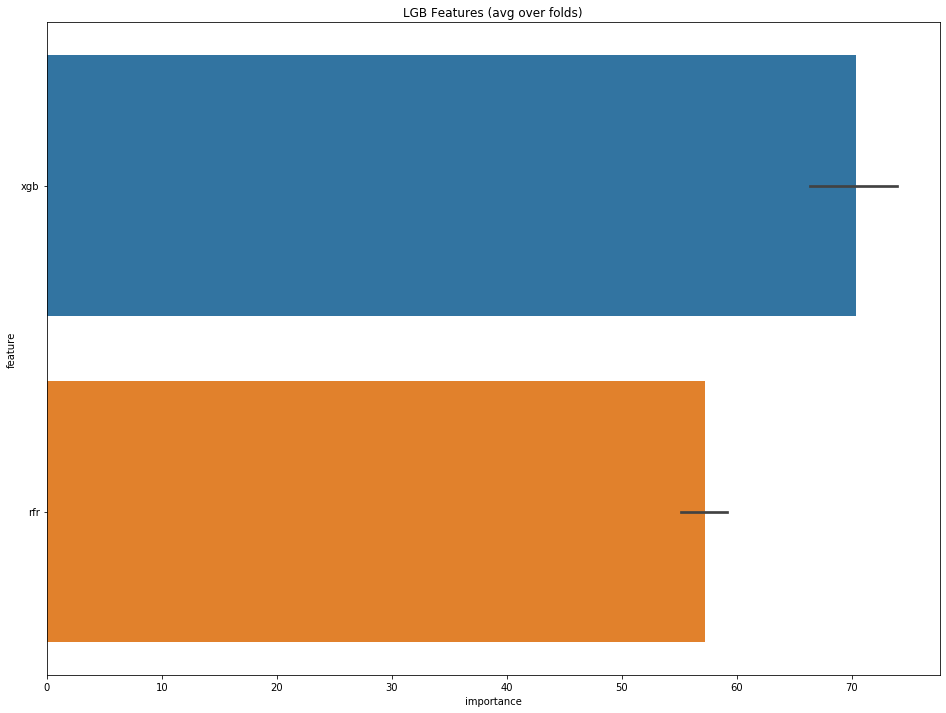

In [174]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 01:55:19 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00602688	valid_1's rmse: 0.00304076
[2000]	training's rmse: 0.00602391	valid_1's rmse: 0.00303917
Early stopping, best iteration is:
[2596]	training's rmse: 0.0060239	valid_1's rmse: 0.00303917
Fold 1 started at Tue Dec 17 01:55:20 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00604023	valid_1's rmse: 0.00415301
[2000]	training's rmse: 0.00603719	valid_1's rmse: 0.00415009
[3000]	training's rmse: 0.00603719	valid_1's rmse: 0.00415009
Early stopping, best iteration is:
[3569]	training's rmse: 0.00603719	valid_1's rmse: 0.00415009
Fold 2 started at Tue Dec 17 01:55:21 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00593512	valid_1's rmse: 0.00476781
[2000]	training's rmse: 0.00593183	valid_1's rmse: 0.00476564
Early stopping, best iteration is:
[2638]	training's rm

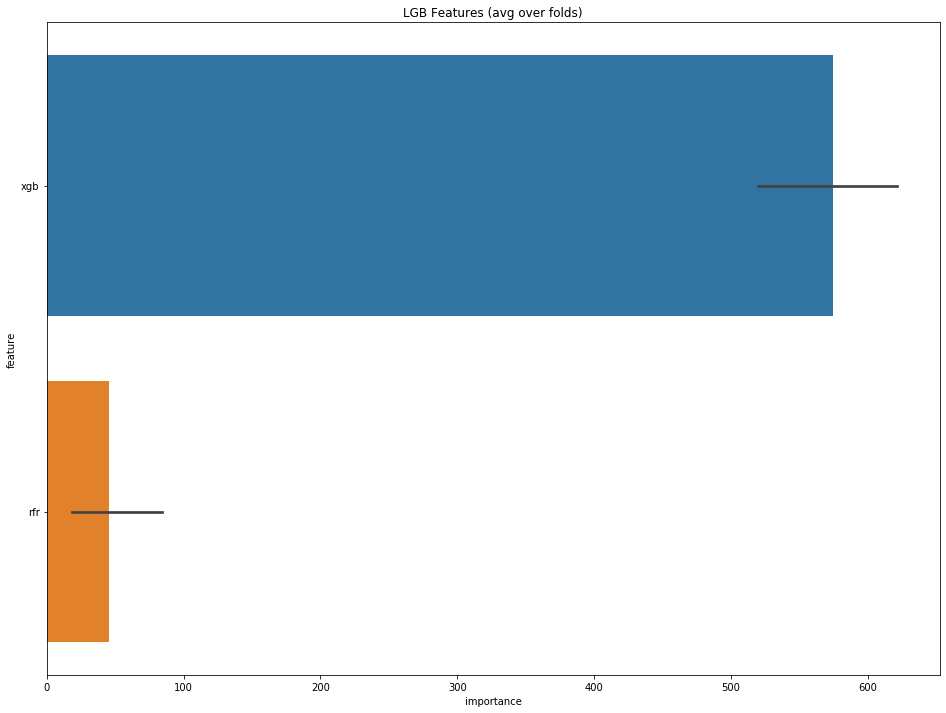

In [175]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [176]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 01:55:46 2019
Fold 1 started at Tue Dec 17 01:55:52 2019
Fold 2 started at Tue Dec 17 01:55:56 2019
Fold 3 started at Tue Dec 17 01:55:59 2019
Fold 4 started at Tue Dec 17 01:56:21 2019
Fold 5 started at Tue Dec 17 01:56:35 2019
Fold 6 started at Tue Dec 17 01:56:40 2019
Fold 7 started at Tue Dec 17 01:56:42 2019
Fold 8 started at Tue Dec 17 01:56:50 2019
Fold 9 started at Tue Dec 17 01:56:56 2019
CV mean score: 0.0038, std: 0.0023.


##### randomforest作为第二层融合模型

In [177]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 01:56:58 2019
Fold 1 started at Tue Dec 17 01:56:59 2019
Fold 2 started at Tue Dec 17 01:56:59 2019
Fold 3 started at Tue Dec 17 01:56:59 2019
Fold 4 started at Tue Dec 17 01:56:59 2019
Fold 5 started at Tue Dec 17 01:56:59 2019
Fold 6 started at Tue Dec 17 01:57:00 2019
Fold 7 started at Tue Dec 17 01:57:00 2019
Fold 8 started at Tue Dec 17 01:57:00 2019
Fold 9 started at Tue Dec 17 01:57:00 2019
CV mean score: 0.0044, std: 0.0024.


##### xgboost作为第二层融合模型

In [178]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 01:57:01 2019
[0]	train-rmse:0.550137	valid_data-rmse:0.552468
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.005499	valid_data-rmse:0.005027
Stopping. Best iteration:
[587]	train-rmse:0.003546	valid_data-rmse:0.004023

Fold 1 started at Tue Dec 17 01:57:01 2019
[0]	train-rmse:0.550162	valid_data-rmse:0.55234
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.005493	valid_data-rmse:0.004974
Stopping. Best iteration:
[674]	train-rmse:0.002584	valid_data-rmse:0.003447

Fold 2 started at Tue Dec 17 01:57:01 2019
[0]	train-rmse:0.550262	valid_data-rmse:0.551404
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.

##### svr 作为第二层融合模型

In [179]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 01:57:03 2019
Fold 1 started at Tue Dec 17 01:57:03 2019
Fold 2 started at Tue Dec 17 01:57:03 2019
Fold 3 started at Tue Dec 17 01:57:03 2019
Fold 4 started at Tue Dec 17 01:57:03 2019
Fold 5 started at Tue Dec 17 01:57:03 2019
Fold 6 started at Tue Dec 17 01:57:03 2019
Fold 7 started at Tue Dec 17 01:57:03 2019
Fold 8 started at Tue Dec 17 01:57:03 2019
Fold 9 started at Tue Dec 17 01:57:03 2019
CV mean score: 0.0197, std: 0.0037.


##### 岭回归做第二层融合模型

In [180]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 01:57:03 2019
Fold 1 started at Tue Dec 17 01:57:03 2019
Fold 2 started at Tue Dec 17 01:57:03 2019
Fold 3 started at Tue Dec 17 01:57:03 2019
Fold 4 started at Tue Dec 17 01:57:03 2019
Fold 5 started at Tue Dec 17 01:57:03 2019
Fold 6 started at Tue Dec 17 01:57:03 2019
Fold 7 started at Tue Dec 17 01:57:03 2019
Fold 8 started at Tue Dec 17 01:57:03 2019
Fold 9 started at Tue Dec 17 01:57:03 2019
CV mean score: 0.0039, std: 0.0026.


#### 留下xgb和svr

In [181]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_xgb,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['xgb', 'svr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 01:57:03 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00633966	valid_1's rmse: 0.00326347
Early stopping, best iteration is:
[1058]	training's rmse: 0.00630771	valid_1's rmse: 0.00324089
Fold 1 started at Tue Dec 17 01:57:04 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 1.05552	valid_1's rmse: 1.05321
Fold 2 started at Tue Dec 17 01:57:04 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00627766	valid_1's rmse: 0.00502226
Early stopping, best iteration is:
[1192]	training's rmse: 0.00617754	valid_1's rmse: 0.00493639
Fold 3 started at Tue Dec 17 01:57:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 1.05654	valid_1's rmse: 1.06479
Fold 4 started at Tue Dec 17 01:57:05 2019
Training until validation scores don't 

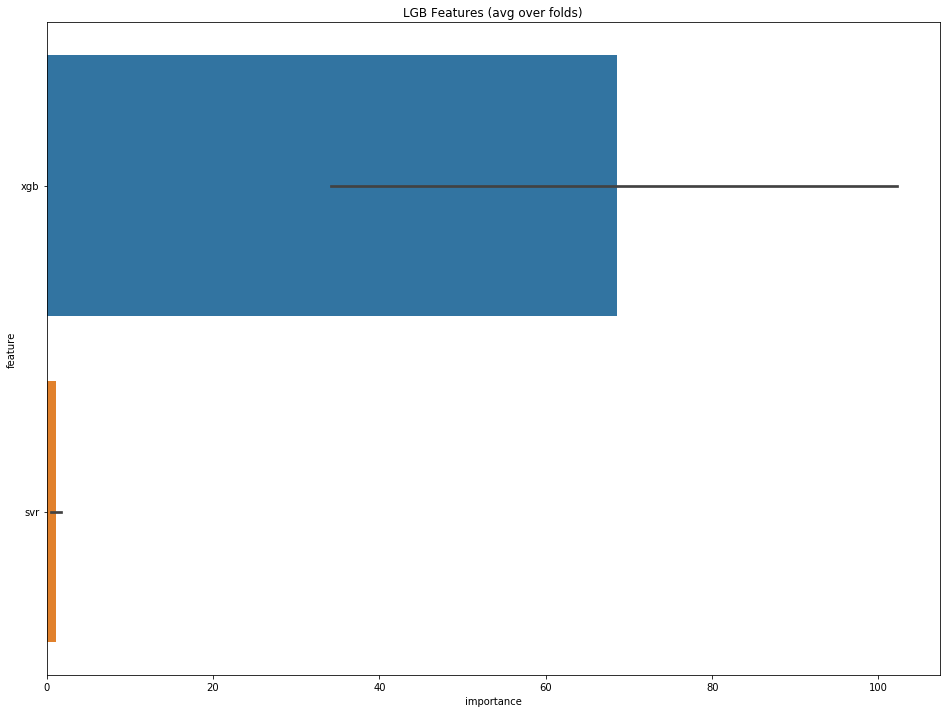

In [182]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 01:57:08 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00603363	valid_1's rmse: 0.00308439
[2000]	training's rmse: 0.00603069	valid_1's rmse: 0.00308293
[3000]	training's rmse: 0.00603069	valid_1's rmse: 0.00308293
[4000]	training's rmse: 0.00603069	valid_1's rmse: 0.00308293
Early stopping, best iteration is:
[4295]	training's rmse: 0.00603069	valid_1's rmse: 0.00308293
Fold 1 started at Tue Dec 17 01:57:11 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00603994	valid_1's rmse: 0.00414585
[2000]	training's rmse: 0.00603691	valid_1's rmse: 0.00414293
[3000]	training's rmse: 0.00603691	valid_1's rmse: 0.00414293
Early stopping, best iteration is:
[3556]	training's rmse: 0.00603691	valid_1's rmse: 0.00414293
Fold 2 started at Tue Dec 17 01:57:12 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00594846	valid_1's rmse: 0.0

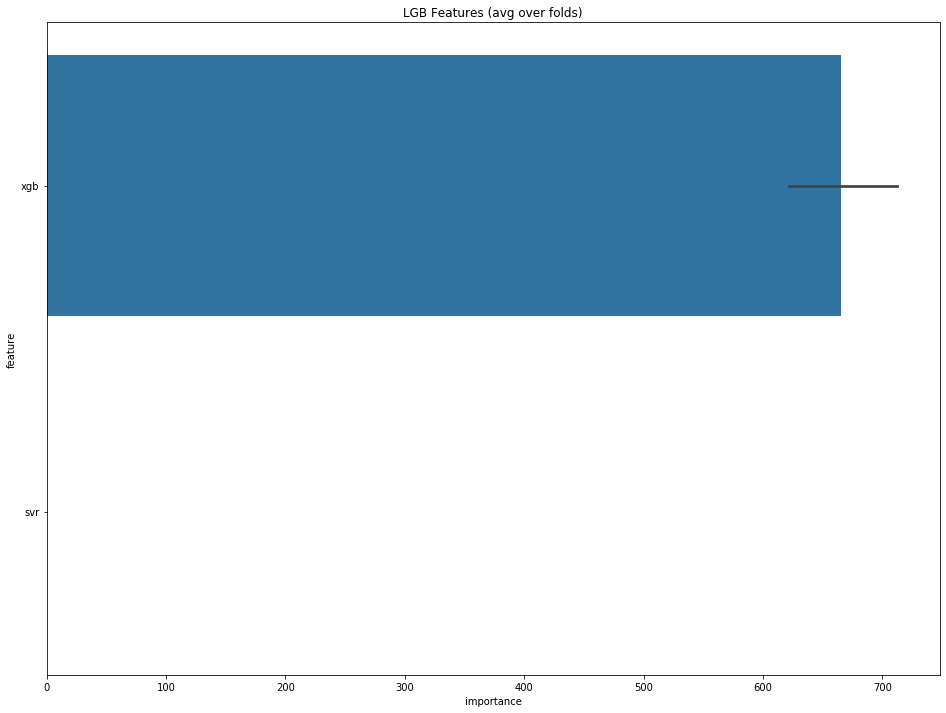

In [183]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [184]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 01:57:26 2019
Fold 1 started at Tue Dec 17 01:57:29 2019
Fold 2 started at Tue Dec 17 01:57:32 2019
Fold 3 started at Tue Dec 17 01:57:34 2019
Fold 4 started at Tue Dec 17 01:57:52 2019
Fold 5 started at Tue Dec 17 01:58:08 2019
Fold 6 started at Tue Dec 17 01:58:30 2019
Fold 7 started at Tue Dec 17 01:58:33 2019
Fold 8 started at Tue Dec 17 01:58:50 2019
Fold 9 started at Tue Dec 17 01:58:58 2019
CV mean score: 0.0032, std: 0.0025.


##### randomforest作为第二层融合模型

In [185]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 01:59:03 2019
Fold 1 started at Tue Dec 17 01:59:03 2019
Fold 2 started at Tue Dec 17 01:59:03 2019
Fold 3 started at Tue Dec 17 01:59:03 2019
Fold 4 started at Tue Dec 17 01:59:03 2019
Fold 5 started at Tue Dec 17 01:59:04 2019
Fold 6 started at Tue Dec 17 01:59:04 2019
Fold 7 started at Tue Dec 17 01:59:04 2019
Fold 8 started at Tue Dec 17 01:59:04 2019
Fold 9 started at Tue Dec 17 01:59:05 2019
CV mean score: 0.0038, std: 0.0025.


##### xgboost作为第二层融合模型

In [186]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 01:59:05 2019
[0]	train-rmse:0.550137	valid_data-rmse:0.552468
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.006186	valid_data-rmse:0.005107
Stopping. Best iteration:
[759]	train-rmse:0.00275	valid_data-rmse:0.002765

Fold 1 started at Tue Dec 17 01:59:05 2019
[0]	train-rmse:0.550162	valid_data-rmse:0.55234
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.006178	valid_data-rmse:0.005199
Stopping. Best iteration:
[781]	train-rmse:0.002573	valid_data-rmse:0.002635

Fold 2 started at Tue Dec 17 01:59:05 2019
[0]	train-rmse:0.550262	valid_data-rmse:0.551404
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.


##### svr 作为第二层融合模型

In [187]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 01:59:07 2019
Fold 1 started at Tue Dec 17 01:59:07 2019
Fold 2 started at Tue Dec 17 01:59:07 2019
Fold 3 started at Tue Dec 17 01:59:07 2019
Fold 4 started at Tue Dec 17 01:59:07 2019
Fold 5 started at Tue Dec 17 01:59:07 2019
Fold 6 started at Tue Dec 17 01:59:07 2019
Fold 7 started at Tue Dec 17 01:59:07 2019
Fold 8 started at Tue Dec 17 01:59:07 2019
Fold 9 started at Tue Dec 17 01:59:07 2019
CV mean score: 0.0197, std: 0.0037.


##### 岭回归做第二层融合模型

In [188]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 01:59:07 2019
Fold 1 started at Tue Dec 17 01:59:07 2019
Fold 2 started at Tue Dec 17 01:59:08 2019
Fold 3 started at Tue Dec 17 01:59:08 2019
Fold 4 started at Tue Dec 17 01:59:08 2019
Fold 5 started at Tue Dec 17 01:59:08 2019
Fold 6 started at Tue Dec 17 01:59:08 2019
Fold 7 started at Tue Dec 17 01:59:08 2019
Fold 8 started at Tue Dec 17 01:59:08 2019
Fold 9 started at Tue Dec 17 01:59:08 2019
CV mean score: 0.0038, std: 0.0024.


#### 留下lgb和cat

In [189]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_cat, oof_lgb_1, oof_lgb_2]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb',  'cat', 'lgb_1', 'lgb_2'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 01:59:08 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[550]	training's rmse: 0.00621362	valid_1's rmse: 0.00274222
Fold 1 started at Tue Dec 17 01:59:09 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[575]	training's rmse: 0.00619912	valid_1's rmse: 0.00420346
Fold 2 started at Tue Dec 17 01:59:09 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[507]	training's rmse: 0.00621985	valid_1's rmse: 0.0046105
Fold 3 started at Tue Dec 17 01:59:10 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[539]	training's rmse: 0.0057667	valid_1's rmse: 0.0109089
Fold 4 started at Tue Dec 17 01:59:10 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[529]	training's rmse: 0.00546084	valid_1's rmse: 0.01

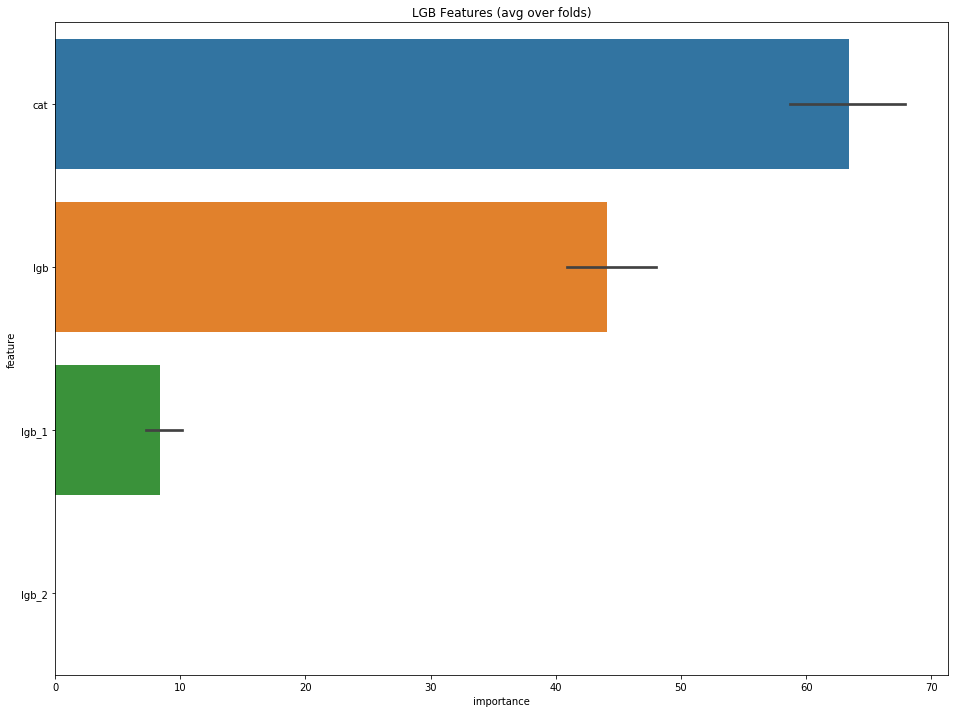

In [190]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 01:59:13 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00592148	valid_1's rmse: 0.0025264
[2000]	training's rmse: 0.00591774	valid_1's rmse: 0.00252451
Early stopping, best iteration is:
[2511]	training's rmse: 0.00591774	valid_1's rmse: 0.0025245
Fold 1 started at Tue Dec 17 01:59:15 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00592944	valid_1's rmse: 0.00392323
[2000]	training's rmse: 0.00592556	valid_1's rmse: 0.00391951
[3000]	training's rmse: 0.00592556	valid_1's rmse: 0.00391951
[4000]	training's rmse: 0.00592556	valid_1's rmse: 0.00391951
Early stopping, best iteration is:
[4363]	training's rmse: 0.00592556	valid_1's rmse: 0.00391951
Fold 2 started at Tue Dec 17 01:59:17 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00587783	valid_1's rmse: 0.00431093
[2000]	training's rmse: 0.00587397	valid_1's rmse: 0.004

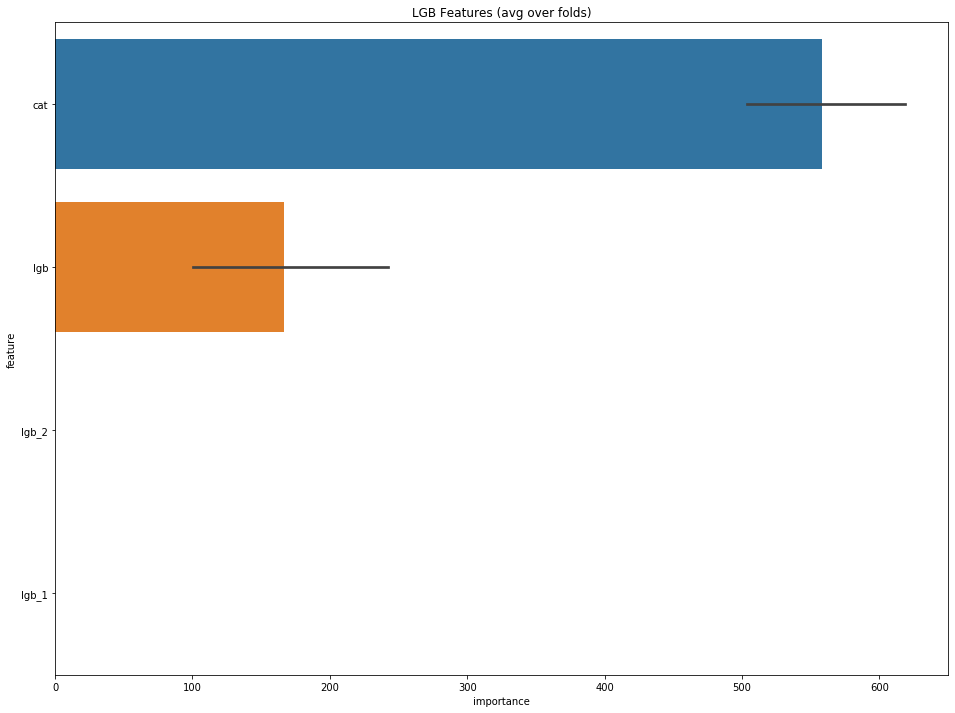

In [191]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [192]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 01:59:44 2019
Fold 1 started at Tue Dec 17 01:59:50 2019
Fold 2 started at Tue Dec 17 02:00:10 2019
Fold 3 started at Tue Dec 17 02:00:18 2019
Fold 4 started at Tue Dec 17 02:00:32 2019
Fold 5 started at Tue Dec 17 02:00:46 2019
Fold 6 started at Tue Dec 17 02:00:50 2019
Fold 7 started at Tue Dec 17 02:00:52 2019
Fold 8 started at Tue Dec 17 02:01:02 2019
Fold 9 started at Tue Dec 17 02:01:09 2019
CV mean score: 0.0035, std: 0.0024.


##### randomforest作为第二层融合模型

In [193]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 02:01:12 2019
Fold 1 started at Tue Dec 17 02:01:12 2019
Fold 2 started at Tue Dec 17 02:01:12 2019
Fold 3 started at Tue Dec 17 02:01:12 2019
Fold 4 started at Tue Dec 17 02:01:13 2019
Fold 5 started at Tue Dec 17 02:01:13 2019
Fold 6 started at Tue Dec 17 02:01:13 2019
Fold 7 started at Tue Dec 17 02:01:13 2019
Fold 8 started at Tue Dec 17 02:01:14 2019
Fold 9 started at Tue Dec 17 02:01:14 2019
CV mean score: 0.0044, std: 0.0025.


##### xgboost作为第二层融合模型

In [194]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 02:01:14 2019
[0]	train-rmse:0.550137	valid_data-rmse:0.552468
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.005058	valid_data-rmse:0.004472
[1000]	train-rmse:0.001083	valid_data-rmse:0.001437
Stopping. Best iteration:
[1186]	train-rmse:0.000941	valid_data-rmse:0.001413

Fold 1 started at Tue Dec 17 02:01:14 2019
[0]	train-rmse:0.550162	valid_data-rmse:0.55234
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.005082	valid_data-rmse:0.004365
[1000]	train-rmse:0.001055	valid_data-rmse:0.001722
Stopping. Best iteration:
[866]	train-rmse:0.001261	valid_data-rmse:0.001705

Fold 2 started at Tue Dec 17 02:01:15 2019
[0]	train-rmse:0.550262	valid_data-rmse:0.551404
Multiple eval metrics have been passed: 'valid_dat

##### svr 作为第二层融合模型

In [195]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 02:01:17 2019
Fold 1 started at Tue Dec 17 02:01:17 2019
Fold 2 started at Tue Dec 17 02:01:17 2019
Fold 3 started at Tue Dec 17 02:01:17 2019
Fold 4 started at Tue Dec 17 02:01:17 2019
Fold 5 started at Tue Dec 17 02:01:17 2019
Fold 6 started at Tue Dec 17 02:01:17 2019
Fold 7 started at Tue Dec 17 02:01:17 2019
Fold 8 started at Tue Dec 17 02:01:17 2019
Fold 9 started at Tue Dec 17 02:01:17 2019
CV mean score: 0.0197, std: 0.0037.


##### 岭回归做第二层融合模型

In [196]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 02:01:17 2019
Fold 1 started at Tue Dec 17 02:01:17 2019
Fold 2 started at Tue Dec 17 02:01:17 2019
Fold 3 started at Tue Dec 17 02:01:17 2019
Fold 4 started at Tue Dec 17 02:01:17 2019
Fold 5 started at Tue Dec 17 02:01:17 2019
Fold 6 started at Tue Dec 17 02:01:18 2019
Fold 7 started at Tue Dec 17 02:01:18 2019
Fold 8 started at Tue Dec 17 02:01:18 2019
Fold 9 started at Tue Dec 17 02:01:18 2019
CV mean score: 0.0041, std: 0.0026.


#### 留下lgb和rfr

In [197]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb,  oof_lgb_1, oof_lgb_2,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb',  'lgb_1', 'lgb_2','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 02:01:18 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[550]	training's rmse: 0.00632448	valid_1's rmse: 0.00321641
Fold 1 started at Tue Dec 17 02:01:18 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[575]	training's rmse: 0.00629917	valid_1's rmse: 0.00440049
Fold 2 started at Tue Dec 17 02:01:19 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[507]	training's rmse: 0.0063258	valid_1's rmse: 0.00476592
Fold 3 started at Tue Dec 17 02:01:19 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[539]	training's rmse: 0.00589528	valid_1's rmse: 0.0108901
Fold 4 started at Tue Dec 17 02:01:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[529]	training's rmse: 0.00550324	valid_1's rmse: 0.0

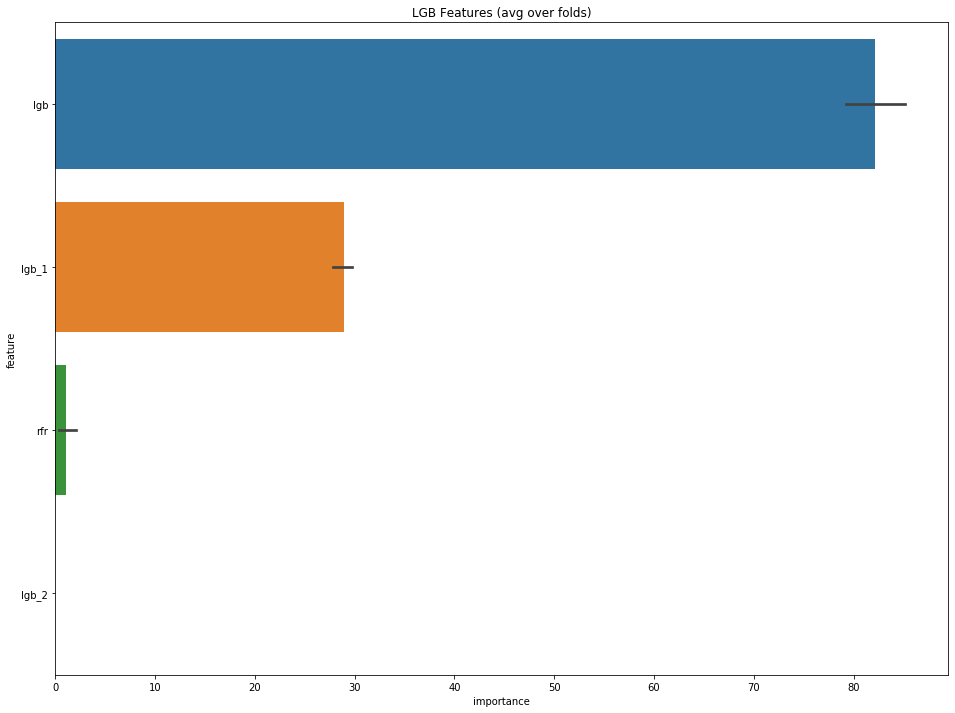

In [198]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 02:01:23 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00610014	valid_1's rmse: 0.00311819
[2000]	training's rmse: 0.00609758	valid_1's rmse: 0.00311725
[3000]	training's rmse: 0.00609758	valid_1's rmse: 0.00311725
Early stopping, best iteration is:
[3434]	training's rmse: 0.00609758	valid_1's rmse: 0.00311725
Fold 1 started at Tue Dec 17 02:01:25 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00608123	valid_1's rmse: 0.00418015
[2000]	training's rmse: 0.00607828	valid_1's rmse: 0.00417735
[3000]	training's rmse: 0.00607828	valid_1's rmse: 0.00417735
Early stopping, best iteration is:
[2862]	training's rmse: 0.00607828	valid_1's rmse: 0.00417735
Fold 2 started at Tue Dec 17 02:01:26 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00604474	valid_1's rmse: 0.00452251
[2000]	training's rmse: 0.00604216	valid_1's rmse: 0.0

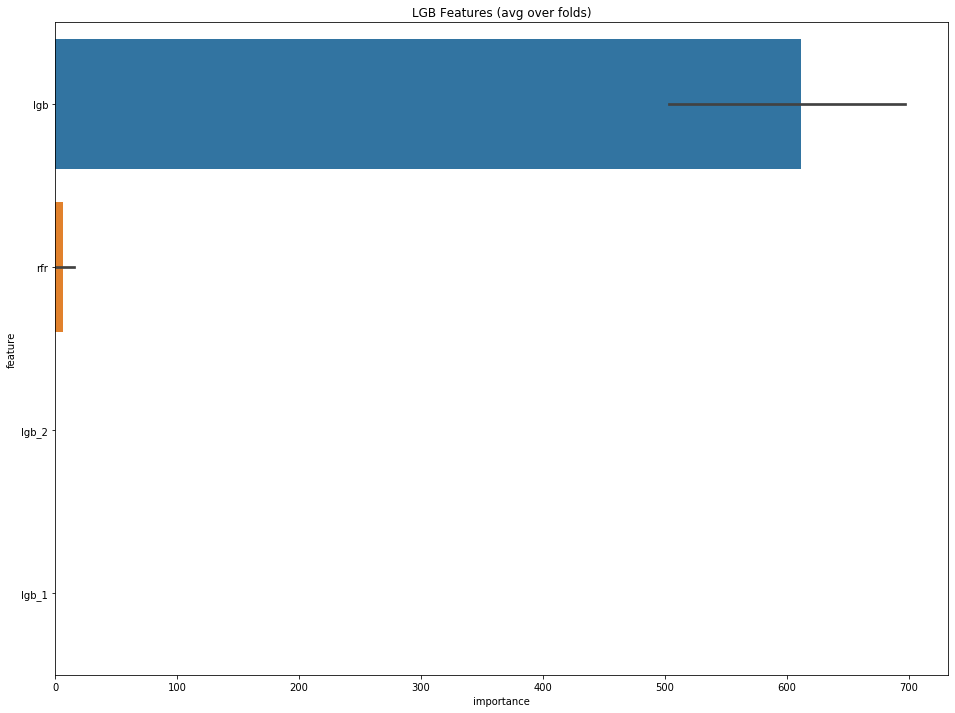

In [199]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [200]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 02:01:42 2019
Fold 1 started at Tue Dec 17 02:01:45 2019
Fold 2 started at Tue Dec 17 02:02:11 2019
Fold 3 started at Tue Dec 17 02:02:33 2019
Fold 4 started at Tue Dec 17 02:02:36 2019
Fold 5 started at Tue Dec 17 02:02:47 2019
Fold 6 started at Tue Dec 17 02:02:48 2019
Fold 7 started at Tue Dec 17 02:02:49 2019
Fold 8 started at Tue Dec 17 02:03:14 2019
Fold 9 started at Tue Dec 17 02:03:25 2019
CV mean score: 0.0044, std: 0.0027.


##### randomforest作为第二层融合模型

In [201]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 02:03:27 2019
Fold 1 started at Tue Dec 17 02:03:27 2019
Fold 2 started at Tue Dec 17 02:03:27 2019
Fold 3 started at Tue Dec 17 02:03:27 2019
Fold 4 started at Tue Dec 17 02:03:28 2019
Fold 5 started at Tue Dec 17 02:03:28 2019
Fold 6 started at Tue Dec 17 02:03:28 2019
Fold 7 started at Tue Dec 17 02:03:28 2019
Fold 8 started at Tue Dec 17 02:03:29 2019
Fold 9 started at Tue Dec 17 02:03:29 2019
CV mean score: 0.0049, std: 0.0025.


##### xgboost作为第二层融合模型

In [202]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 02:03:29 2019
[0]	train-rmse:0.550137	valid_data-rmse:0.552468
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.005498	valid_data-rmse:0.005116
Stopping. Best iteration:
[585]	train-rmse:0.003542	valid_data-rmse:0.004214

Fold 1 started at Tue Dec 17 02:03:29 2019
[0]	train-rmse:0.550162	valid_data-rmse:0.55234
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.005504	valid_data-rmse:0.004551
[1000]	train-rmse:0.001365	valid_data-rmse:0.002662
Stopping. Best iteration:
[875]	train-rmse:0.00165	valid_data-rmse:0.002635

Fold 2 started at Tue Dec 17 02:03:30 2019
[0]	train-rmse:0.550262	valid_data-rmse:0.551404
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train u

##### svr 作为第二层融合模型

In [203]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 02:03:32 2019
Fold 1 started at Tue Dec 17 02:03:32 2019
Fold 2 started at Tue Dec 17 02:03:32 2019
Fold 3 started at Tue Dec 17 02:03:32 2019
Fold 4 started at Tue Dec 17 02:03:32 2019
Fold 5 started at Tue Dec 17 02:03:32 2019
Fold 6 started at Tue Dec 17 02:03:32 2019
Fold 7 started at Tue Dec 17 02:03:32 2019
Fold 8 started at Tue Dec 17 02:03:32 2019
Fold 9 started at Tue Dec 17 02:03:32 2019
CV mean score: 0.0197, std: 0.0037.


##### 岭回归做第二层融合模型

In [204]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 02:03:32 2019
Fold 1 started at Tue Dec 17 02:03:32 2019
Fold 2 started at Tue Dec 17 02:03:32 2019
Fold 3 started at Tue Dec 17 02:03:32 2019
Fold 4 started at Tue Dec 17 02:03:32 2019
Fold 5 started at Tue Dec 17 02:03:32 2019
Fold 6 started at Tue Dec 17 02:03:32 2019
Fold 7 started at Tue Dec 17 02:03:32 2019
Fold 8 started at Tue Dec 17 02:03:33 2019
Fold 9 started at Tue Dec 17 02:03:33 2019
CV mean score: 0.0050, std: 0.0028.


#### 留下lgb和svr

In [205]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb,  oof_lgb_1, oof_lgb_2,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb',  'lgb_1', 'lgb_2','svr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 02:03:33 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[550]	training's rmse: 0.00632448	valid_1's rmse: 0.00321641
Fold 1 started at Tue Dec 17 02:03:34 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[575]	training's rmse: 0.00629993	valid_1's rmse: 0.00439966
Fold 2 started at Tue Dec 17 02:03:35 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[507]	training's rmse: 0.00632586	valid_1's rmse: 0.00476732
Fold 3 started at Tue Dec 17 02:03:35 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[539]	training's rmse: 0.00589601	valid_1's rmse: 0.0108907
Fold 4 started at Tue Dec 17 02:03:36 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[529]	training's rmse: 0.00550331	valid_1's rmse: 0.

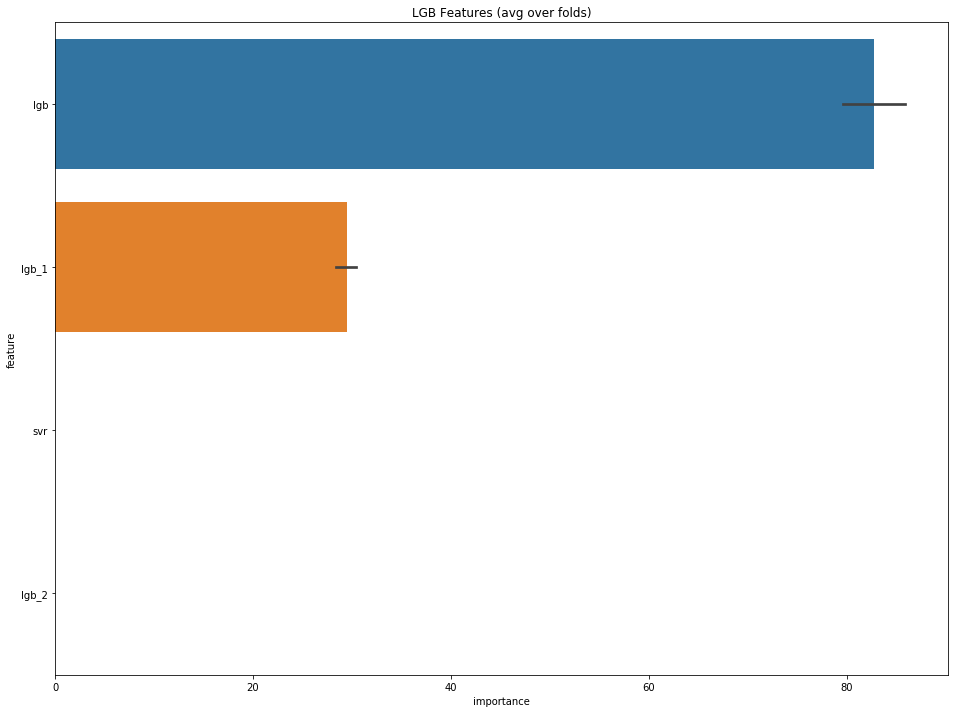

In [206]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 02:03:39 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00610014	valid_1's rmse: 0.00311819
[2000]	training's rmse: 0.00609758	valid_1's rmse: 0.00311725
[3000]	training's rmse: 0.00609758	valid_1's rmse: 0.00311725
Early stopping, best iteration is:
[3434]	training's rmse: 0.00609758	valid_1's rmse: 0.00311725
Fold 1 started at Tue Dec 17 02:03:41 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00608123	valid_1's rmse: 0.00418015
[2000]	training's rmse: 0.00607828	valid_1's rmse: 0.00417735
[3000]	training's rmse: 0.00607828	valid_1's rmse: 0.00417735
Early stopping, best iteration is:
[2862]	training's rmse: 0.00607828	valid_1's rmse: 0.00417735
Fold 2 started at Tue Dec 17 02:03:42 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00604474	valid_1's rmse: 0.00452251
[2000]	training's rmse: 0.00604216	valid_1's rmse: 0.0

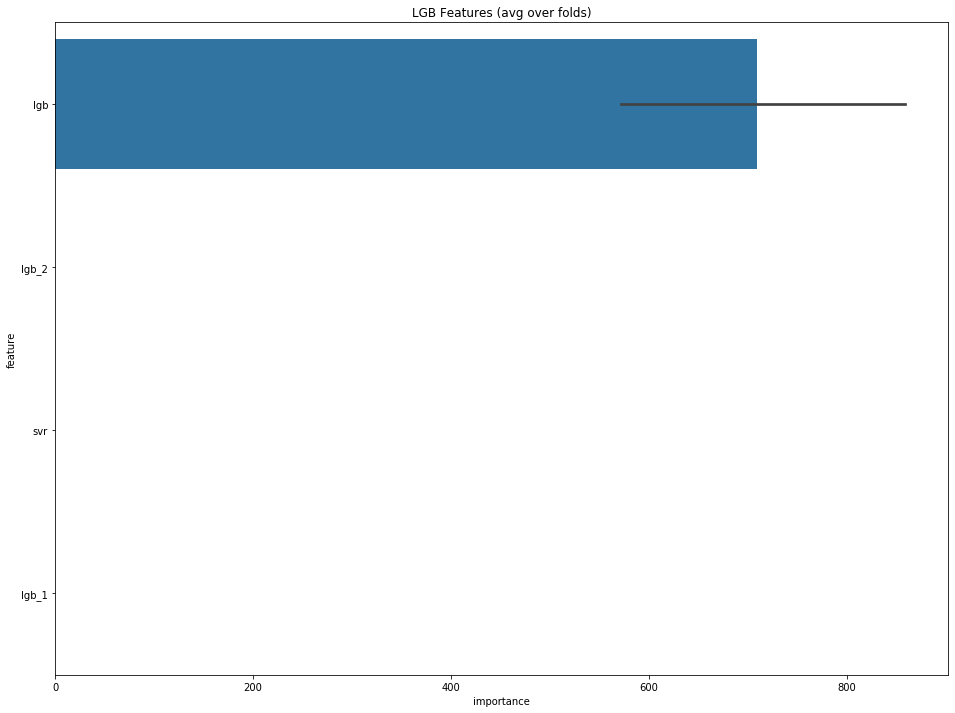

In [207]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [208]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 02:04:02 2019
Fold 1 started at Tue Dec 17 02:04:06 2019
Fold 2 started at Tue Dec 17 02:04:09 2019
Fold 3 started at Tue Dec 17 02:04:13 2019
Fold 4 started at Tue Dec 17 02:04:17 2019
Fold 5 started at Tue Dec 17 02:04:23 2019
Fold 6 started at Tue Dec 17 02:04:24 2019
Fold 7 started at Tue Dec 17 02:04:27 2019
Fold 8 started at Tue Dec 17 02:04:31 2019
Fold 9 started at Tue Dec 17 02:04:35 2019
CV mean score: 0.0047, std: 0.0027.


##### randomforest作为第二层融合模型

In [209]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 02:04:37 2019
Fold 1 started at Tue Dec 17 02:04:38 2019
Fold 2 started at Tue Dec 17 02:04:38 2019
Fold 3 started at Tue Dec 17 02:04:38 2019
Fold 4 started at Tue Dec 17 02:04:38 2019
Fold 5 started at Tue Dec 17 02:04:39 2019
Fold 6 started at Tue Dec 17 02:04:39 2019
Fold 7 started at Tue Dec 17 02:04:39 2019
Fold 8 started at Tue Dec 17 02:04:39 2019
Fold 9 started at Tue Dec 17 02:04:40 2019
CV mean score: 0.0050, std: 0.0025.


##### xgboost作为第二层融合模型

In [210]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 02:04:40 2019
[0]	train-rmse:0.550137	valid_data-rmse:0.552468
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.006001	valid_data-rmse:0.005361
Stopping. Best iteration:
[641]	train-rmse:0.003857	valid_data-rmse:0.004014

Fold 1 started at Tue Dec 17 02:04:40 2019
[0]	train-rmse:0.550162	valid_data-rmse:0.55234
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.005936	valid_data-rmse:0.004536
Stopping. Best iteration:
[629]	train-rmse:0.003847	valid_data-rmse:0.003479

Fold 2 started at Tue Dec 17 02:04:40 2019
[0]	train-rmse:0.550262	valid_data-rmse:0.551404
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.

##### svr 作为第二层融合模型

In [211]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 02:04:41 2019
Fold 1 started at Tue Dec 17 02:04:41 2019
Fold 2 started at Tue Dec 17 02:04:41 2019
Fold 3 started at Tue Dec 17 02:04:41 2019
Fold 4 started at Tue Dec 17 02:04:41 2019
Fold 5 started at Tue Dec 17 02:04:41 2019
Fold 6 started at Tue Dec 17 02:04:41 2019
Fold 7 started at Tue Dec 17 02:04:41 2019
Fold 8 started at Tue Dec 17 02:04:41 2019
Fold 9 started at Tue Dec 17 02:04:41 2019
CV mean score: 0.0197, std: 0.0037.


##### 岭回归做第二层融合模型

In [212]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 02:04:41 2019
Fold 1 started at Tue Dec 17 02:04:41 2019
Fold 2 started at Tue Dec 17 02:04:42 2019
Fold 3 started at Tue Dec 17 02:04:42 2019
Fold 4 started at Tue Dec 17 02:04:42 2019
Fold 5 started at Tue Dec 17 02:04:42 2019
Fold 6 started at Tue Dec 17 02:04:42 2019
Fold 7 started at Tue Dec 17 02:04:42 2019
Fold 8 started at Tue Dec 17 02:04:42 2019
Fold 9 started at Tue Dec 17 02:04:42 2019
CV mean score: 0.0051, std: 0.0029.


#### 留下lgb和xgb

In [213]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb,  oof_lgb_1, oof_lgb_2,oof_xgb]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb',  'lgb_1', 'lgb_2','xgb'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 02:04:42 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[551]	training's rmse: 0.00623949	valid_1's rmse: 0.00306463
Fold 1 started at Tue Dec 17 02:04:43 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[575]	training's rmse: 0.00623014	valid_1's rmse: 0.00431032
Fold 2 started at Tue Dec 17 02:04:44 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[506]	training's rmse: 0.00622586	valid_1's rmse: 0.00488369
Fold 3 started at Tue Dec 17 02:04:44 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[539]	training's rmse: 0.00581347	valid_1's rmse: 0.0109566
Fold 4 started at Tue Dec 17 02:04:45 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[529]	training's rmse: 0.00542021	valid_1's rmse: 0.

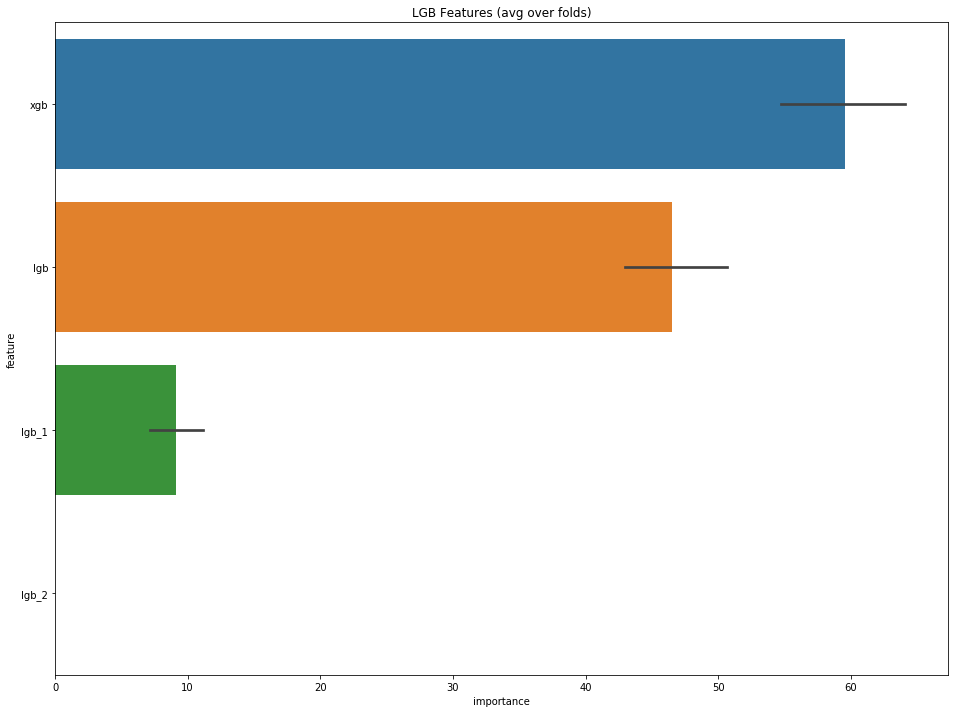

In [214]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 02:04:50 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0059948	valid_1's rmse: 0.0029194
[2000]	training's rmse: 0.00599193	valid_1's rmse: 0.00291763
[3000]	training's rmse: 0.00599193	valid_1's rmse: 0.00291763
[4000]	training's rmse: 0.00599193	valid_1's rmse: 0.00291763
Early stopping, best iteration is:
[4207]	training's rmse: 0.00599193	valid_1's rmse: 0.00291763
Fold 1 started at Tue Dec 17 02:04:54 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00599353	valid_1's rmse: 0.00410325
[2000]	training's rmse: 0.00599017	valid_1's rmse: 0.00409991
[3000]	training's rmse: 0.00599017	valid_1's rmse: 0.0040999
[4000]	training's rmse: 0.00599017	valid_1's rmse: 0.0040999
[5000]	training's rmse: 0.00599017	valid_1's rmse: 0.0040999
Early stopping, best iteration is:
[4916]	training's rmse: 0.00599017	valid_1's rmse: 0.0040999
Fold 2 started at Tue Dec 17 02:04:59 2019

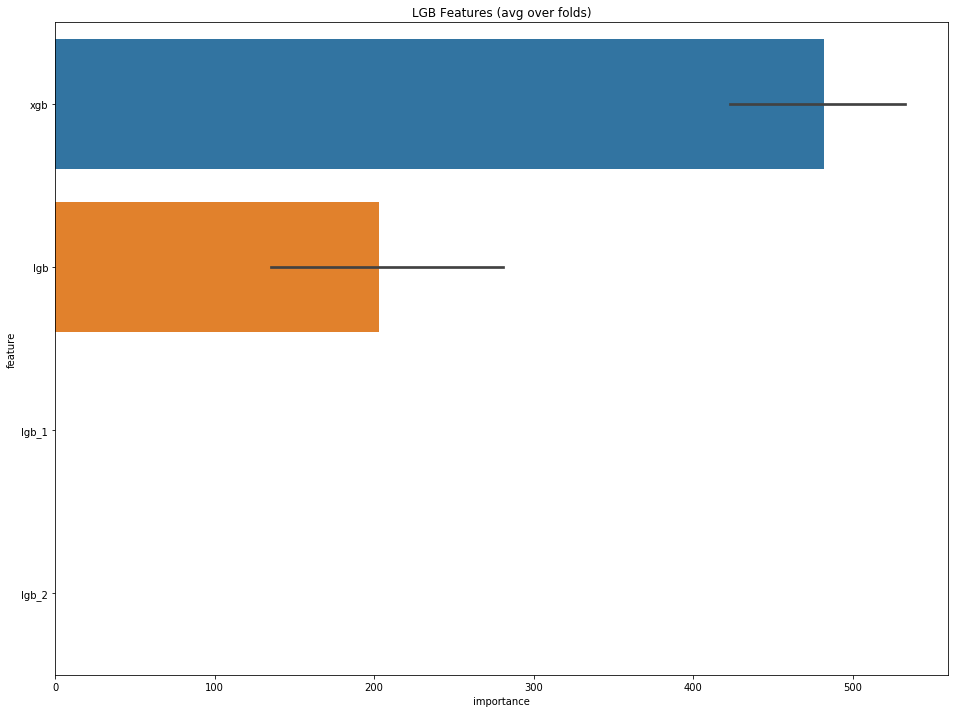

In [215]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [216]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 02:05:39 2019
Fold 1 started at Tue Dec 17 02:05:43 2019
Fold 2 started at Tue Dec 17 02:05:55 2019
Fold 3 started at Tue Dec 17 02:05:58 2019
Fold 4 started at Tue Dec 17 02:06:24 2019
Fold 5 started at Tue Dec 17 02:06:39 2019
Fold 6 started at Tue Dec 17 02:06:42 2019
Fold 7 started at Tue Dec 17 02:06:45 2019
Fold 8 started at Tue Dec 17 02:06:59 2019
Fold 9 started at Tue Dec 17 02:07:05 2019
CV mean score: 0.0034, std: 0.0023.


##### randomforest作为第二层融合模型

In [217]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 02:07:08 2019
Fold 1 started at Tue Dec 17 02:07:08 2019
Fold 2 started at Tue Dec 17 02:07:08 2019
Fold 3 started at Tue Dec 17 02:07:09 2019
Fold 4 started at Tue Dec 17 02:07:09 2019
Fold 5 started at Tue Dec 17 02:07:09 2019
Fold 6 started at Tue Dec 17 02:07:09 2019
Fold 7 started at Tue Dec 17 02:07:10 2019
Fold 8 started at Tue Dec 17 02:07:10 2019
Fold 9 started at Tue Dec 17 02:07:10 2019
CV mean score: 0.0043, std: 0.0025.


##### xgboost作为第二层融合模型

In [218]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 02:07:10 2019
[0]	train-rmse:0.550137	valid_data-rmse:0.552468
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.005114	valid_data-rmse:0.004113
Stopping. Best iteration:
[684]	train-rmse:0.002063	valid_data-rmse:0.001563

Fold 1 started at Tue Dec 17 02:07:11 2019
[0]	train-rmse:0.550162	valid_data-rmse:0.55234
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.005087	valid_data-rmse:0.003998
[1000]	train-rmse:0.001008	valid_data-rmse:0.001537
Stopping. Best iteration:
[870]	train-rmse:0.001192	valid_data-rmse:0.00153

Fold 2 started at Tue Dec 17 02:07:11 2019
[0]	train-rmse:0.550262	valid_data-rmse:0.551404
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train u

##### svr 作为第二层融合模型

In [219]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 02:07:13 2019
Fold 1 started at Tue Dec 17 02:07:13 2019
Fold 2 started at Tue Dec 17 02:07:13 2019
Fold 3 started at Tue Dec 17 02:07:13 2019
Fold 4 started at Tue Dec 17 02:07:13 2019
Fold 5 started at Tue Dec 17 02:07:13 2019
Fold 6 started at Tue Dec 17 02:07:13 2019
Fold 7 started at Tue Dec 17 02:07:13 2019
Fold 8 started at Tue Dec 17 02:07:13 2019
Fold 9 started at Tue Dec 17 02:07:13 2019
CV mean score: 0.0197, std: 0.0037.


##### 岭回归做第二层融合模型

In [220]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 02:07:13 2019
Fold 1 started at Tue Dec 17 02:07:13 2019
Fold 2 started at Tue Dec 17 02:07:13 2019
Fold 3 started at Tue Dec 17 02:07:14 2019
Fold 4 started at Tue Dec 17 02:07:14 2019
Fold 5 started at Tue Dec 17 02:07:14 2019
Fold 6 started at Tue Dec 17 02:07:14 2019
Fold 7 started at Tue Dec 17 02:07:14 2019
Fold 8 started at Tue Dec 17 02:07:14 2019
Fold 9 started at Tue Dec 17 02:07:14 2019
CV mean score: 0.0039, std: 0.0027.


#### 只留下cat

In [221]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_cat]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['cat'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 02:07:14 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[551]	training's rmse: 0.0062503	valid_1's rmse: 0.00275722
Fold 1 started at Tue Dec 17 02:07:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[575]	training's rmse: 0.00622419	valid_1's rmse: 0.00415824
Fold 2 started at Tue Dec 17 02:07:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[507]	training's rmse: 0.00624891	valid_1's rmse: 0.00462918
Fold 3 started at Tue Dec 17 02:07:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[539]	training's rmse: 0.00580181	valid_1's rmse: 0.0109278
Fold 4 started at Tue Dec 17 02:07:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[529]	training's rmse: 0.00552216	valid_1's rmse: 0.0

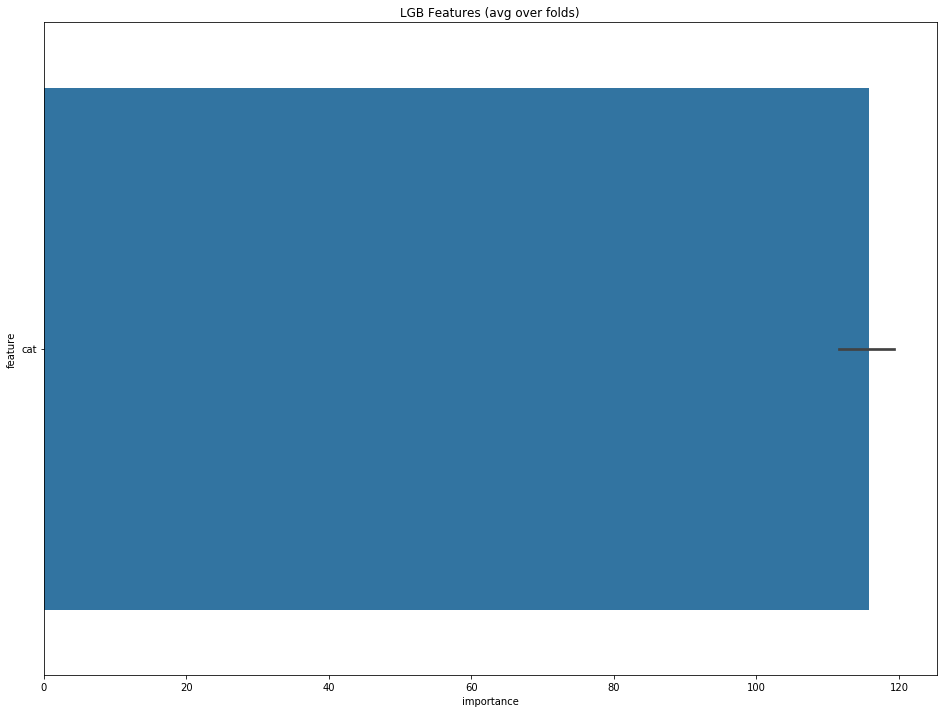

In [222]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 02:07:19 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00595873	valid_1's rmse: 0.00251597
[2000]	training's rmse: 0.00595491	valid_1's rmse: 0.00251386
Early stopping, best iteration is:
[2518]	training's rmse: 0.00595491	valid_1's rmse: 0.00251386
Fold 1 started at Tue Dec 17 02:07:20 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0059541	valid_1's rmse: 0.00387004
[2000]	training's rmse: 0.00595022	valid_1's rmse: 0.00386635
[3000]	training's rmse: 0.00595021	valid_1's rmse: 0.00386635
Early stopping, best iteration is:
[3764]	training's rmse: 0.00595021	valid_1's rmse: 0.00386635
Fold 2 started at Tue Dec 17 02:07:22 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00590523	valid_1's rmse: 0.00431486
[2000]	training's rmse: 0.00590135	valid_1's rmse: 0.00431113
[3000]	training's rmse: 0.00590135	valid_1's rmse: 0.00

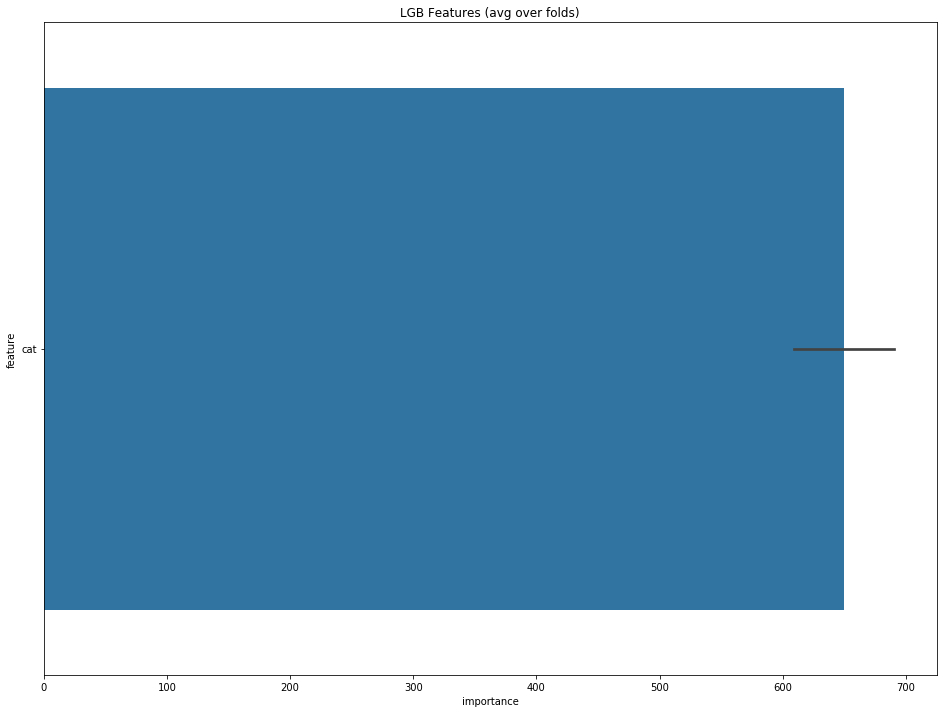

In [223]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [224]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 02:07:45 2019
Fold 1 started at Tue Dec 17 02:07:47 2019
Fold 2 started at Tue Dec 17 02:07:52 2019
Fold 3 started at Tue Dec 17 02:07:57 2019
Fold 4 started at Tue Dec 17 02:08:07 2019
Fold 5 started at Tue Dec 17 02:08:21 2019
Fold 6 started at Tue Dec 17 02:08:24 2019
Fold 7 started at Tue Dec 17 02:08:26 2019
Fold 8 started at Tue Dec 17 02:08:40 2019
Fold 9 started at Tue Dec 17 02:08:52 2019
CV mean score: 0.0034, std: 0.0024.


##### randomforest作为第二层融合模型

In [225]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 02:08:55 2019
Fold 1 started at Tue Dec 17 02:08:55 2019
Fold 2 started at Tue Dec 17 02:08:56 2019
Fold 3 started at Tue Dec 17 02:08:56 2019
Fold 4 started at Tue Dec 17 02:08:56 2019
Fold 5 started at Tue Dec 17 02:08:56 2019
Fold 6 started at Tue Dec 17 02:08:56 2019
Fold 7 started at Tue Dec 17 02:08:57 2019
Fold 8 started at Tue Dec 17 02:08:57 2019
Fold 9 started at Tue Dec 17 02:08:57 2019
CV mean score: 0.0036, std: 0.0024.


##### xgboost作为第二层融合模型

In [226]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 02:08:57 2019
[0]	train-rmse:0.550137	valid_data-rmse:0.552468
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.005112	valid_data-rmse:0.004692
[1000]	train-rmse:0.001232	valid_data-rmse:0.001381
Stopping. Best iteration:
[1242]	train-rmse:0.001071	valid_data-rmse:0.001373

Fold 1 started at Tue Dec 17 02:08:58 2019
[0]	train-rmse:0.550162	valid_data-rmse:0.55234
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.00514	valid_data-rmse:0.004178
Stopping. Best iteration:
[769]	train-rmse:0.001689	valid_data-rmse:0.001596

Fold 2 started at Tue Dec 17 02:08:58 2019
[0]	train-rmse:0.550262	valid_data-rmse:0.551404
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train 

##### svr 作为第二层融合模型

In [227]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 02:09:00 2019
Fold 1 started at Tue Dec 17 02:09:00 2019
Fold 2 started at Tue Dec 17 02:09:00 2019
Fold 3 started at Tue Dec 17 02:09:00 2019
Fold 4 started at Tue Dec 17 02:09:00 2019
Fold 5 started at Tue Dec 17 02:09:00 2019
Fold 6 started at Tue Dec 17 02:09:00 2019
Fold 7 started at Tue Dec 17 02:09:00 2019
Fold 8 started at Tue Dec 17 02:09:00 2019
Fold 9 started at Tue Dec 17 02:09:00 2019
CV mean score: 0.0197, std: 0.0037.


##### 岭回归做第二层融合模型

In [228]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 02:09:00 2019
Fold 1 started at Tue Dec 17 02:09:00 2019
Fold 2 started at Tue Dec 17 02:09:00 2019
Fold 3 started at Tue Dec 17 02:09:00 2019
Fold 4 started at Tue Dec 17 02:09:00 2019
Fold 5 started at Tue Dec 17 02:09:00 2019
Fold 6 started at Tue Dec 17 02:09:00 2019
Fold 7 started at Tue Dec 17 02:09:00 2019
Fold 8 started at Tue Dec 17 02:09:00 2019
Fold 9 started at Tue Dec 17 02:09:00 2019
CV mean score: 0.0039, std: 0.0023.


#### 只留下rfr

In [229]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 02:09:01 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[514]	training's rmse: 0.0074203	valid_1's rmse: 0.00374806
Fold 1 started at Tue Dec 17 02:09:01 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[521]	training's rmse: 0.00734641	valid_1's rmse: 0.00556332
Fold 2 started at Tue Dec 17 02:09:01 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[507]	training's rmse: 0.00731967	valid_1's rmse: 0.00551323
Fold 3 started at Tue Dec 17 02:09:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[478]	training's rmse: 0.00690791	valid_1's rmse: 0.0121693
Fold 4 started at Tue Dec 17 02:09:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[528]	training's rmse: 0.00651439	valid_1's rmse: 0.0

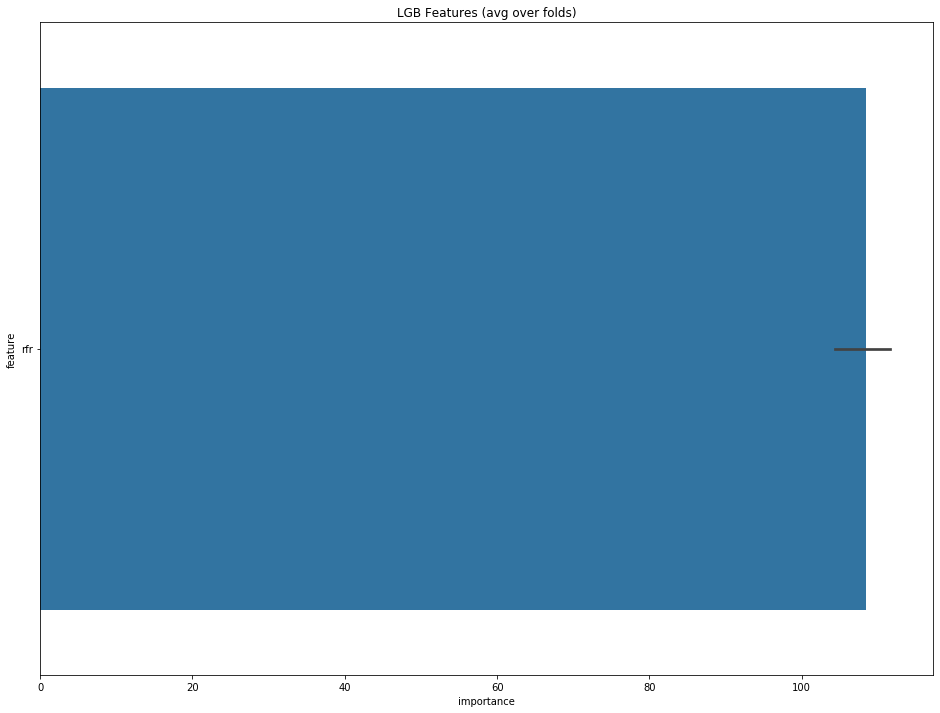

In [230]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 02:09:04 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00722829	valid_1's rmse: 0.00359116
[2000]	training's rmse: 0.00722636	valid_1's rmse: 0.00359028
Early stopping, best iteration is:
[2479]	training's rmse: 0.00722636	valid_1's rmse: 0.00359028
Fold 1 started at Tue Dec 17 02:09:05 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00715555	valid_1's rmse: 0.00535463
[2000]	training's rmse: 0.00715334	valid_1's rmse: 0.00535211
[3000]	training's rmse: 0.00715333	valid_1's rmse: 0.00535211
Early stopping, best iteration is:
[3493]	training's rmse: 0.00715333	valid_1's rmse: 0.00535211
Fold 2 started at Tue Dec 17 02:09:07 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00709057	valid_1's rmse: 0.00531335
[2000]	training's rmse: 0.00708832	valid_1's rmse: 0.00531099
[3000]	training's rmse: 0.00708832	valid_1's rmse: 0.0

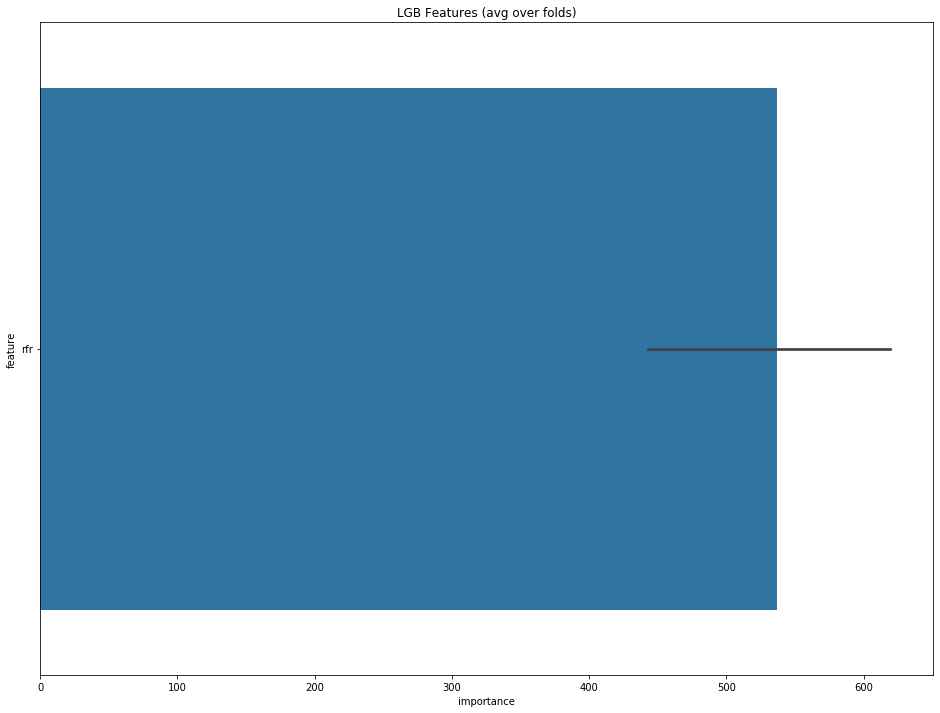

In [231]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [232]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 02:09:16 2019
Fold 1 started at Tue Dec 17 02:09:17 2019
Fold 2 started at Tue Dec 17 02:09:20 2019
Fold 3 started at Tue Dec 17 02:09:23 2019
Fold 4 started at Tue Dec 17 02:09:25 2019
Fold 5 started at Tue Dec 17 02:09:30 2019
Fold 6 started at Tue Dec 17 02:09:32 2019
Fold 7 started at Tue Dec 17 02:09:36 2019
Fold 8 started at Tue Dec 17 02:09:46 2019
Fold 9 started at Tue Dec 17 02:09:54 2019
CV mean score: 0.0059, std: 0.0025.


##### randomforest作为第二层融合模型

In [233]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 02:09:55 2019
Fold 1 started at Tue Dec 17 02:09:55 2019
Fold 2 started at Tue Dec 17 02:09:56 2019
Fold 3 started at Tue Dec 17 02:09:56 2019
Fold 4 started at Tue Dec 17 02:09:56 2019
Fold 5 started at Tue Dec 17 02:09:56 2019
Fold 6 started at Tue Dec 17 02:09:57 2019
Fold 7 started at Tue Dec 17 02:09:57 2019
Fold 8 started at Tue Dec 17 02:09:57 2019
Fold 9 started at Tue Dec 17 02:09:57 2019
CV mean score: 0.0066, std: 0.0025.


##### xgboost作为第二层融合模型

In [234]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 02:09:57 2019
[0]	train-rmse:0.550137	valid_data-rmse:0.552468
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.006652	valid_data-rmse:0.005892
Stopping. Best iteration:
[592]	train-rmse:0.004865	valid_data-rmse:0.005097

Fold 1 started at Tue Dec 17 02:09:58 2019
[0]	train-rmse:0.550162	valid_data-rmse:0.55234
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.006567	valid_data-rmse:0.006242
Stopping. Best iteration:
[658]	train-rmse:0.00407	valid_data-rmse:0.005084

Fold 2 started at Tue Dec 17 02:09:58 2019
[0]	train-rmse:0.550262	valid_data-rmse:0.551404
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.


##### svr 作为第二层融合模型

In [235]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 02:10:00 2019
Fold 1 started at Tue Dec 17 02:10:00 2019
Fold 2 started at Tue Dec 17 02:10:00 2019
Fold 3 started at Tue Dec 17 02:10:00 2019
Fold 4 started at Tue Dec 17 02:10:00 2019
Fold 5 started at Tue Dec 17 02:10:00 2019
Fold 6 started at Tue Dec 17 02:10:00 2019
Fold 7 started at Tue Dec 17 02:10:00 2019
Fold 8 started at Tue Dec 17 02:10:00 2019
Fold 9 started at Tue Dec 17 02:10:00 2019
CV mean score: 0.0197, std: 0.0037.


##### 岭回归做第二层融合模型

In [236]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 02:10:00 2019
Fold 1 started at Tue Dec 17 02:10:00 2019
Fold 2 started at Tue Dec 17 02:10:00 2019
Fold 3 started at Tue Dec 17 02:10:00 2019
Fold 4 started at Tue Dec 17 02:10:00 2019
Fold 5 started at Tue Dec 17 02:10:00 2019
Fold 6 started at Tue Dec 17 02:10:00 2019
Fold 7 started at Tue Dec 17 02:10:00 2019
Fold 8 started at Tue Dec 17 02:10:00 2019
Fold 9 started at Tue Dec 17 02:10:00 2019
CV mean score: 0.0063, std: 0.0027.


#### 只留下svr

In [237]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['svr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 02:10:00 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 0.0194983	valid_1's rmse: 0.0138751
Fold 1 started at Tue Dec 17 02:10:01 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 1.05552	valid_1's rmse: 1.05321
Fold 2 started at Tue Dec 17 02:10:01 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 0.0190423	valid_1's rmse: 0.0185489
Fold 3 started at Tue Dec 17 02:10:01 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 1.05654	valid_1's rmse: 1.06479
Fold 4 started at Tue Dec 17 02:10:01 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 1.05519	valid_1's rmse: 1.04963
Fold 5 started at Tue 

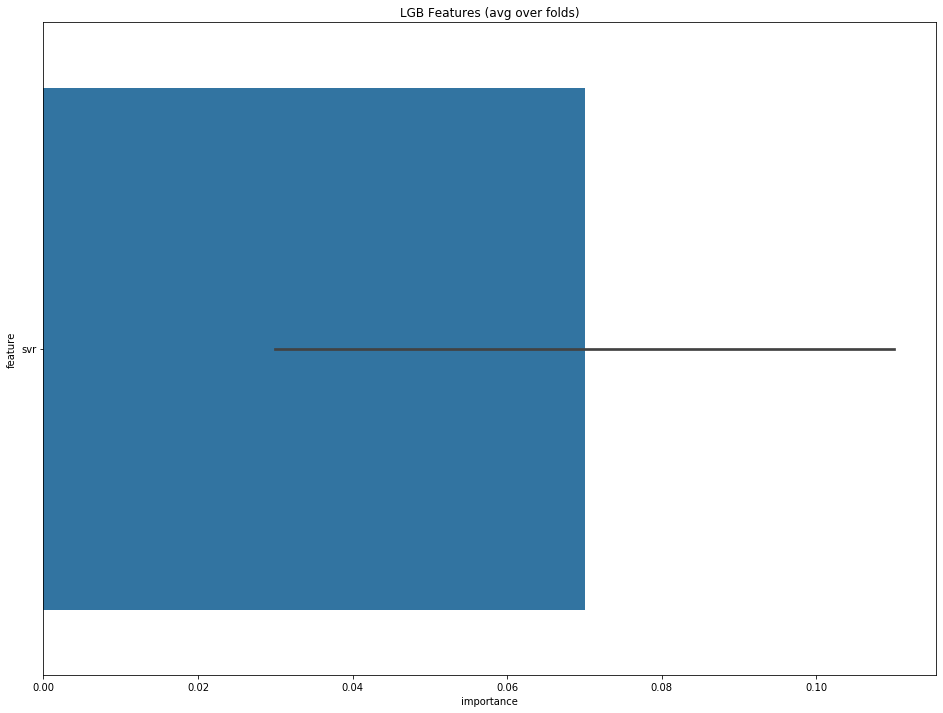

In [238]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 02:10:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 1.0555	valid_1's rmse: 1.0529
Fold 1 started at Tue Dec 17 02:10:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 1.05552	valid_1's rmse: 1.05321
Fold 2 started at Tue Dec 17 02:10:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 1.05563	valid_1's rmse: 1.05446
Fold 3 started at Tue Dec 17 02:10:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 1.05654	valid_1's rmse: 1.06479
Fold 4 started at Tue Dec 17 02:10:03 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 1.05519	valid_1's rmse: 1.04963
Fold 5 started at Tue Dec 17 02:

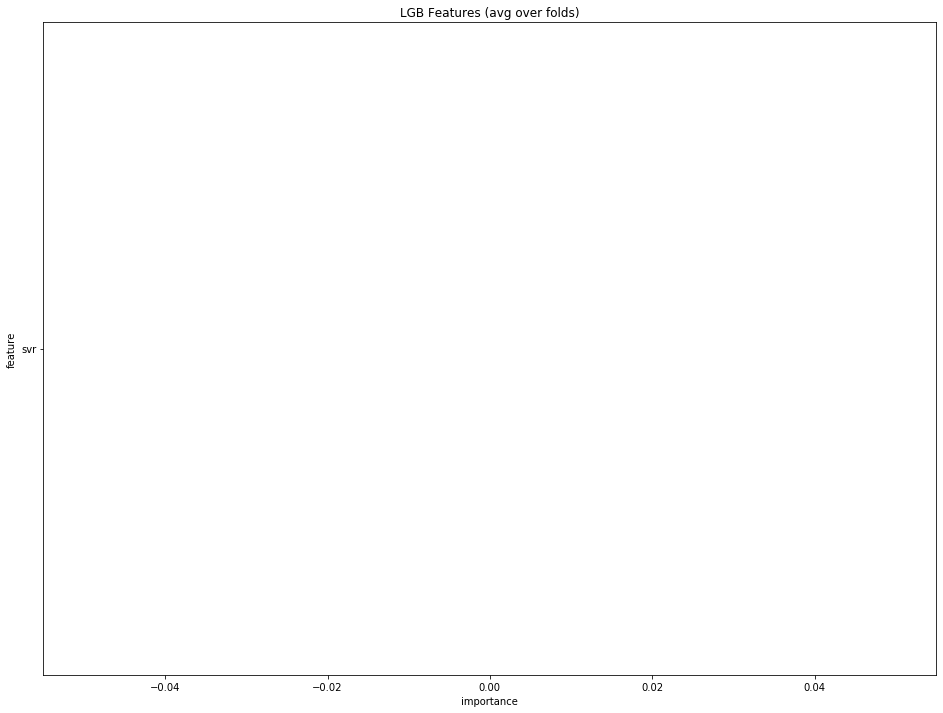

In [239]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [240]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 02:10:04 2019
Fold 1 started at Tue Dec 17 02:10:05 2019
Fold 2 started at Tue Dec 17 02:10:06 2019
Fold 3 started at Tue Dec 17 02:10:07 2019
Fold 4 started at Tue Dec 17 02:10:20 2019
Fold 5 started at Tue Dec 17 02:10:32 2019
Fold 6 started at Tue Dec 17 02:10:33 2019
Fold 7 started at Tue Dec 17 02:10:33 2019
Fold 8 started at Tue Dec 17 02:10:33 2019
Fold 9 started at Tue Dec 17 02:10:33 2019
CV mean score: 0.0188, std: 0.0030.


##### randomforest作为第二层融合模型

In [241]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 02:10:34 2019
Fold 1 started at Tue Dec 17 02:10:35 2019
Fold 2 started at Tue Dec 17 02:10:35 2019
Fold 3 started at Tue Dec 17 02:10:35 2019
Fold 4 started at Tue Dec 17 02:10:35 2019
Fold 5 started at Tue Dec 17 02:10:35 2019
Fold 6 started at Tue Dec 17 02:10:36 2019
Fold 7 started at Tue Dec 17 02:10:36 2019
Fold 8 started at Tue Dec 17 02:10:36 2019
Fold 9 started at Tue Dec 17 02:10:36 2019
CV mean score: 0.0188, std: 0.0030.


##### xgboost作为第二层融合模型

In [242]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 02:10:37 2019
[0]	train-rmse:0.550137	valid_data-rmse:0.552468
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.019653	valid_data-rmse:0.014893
[1000]	train-rmse:0.019274	valid_data-rmse:0.013823
Stopping. Best iteration:
[996]	train-rmse:0.019274	valid_data-rmse:0.013818

Fold 1 started at Tue Dec 17 02:10:37 2019
[0]	train-rmse:0.550162	valid_data-rmse:0.55234
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.019361	valid_data-rmse:0.01768
[1000]	train-rmse:0.018992	valid_data-rmse:0.016885
[1500]	train-rmse:0.018992	valid_data-rmse:0.016881
Stopping. Best iteration:
[1380]	train-rmse:0.018992	valid_data-rmse:0.016868

Fold 2 started at Tue Dec 17 02:10:37 2019
[0]	train-rmse:0.550262	valid_data-rmse:0.551404

##### svr 作为第二层融合模型

In [243]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 02:10:38 2019
Fold 1 started at Tue Dec 17 02:10:38 2019
Fold 2 started at Tue Dec 17 02:10:38 2019
Fold 3 started at Tue Dec 17 02:10:38 2019
Fold 4 started at Tue Dec 17 02:10:38 2019
Fold 5 started at Tue Dec 17 02:10:38 2019
Fold 6 started at Tue Dec 17 02:10:38 2019
Fold 7 started at Tue Dec 17 02:10:38 2019
Fold 8 started at Tue Dec 17 02:10:38 2019
Fold 9 started at Tue Dec 17 02:10:38 2019
CV mean score: 0.0197, std: 0.0037.


##### 岭回归做第二层融合模型

In [244]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 02:10:38 2019
Fold 1 started at Tue Dec 17 02:10:38 2019
Fold 2 started at Tue Dec 17 02:10:38 2019
Fold 3 started at Tue Dec 17 02:10:38 2019
Fold 4 started at Tue Dec 17 02:10:39 2019
Fold 5 started at Tue Dec 17 02:10:39 2019
Fold 6 started at Tue Dec 17 02:10:39 2019
Fold 7 started at Tue Dec 17 02:10:39 2019
Fold 8 started at Tue Dec 17 02:10:39 2019
Fold 9 started at Tue Dec 17 02:10:39 2019
CV mean score: 0.0188, std: 0.0030.


#### 只留下xgb

In [245]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_xgb]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['xgb'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 02:10:39 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[551]	training's rmse: 0.006286	valid_1's rmse: 0.00322666
Fold 1 started at Tue Dec 17 02:10:40 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[575]	training's rmse: 0.00627005	valid_1's rmse: 0.00437848
Fold 2 started at Tue Dec 17 02:10:40 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[506]	training's rmse: 0.00626792	valid_1's rmse: 0.00501286
Fold 3 started at Tue Dec 17 02:10:40 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[539]	training's rmse: 0.00582874	valid_1's rmse: 0.011044
Fold 4 started at Tue Dec 17 02:10:41 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[529]	training's rmse: 0.00550617	valid_1's rmse: 0.011

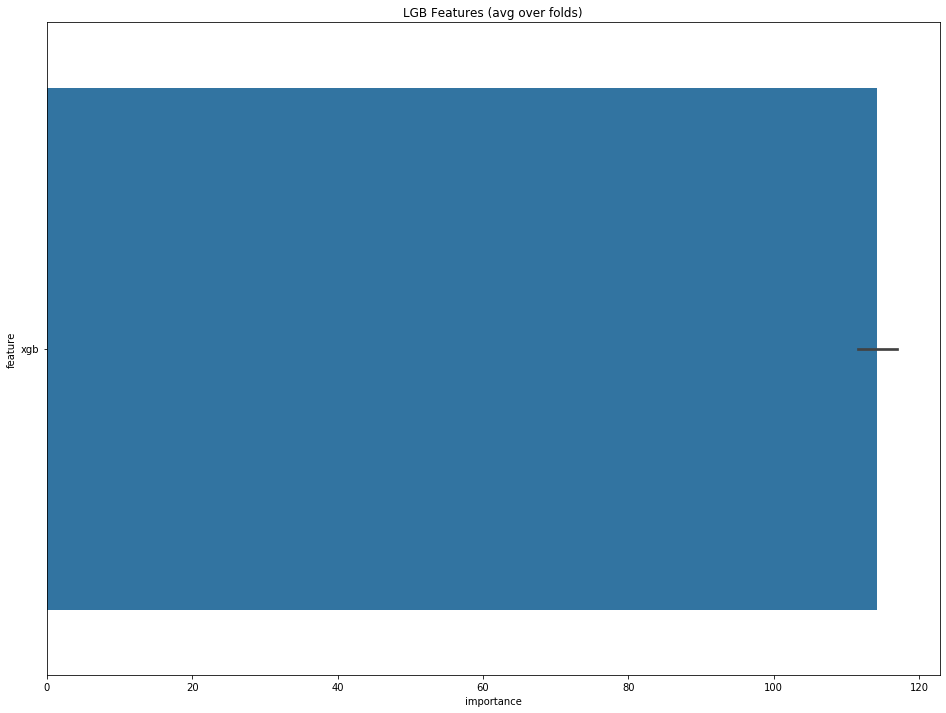

In [246]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 02:10:43 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00603363	valid_1's rmse: 0.00308439
[2000]	training's rmse: 0.00603069	valid_1's rmse: 0.00308293
[3000]	training's rmse: 0.00603069	valid_1's rmse: 0.00308293
[4000]	training's rmse: 0.00603069	valid_1's rmse: 0.00308293
Early stopping, best iteration is:
[4295]	training's rmse: 0.00603069	valid_1's rmse: 0.00308293
Fold 1 started at Tue Dec 17 02:10:45 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00603994	valid_1's rmse: 0.00414585
[2000]	training's rmse: 0.00603691	valid_1's rmse: 0.00414293
[3000]	training's rmse: 0.00603691	valid_1's rmse: 0.00414293
Early stopping, best iteration is:
[3556]	training's rmse: 0.00603691	valid_1's rmse: 0.00414293
Fold 2 started at Tue Dec 17 02:10:47 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00594846	valid_1's rmse: 0.0

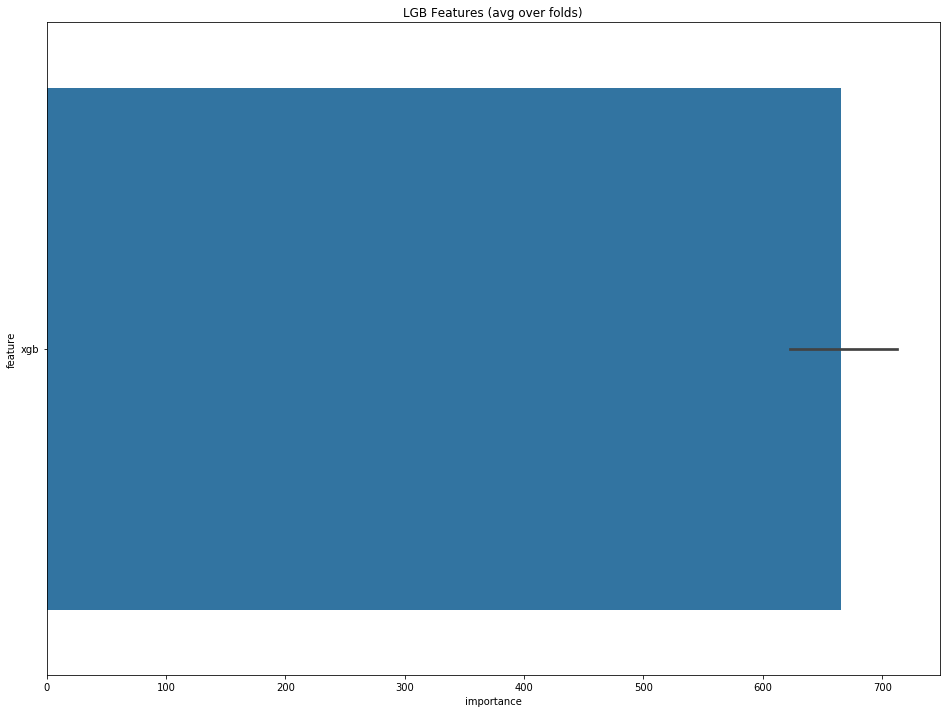

In [247]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [248]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 02:10:59 2019
Fold 1 started at Tue Dec 17 02:11:02 2019
Fold 2 started at Tue Dec 17 02:11:06 2019
Fold 3 started at Tue Dec 17 02:11:07 2019
Fold 4 started at Tue Dec 17 02:11:22 2019
Fold 5 started at Tue Dec 17 02:11:35 2019
Fold 6 started at Tue Dec 17 02:11:38 2019
Fold 7 started at Tue Dec 17 02:11:40 2019
Fold 8 started at Tue Dec 17 02:11:48 2019
Fold 9 started at Tue Dec 17 02:11:54 2019
CV mean score: 0.0034, std: 0.0023.


##### randomforest作为第二层融合模型

In [249]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 02:11:57 2019
Fold 1 started at Tue Dec 17 02:11:57 2019
Fold 2 started at Tue Dec 17 02:11:57 2019
Fold 3 started at Tue Dec 17 02:11:57 2019
Fold 4 started at Tue Dec 17 02:11:57 2019
Fold 5 started at Tue Dec 17 02:11:58 2019
Fold 6 started at Tue Dec 17 02:11:58 2019
Fold 7 started at Tue Dec 17 02:11:58 2019
Fold 8 started at Tue Dec 17 02:11:58 2019
Fold 9 started at Tue Dec 17 02:11:59 2019
CV mean score: 0.0037, std: 0.0024.


##### xgboost作为第二层融合模型

In [250]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 02:11:59 2019
[0]	train-rmse:0.550137	valid_data-rmse:0.552468
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.005156	valid_data-rmse:0.004482
Stopping. Best iteration:
[684]	train-rmse:0.002107	valid_data-rmse:0.002889

Fold 1 started at Tue Dec 17 02:11:59 2019
[0]	train-rmse:0.550162	valid_data-rmse:0.55234
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.005177	valid_data-rmse:0.004383
Stopping. Best iteration:
[634]	train-rmse:0.002514	valid_data-rmse:0.002857

Fold 2 started at Tue Dec 17 02:11:59 2019
[0]	train-rmse:0.550262	valid_data-rmse:0.551404
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.

##### svr 作为第二层融合模型

In [251]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 02:12:01 2019
Fold 1 started at Tue Dec 17 02:12:01 2019
Fold 2 started at Tue Dec 17 02:12:01 2019
Fold 3 started at Tue Dec 17 02:12:01 2019
Fold 4 started at Tue Dec 17 02:12:01 2019
Fold 5 started at Tue Dec 17 02:12:01 2019
Fold 6 started at Tue Dec 17 02:12:01 2019
Fold 7 started at Tue Dec 17 02:12:01 2019
Fold 8 started at Tue Dec 17 02:12:01 2019
Fold 9 started at Tue Dec 17 02:12:01 2019
CV mean score: 0.0197, std: 0.0037.


##### 岭回归做第二层融合模型

In [252]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 02:12:01 2019
Fold 1 started at Tue Dec 17 02:12:01 2019
Fold 2 started at Tue Dec 17 02:12:01 2019
Fold 3 started at Tue Dec 17 02:12:01 2019
Fold 4 started at Tue Dec 17 02:12:01 2019
Fold 5 started at Tue Dec 17 02:12:01 2019
Fold 6 started at Tue Dec 17 02:12:01 2019
Fold 7 started at Tue Dec 17 02:12:01 2019
Fold 8 started at Tue Dec 17 02:12:02 2019
Fold 9 started at Tue Dec 17 02:12:02 2019
CV mean score: 0.0038, std: 0.0024.


#### 只留下lgb

In [253]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb,  oof_lgb_1, oof_lgb_2]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb',  'lgb_1', 'lgb_2'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 02:12:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[550]	training's rmse: 0.00632448	valid_1's rmse: 0.00321641
Fold 1 started at Tue Dec 17 02:12:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[575]	training's rmse: 0.00629993	valid_1's rmse: 0.00439966
Fold 2 started at Tue Dec 17 02:12:03 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[507]	training's rmse: 0.00632586	valid_1's rmse: 0.00476732
Fold 3 started at Tue Dec 17 02:12:03 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[539]	training's rmse: 0.00589601	valid_1's rmse: 0.0108907
Fold 4 started at Tue Dec 17 02:12:03 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[529]	training's rmse: 0.00550331	valid_1's rmse: 0.

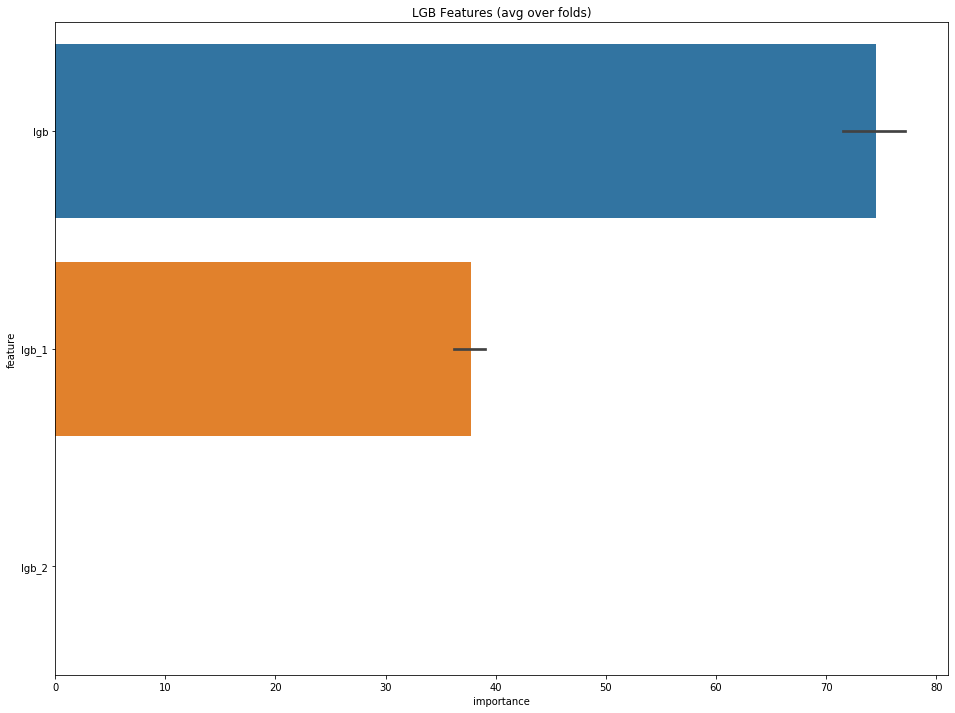

In [254]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 02:12:06 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00610014	valid_1's rmse: 0.00311819
[2000]	training's rmse: 0.00609758	valid_1's rmse: 0.00311725
[3000]	training's rmse: 0.00609758	valid_1's rmse: 0.00311725
Early stopping, best iteration is:
[3434]	training's rmse: 0.00609758	valid_1's rmse: 0.00311725
Fold 1 started at Tue Dec 17 02:12:07 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00608123	valid_1's rmse: 0.00418015
[2000]	training's rmse: 0.00607828	valid_1's rmse: 0.00417735
[3000]	training's rmse: 0.00607828	valid_1's rmse: 0.00417735
Early stopping, best iteration is:
[2862]	training's rmse: 0.00607828	valid_1's rmse: 0.00417735
Fold 2 started at Tue Dec 17 02:12:09 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00604474	valid_1's rmse: 0.00452251
[2000]	training's rmse: 0.00604216	valid_1's rmse: 0.0

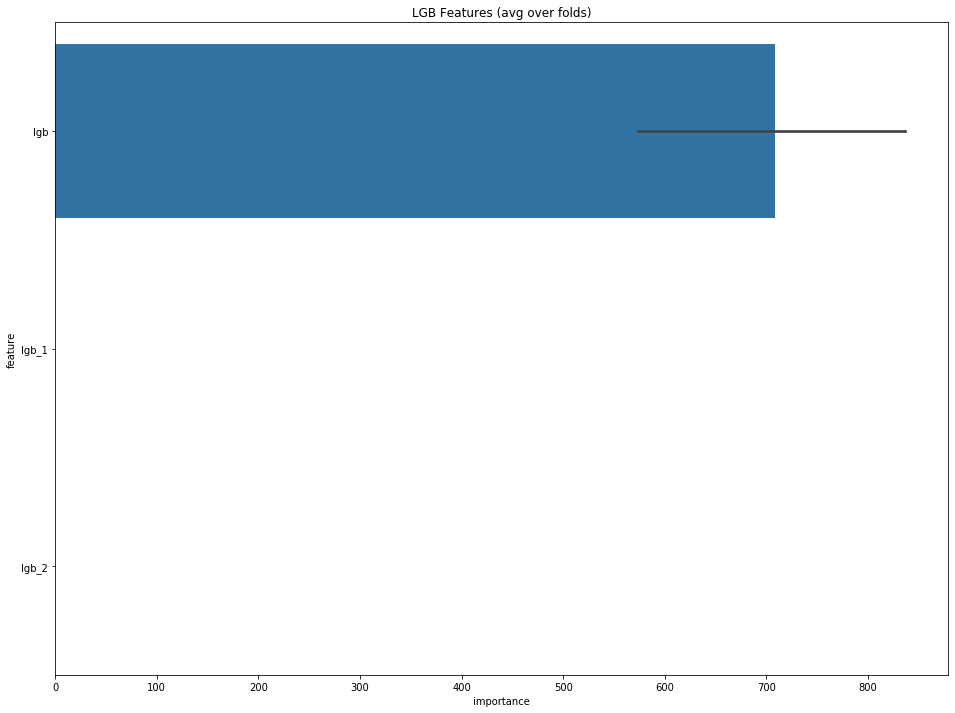

In [255]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [256]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 02:12:25 2019
Fold 1 started at Tue Dec 17 02:12:27 2019
Fold 2 started at Tue Dec 17 02:12:30 2019
Fold 3 started at Tue Dec 17 02:12:33 2019
Fold 4 started at Tue Dec 17 02:12:38 2019
Fold 5 started at Tue Dec 17 02:12:42 2019
Fold 6 started at Tue Dec 17 02:12:44 2019
Fold 7 started at Tue Dec 17 02:12:46 2019
Fold 8 started at Tue Dec 17 02:12:49 2019
Fold 9 started at Tue Dec 17 02:12:50 2019
CV mean score: 0.0047, std: 0.0027.


##### randomforest作为第二层融合模型

In [257]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 02:12:52 2019
Fold 1 started at Tue Dec 17 02:12:52 2019
Fold 2 started at Tue Dec 17 02:12:52 2019
Fold 3 started at Tue Dec 17 02:12:52 2019
Fold 4 started at Tue Dec 17 02:12:53 2019
Fold 5 started at Tue Dec 17 02:12:53 2019
Fold 6 started at Tue Dec 17 02:12:53 2019
Fold 7 started at Tue Dec 17 02:12:53 2019
Fold 8 started at Tue Dec 17 02:12:54 2019
Fold 9 started at Tue Dec 17 02:12:54 2019
CV mean score: 0.0052, std: 0.0025.


##### xgboost作为第二层融合模型

In [258]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 02:12:54 2019
[0]	train-rmse:0.550137	valid_data-rmse:0.552468
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.006038	valid_data-rmse:0.005445
Stopping. Best iteration:
[648]	train-rmse:0.003885	valid_data-rmse:0.004266

Fold 1 started at Tue Dec 17 02:12:54 2019
[0]	train-rmse:0.550162	valid_data-rmse:0.55234
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.005975	valid_data-rmse:0.004543
Stopping. Best iteration:
[664]	train-rmse:0.003702	valid_data-rmse:0.00343

Fold 2 started at Tue Dec 17 02:12:54 2019
[0]	train-rmse:0.550262	valid_data-rmse:0.551404
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.


##### svr 作为第二层融合模型

In [259]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 02:12:55 2019
Fold 1 started at Tue Dec 17 02:12:55 2019
Fold 2 started at Tue Dec 17 02:12:55 2019
Fold 3 started at Tue Dec 17 02:12:55 2019
Fold 4 started at Tue Dec 17 02:12:55 2019
Fold 5 started at Tue Dec 17 02:12:55 2019
Fold 6 started at Tue Dec 17 02:12:55 2019
Fold 7 started at Tue Dec 17 02:12:55 2019
Fold 8 started at Tue Dec 17 02:12:55 2019
Fold 9 started at Tue Dec 17 02:12:55 2019
CV mean score: 0.0197, std: 0.0037.


##### 岭回归做第二层融合模型

In [260]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 02:12:55 2019
Fold 1 started at Tue Dec 17 02:12:55 2019
Fold 2 started at Tue Dec 17 02:12:56 2019
Fold 3 started at Tue Dec 17 02:12:56 2019
Fold 4 started at Tue Dec 17 02:12:56 2019
Fold 5 started at Tue Dec 17 02:12:56 2019
Fold 6 started at Tue Dec 17 02:12:56 2019
Fold 7 started at Tue Dec 17 02:12:56 2019
Fold 8 started at Tue Dec 17 02:12:56 2019
Fold 9 started at Tue Dec 17 02:12:56 2019
CV mean score: 0.0051, std: 0.0029.
